# RAG evaluation

See: https://huggingface.co/learn/cookbook/rag_evaluation

In [1]:
import pandas as pd
import psycopg2

db_host = "localhost"
db_name = "PersianPoetry"
db_user = "simon"
db_password = "shehr farsi"

try:
    # Connect to PostgreSQL
    conn = psycopg2.connect(host=db_host, database=db_name, user=db_user, password=db_password)
    cursor = conn.cursor()

    masnavi = pd.read_sql(f"SELECT * FROM masnavi;", conn)
    ghazal = pd.read_sql(f"SELECT * FROM ghazal;", conn)

    cursor.close()
    conn.close()

except psycopg2.Error as e:
    print(f"Error connecting to PostgreSQL: {e}")

/var/folders/rp/kkdtstj57150fz8lr4ssyzjr0000gp/T/ipykernel_87531/3088733360.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  masnavi = pd.read_sql(f"SELECT * FROM masnavi;", conn)
/var/folders/rp/kkdtstj57150fz8lr4ssyzjr0000gp/T/ipykernel_87531/3088733360.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  ghazal = pd.read_sql(f"SELECT * FROM ghazal;", conn)


In [2]:
from langchain_core.documents import Document
import uuid

masnavi_documents = [
    Document(
        page_content = f"{row_data['beyt1']} {row_data['beyt2']}",
        metadata = {
            "id": str(uuid.uuid4()),
            "type": "masnavi",
            "book_or_ghazal": row_data['book'],
            "line": row_data['number'],
            "translation": f"{row_data['beyt1_en']} {row_data['beyt2_en']}"
        }
    )
    for idx, (_, row_data) in enumerate(masnavi.iterrows())
]

ghazal_documents = [
    Document(
        page_content = f"{row_data['beyt1']} {row_data['beyt2']}",
        metadata = {
            "id": idx,
            "type": "ghazal",
            "book_or_ghazal": row_data['ghazal_num'],
            "line": row_data['beyt_num'],
            "translation": "",
        }
    )
    for idx, (_, row_data) in enumerate(ghazal.iterrows())
]

In [3]:
documents = masnavi_documents + ghazal_documents

In [ ]:
from langchain_ollama import ChatOllama
from langchain_core.prompts import PromptTemplate

llm = ChatOllama(model="gemma3n:e4b")

question_generation_template = PromptTemplate.from_template(
    """
    Your task is to write questions users could ask about Rumi's Persian poetry and an answer given a context.
    Your question should be answerable with a specific, concise piece of factual information from the context.
    Your question should be formulated in the same style as questions that users interested about Persian poetry could ask in a Persian poetry search engine or chatbot,
    so think about questions that would be truly intersting to a user curious about Persian poetry.
    Don't reference the poem or verse because the user will not have directly access to it.
    The answers must be a one sentence short explanation that relies entierly on the context.

    This means that your factoid question MUST NOT mention something like "the passage" or "in the context" or "the verse" or "this poem" or "the text",
    but you can use "What does Rumi says about" or "In Persian poetry" or "Is there any verse talking about" or "Is there any verse similar to" or similar general formulations.
    
    Provide your answer as follows:

    Output:::
    Question: (your question)
    Answer: (your answer to the question)

    Example 1::
    Question: What does Rumi suggests is necessary for achieving immortality?\n
    Answer: A pure heart.\n

    Example 2::
    Question: What should we strive to cultivate?\n
    Answer: Love and affection\n

    Now here is the context.

    Context: {context}\n
    Output:::"""
)


In [213]:
import random
from tqdm import tqdm

N_GENERATIONS = 500

print(f"Generating {N_GENERATIONS} QA couples...")

outputs = []
for sampled_context in tqdm(random.sample(documents, N_GENERATIONS)):

    prompt = question_generation_template.invoke({"context": sampled_context.page_content})
    generated_question_answer = llm.invoke(prompt).content

    try:
        question = generated_question_answer.split("Question: ")[-1].split("Answer: ")[0].strip()
        answer = generated_question_answer.split("Answer: ")[-1].strip()
        assert len(answer) < 300, "Answer is too long"

        outputs.append(
            {
                "context": sampled_context.page_content,
                "question": question,
                "answer": answer,
                "type": sampled_context.metadata["type"],
                "book_or_ghazal": sampled_context.metadata["book_or_ghazal"],
                "line": sampled_context.metadata["line"],
            }
        )
    except:
        print("...")
        continue


Generating 500 QA couples...


 13%|█▎        | 65/500 [01:47<12:54,  1.78s/it]

...


100%|██████████| 500/500 [13:21<00:00,  1.60s/it]


In [214]:
outputs

[{'context': 'آن مُقلِّد چون ندانَد جز دلیل در علامت جوید او دایم سبیل',
  'question': 'What does Rumi say the imitator constantly seeks in signs, other than reason?',
  'answer': 'The imitator constantly seeks means.',
  'type': 'masnavi',
  'book_or_ghazal': 4,
  'line': 2167},
 {'context': 'این سزای آنکه اندر طَمْعِ خام ترک گوید خدمتِ خاکِ کِرام',
  'question': 'What does Rumi suggest as the appropriate response to abandoning worldly desires?',
  'answer': 'He suggests serving the humble and noble.',
  'type': 'masnavi',
  'book_or_ghazal': 3,
  'line': 638},
 {'context': 'دیویست در اسرار تو کز وی نگون شد کار تو بربند این دم محکمش کالصبر مفتاح الفرج',
  'question': 'What does Rumi suggest is the key to unlocking a difficult moment?',
  'answer': 'Patience is the key to unlocking a difficult moment.',
  'type': 'ghazal',
  'book_or_ghazal': 519,
  'line': 9},
 {'context': 'بودم اومیدی به محضِ لطفِ تو از ورایِ راست باشی یا عُتو',
  'question': "What does Rumi say arises from the grace

### Setup critique agents

In [215]:
question_groundedness_critique_prompt = PromptTemplate.from_template(
    """
    You will be given a context and a question.
    Your task is to provide a 'total rating' scoring how well one can answer the given question unambiguously with the given context.
    Give your answer on a scale of 1 to 5, where 1 means that the question is not answerable at all given the context, and 5 means that the question is clearly and unambiguously answerable with the context.
    For instance, 'What does the text suggest people did with his dust?' we cannot know what 'his' refers to without the context so this question should be graded 1.
    
    Provide your answer as follows:

    Answer:::
    Evaluation: (your rationale for the rating, as a text)
    Total rating: (your rating, as a number between 1 and 5)

    You MUST provide values for 'Evaluation:' and 'Total rating:' in your answer.

    Now here are the question and context.

    Question: {question}\n
    Context: {context}\n
    Answer::: """
)

question_relevance_critique_prompt = PromptTemplate.from_template(
    """
    You will be given a question.
    Your task is to provide a 'total rating' representing how useful this question can be to people curious about Persian poetry or interested about its wisdom.
    Give your answer on a scale of 1 to 5, where 1 means that the question is not useful at all, and 5 means that the question is extremely useful.

    Provide your answer as follows:

    Answer:::
    Evaluation: (your rationale for the rating, as a text)
    Total rating: (your rating, as a number between 1 and 5)

    You MUST provide values for 'Evaluation:' and 'Total rating:' in your answer.

    Now here is the question.

    Question: {question}\n
    Answer::: """
)

question_standalone_critique_prompt = PromptTemplate.from_template(
    """
    You will be given a question.
    Your task is to provide a 'total rating' representing how context-independent this question is.
    Give your answer on a scale of 1 to 5, where 1 means that the question depends on additional information to be understood, and 5 means that the question makes sense by itself.
    For instance, if the question refers to a particular setting, like 'in the context' or "in this text" or "in this verse" or 'in the document', the rating must be 1.
    The questions can contain poetic Persian symbols or metaphors like liver (jigar) and still be a 5: it must simply be clear to someone wanting to learn about Persian poetry.
    You should never penalize the use of Persian, you MUST NOT include things like "Without a translation..."

    For instance, "What is the name of the person in this text?" should receive a 1, since there is an implicit mention of a context, thus the question is not independent from the context.

    Provide your answer as follows:

    Answer:::
    Evaluation: (your rationale for the rating, as a text)
    Total rating: (your rating, as a number between 1 and 5)

    You MUST provide values for 'Evaluation:' and 'Total rating:' in your answer.

    Now here is the question.

    Question: {question}\n
    Answer::: """
)

In [216]:
print("Generating critique for each QA couple...")

for output in tqdm(outputs):
    evaluations = {
        "groundedness": llm.invoke(
            question_groundedness_critique_prompt.invoke({"context": output["context"], "question": output["question"]})
        ).content,
        "relevance": llm.invoke(
            question_relevance_critique_prompt.invoke({"question": output["question"]}),
        ).content,
        "standalone": llm.invoke(
            question_standalone_critique_prompt.invoke({"question": output["question"]}),
        ).content,
    }
    try:
        for criterion, evaluation in evaluations.items():
            score, eval = (
                int(evaluation.split("Total rating: ")[-1].strip()),
                evaluation.split("Total rating: ")[-2].split("Evaluation: ")[1],
            )
            output.update(
                {
                    f"{criterion}_score": score,
                    f"{criterion}_eval": eval,
                }
            )
    except Exception as e:
        print(e)
        continue

Generating critique for each QA couple...


100%|██████████| 499/499 [1:36:15<00:00, 11.57s/it]


Evaluation dataset before filtering:


,question,answer,groundedness_score,relevance_score,standalone_score
0,What does Rumi say the imitator constantly see...,The imitator constantly seeks means.,5,5,5
1,What does Rumi suggest as the appropriate resp...,He suggests serving the humble and noble.,3,5,5
2,What does Rumi suggest is the key to unlocking...,Patience is the key to unlocking a difficult m...,5,5,5
3,What does Rumi say arises from the grace of th...,"Hope arises from the grace of the beloved, whe...",5,5,3
4,"What does Rumi advise regarding the body, even...","He urges one to rise up and be proud, despite ...",5,5,5
...,...,...,...,...,...
494,What does Rumi say about the nature of knowled...,Rumi suggests that one should dedicate themsel...,4,5,5
495,What does Rumi say about the relationship betw...,"Rumi suggests that at every moment, life tells...",5,5,5
496,What does Rumi suggest is needed to find clari...,Rumi suggests opening your eyes to find an ans...,4,5,5
497,What state of being does Rumi describe humanit...,Rumi describes humanity as being hidden and we...,4,5,5


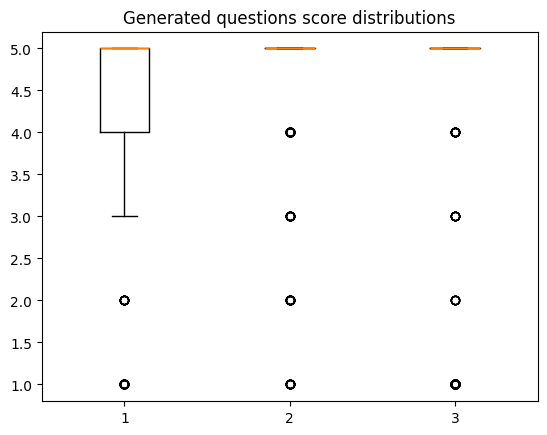

Final evaluation dataset:


,question,answer,groundedness_score,relevance_score,standalone_score
0,What does Rumi say the imitator constantly see...,The imitator constantly seeks means.,5,5,5
2,What does Rumi suggest is the key to unlocking...,Patience is the key to unlocking a difficult m...,5,5,5
4,"What does Rumi advise regarding the body, even...","He urges one to rise up and be proud, despite ...",5,5,5
6,What does Rumi say will protect a part of us f...,A single vein will remain with us.,5,5,5
7,What does Rumi compare his soul and heart to?,Rumi compares his soul and heart to the face o...,5,5,5
...,...,...,...,...,...
491,What does Rumi suggest to do to be secure in t...,He advises making a pact to become bashful in ...,5,5,5
494,What does Rumi say about the nature of knowled...,Rumi suggests that one should dedicate themsel...,4,5,5
495,What does Rumi say about the relationship betw...,"Rumi suggests that at every moment, life tells...",5,5,5
496,What does Rumi suggest is needed to find clari...,Rumi suggests opening your eyes to find an ans...,4,5,5


In [219]:
import pandas as pd
import matplotlib.pyplot as plt

SCORE_THRESHOLD = 4

generated_questions = pd.DataFrame.from_dict(outputs)

print("Evaluation dataset before filtering:")

display(
    generated_questions[
        [
            "question",
            "answer",
            "groundedness_score",
            "relevance_score",
            "standalone_score",
        ]
    ]
)

plt.title("Generated questions score distributions")
plt.boxplot([
    generated_questions['groundedness_score'],
    generated_questions['relevance_score'],
    generated_questions['standalone_score'],
])
plt.show()
plt.close()

generated_questions_filtered = generated_questions.query("groundedness_score >= @SCORE_THRESHOLD and relevance_score >= @SCORE_THRESHOLD and standalone_score >= @SCORE_THRESHOLD")

print("============================================")
print("Final evaluation dataset:")
display(
    generated_questions_filtered[
        [
            "question",
            "answer",
            "groundedness_score",
            "relevance_score",
            "standalone_score",
        ]
    ]
)

generated_questions_filtered.to_parquet("./evaluation_dataset.parquet")

#eval_dataset = datasets.Dataset.from_pandas(
#    generated_questions, split="train", preserve_index=False
#)

In [ ]:
import pandas as pd
import numpy as np

generated_questions_filtered = pd.read_parquet("./evaluation_dataset.parquet")

In [10]:
generated_questions_filtered.sample(n=1)[["question", "answer"]].to_numpy()

array([['What does Rumi say will protect a part of us from his attacks and harsh wounds?',
        'A single vein will remain with us.']], dtype=object)

## Evaluate

In [2]:
generated_questions_filtered

,context,question,answer,type,book_or_ghazal,line,groundedness_score,groundedness_eval,relevance_score,relevance_eval,standalone_score,standalone_eval
0,آن مُقلِّد چون ندانَد جز دلیل در علامت جوید او...,What does Rumi say the imitator constantly see...,The imitator constantly seeks means.,masnavi,4,2167,5,"The context states that ""an imitator, when he ...",5,This question directly targets a core theme in...,5,The question asks about the meaning of a state...
2,دیویست در اسرار تو کز وی نگون شد کار تو بربند ...,What does Rumi suggest is the key to unlocking...,Patience is the key to unlocking a difficult m...,ghazal,519,9,5,"The context is in Persian. The phrase ""مفتاح ا...",5,This is a very good question for someone inter...,5,The question asks about a specific suggestion ...
4,برآر باز سر، ای استخوانِ پوسیده اگرچه سخرهٔ ما...,"What does Rumi advise regarding the body, even...","He urges one to rise up and be proud, despite ...",ghazal,3073,10,5,The context is a Persian poem by Rumi. The que...,5,This question is excellent because it delves i...,5,The question asks about advice from Rumi regar...
6,از حمله های جند او وز زخم های تند او سالم نمان...,What does Rumi say will protect a part of us f...,A single vein will remain with us.,ghazal,6,2,5,The context is in Persian. The question asks w...,5,This question is excellent for someone interes...,5,The question asks about a specific concept att...
7,راست رود سوی شه جان و دلم همچو رخ گر چه کند کژ...,What does Rumi compare his soul and heart to?,Rumi compares his soul and heart to the face o...,ghazal,2066,11,5,The context is a line of Persian poetry by Rum...,5,This is a good question for someone wanting to...,5,The question asks about a comparison made by R...
...,...,...,...,...,...,...,...,...,...,...,...,...
491,پس چرا ایمن شوی بر رایِ دل عهد بندی تا شوی آخِ...,What does Rumi suggest to do to be secure in t...,He advises making a pact to become bashful in ...,masnavi,3,1645,5,"The context is in Persian. Translating it, we ...",5,This question is quite useful for someone expl...,5,The question asks about the meaning of a sugge...
494,تو مشو غِرّه به علمش، عهد جُو علم چون قشرست و،...,What does Rumi say about the nature of knowled...,Rumi suggests that one should dedicate themsel...,masnavi,5,1170,4,The context is in Persian. The question asks a...,5,This is a very good question for someone inter...,5,The question asks about the views of a specifi...
495,هر لحظه روت گوید من شمع شب فروزم هر لحظه موت گ...,What does Rumi say about the relationship betw...,"Rumi suggests that at every moment, life tells...",ghazal,1697,4,5,The context is a Persian poem by Rumi. The que...,5,This is a very good question for someone inter...,5,The question is about the philosophical views ...
496,چشم بگشا سوی ما آخر جوابی بازگو کز درون بحر دا...,What does Rumi suggest is needed to find clari...,Rumi suggests opening your eyes to find an ans...,ghazal,2812,8,4,"The context is a poem by Rumi. The line ""چشم ب...",5,This is a very good question for someone inter...,5,The question asks about a specific figure (Rum...


In [49]:
import bentoml
from tqdm import tqdm

client = bentoml.SyncHTTPClient('http://localhost:3000', timeout=180)

outputs = []

for row, example in tqdm(generated_questions_filtered.iterrows()):
    question = example["question"]
    answer = client.rag(query=question)
       
    print("=======================================================")
    print(f"Question: {question}")
    print(f"Answer: {answer['answer']['answer']}")
    print(f'True answer: {example["answer"]}')

    result = {
        "question": question,
        "true_answer": example["answer"],
        "type": example["type"],
        "book_or_ghazal": example["book_or_ghazal"], 
        "line": example["line"], 
        "generated_answer": answer['answer']['answer'],
        "retrieved_docs": answer['answer']['references'],
    }
    
    outputs.append(result)

1it [00:34, 34.21s/it]

Question: What does Rumi say the imitator constantly seeks in signs, other than reason?
Answer: Rumi suggests that the imitator constantly seeks signs other than reason, driven by a longing for the divine and a need to understand the essence of love. He speaks of being 'blind to aught other than God' and seeking vision *through* God, implying a spiritual perception that transcends rational understanding. The verses indicate that love demands this kind of intuitive, non-rational seeking. The use of imagery and metaphors serves as a tool to help the 'feeble-minded' (those with limited understanding) grasp the profound truths of love.  The imitator's quest for signs is not a substitute for reason, but rather a complementary path to spiritual realization, guided by love.
True answer: The imitator constantly seeks means.


2it [01:04, 31.78s/it]

Question: What does Rumi suggest is the key to unlocking a difficult moment?
Answer: Rumi suggests that patience is the key to unlocking difficult moments and achieving success. He uses several metaphors to illustrate this point. In the first verse, patience is presented as a ladder to reach a higher state, implying that it's a means of progress and overcoming obstacles. The second verse reinforces this idea, stating that patience is the key to success. He also compares the soul to a thirsty person needing rain, highlighting the importance of enduring hardship with patience.  Furthermore, he presents a choice between two paths: patience or gratitude for blessings, emphasizing that both are essential for navigating life's challenges. Patience is not merely passive waiting, but an active process of reflection and perseverance.
True answer: Patience is the key to unlocking a difficult moment.


3it [01:34, 31.18s/it]

Question: What does Rumi advise regarding the body, even when faced with ridicule and the dangers of the world?
Answer: Rumi advises against suspecting oneself, even when facing ridicule and the dangers of the world. He encourages self-reflection and trust in divine justice. The verses suggest that one should not blame oneself for the tribulations of life, but rather focus on spiritual devotion and connection with the divine. The body is a vessel that experiences both intoxication (worldly pleasures) and fear (dangers), yet the soul should be drawn towards the divine, seeking ultimate union. Even when surrounded by those lost in worldly intoxication, one should remain steadfast in spiritual practice.
True answer: He urges one to rise up and be proud, despite the scorn of enemies and the perils of life.


4it [01:56, 27.55s/it]

Question: What does Rumi say will protect a part of us from his attacks and harsh wounds?
Answer: Rumi suggests that the grace of divine mercy can protect us from his attacks and harsh wounds. The first verse asks for compassion and solace for the wounds inflicted, implying that divine mercy is a balm for suffering. The second verse advises seeking refuge in the grace of a benevolent being to ensure safety and alleviate anxiety. This indicates that seeking refuge in divine grace provides protection from the pain and hardship of life, which can be interpreted as protection from Rumis metaphorical 'attacks and harsh wounds'.
True answer: A single vein will remain with us.


5it [02:33, 30.90s/it]

Question: What does Rumi compare his soul and heart to?
Answer: Rumi frequently compares his soul and heart to luminous and precious things. He describes the soul as a radiant light, like the moon, and the heart as a stone, suggesting a steadfast and unyielding nature. He also likens the soul to a traveler in the realm of spirits, and the heart to a cup swaying in intoxication. These metaphors highlight the soul's journey and its connection to the divine, as well as the heart's capacity for both stillness and passionate experience.
True answer: Rumi compares his soul and heart to the face of the divine king.


6it [03:01, 29.73s/it]

Question: What does Rumi say happens constantly to everyone, as if receiving greetings from the throne?
Answer: Rumi suggests that everyone constantly longs for union with the divine, as if receiving greetings from the throne. This longing is a fundamental aspect of the human condition, driven by the desire for divine love and connection. The verses indicate a yearning for spiritual awakening and a deep connection with the divine presence. The verses speak of a constant state of seeking and a profound sense of longing that permeates all beings.
True answer: Everyone receives greetings from the throne, moment by moment.


7it [03:23, 27.37s/it]

Question: What does Rumi say is capable of splitting mountains and seas with intellect and soul?
Answer: Rumi states that intellect and soul, unburdened by thought, anxiety, and deceitful expedients, are capable of splitting mountains and seas. This suggests that a pure, rational, and insightful approach can overcome any obstacle. The intellect, when free from distractions, possesses the power to penetrate the deepest mysteries and transform reality. The verses emphasize the importance of reason and wisdom as tools for spiritual and worldly advancement.
True answer: The flesh of a man, with intellect and soul, can split mountains and seas.


8it [04:03, 31.25s/it]

Question: What does Rumi compare himself to in terms of celestial bodies?
Answer: Rumi frequently compares himself to celestial bodies, particularly the sun and the moon, to illustrate his spiritual state and connection to the divine. He often speaks of his soul as a radiant light, akin to the sun's rays, and his presence as a source of illumination. Here's a breakdown of the verses: 

- Verse 7 from ghazal 243 describes his soul as a light that illuminates hearts and that those who seek his light find refuge in it, comparing him to a radiant light. 
- Verse 6 from ghazal 1860 speaks of his soul being born from the essence of love, like spiritual births, questioning the concept of earthly wombs. This suggests a celestial origin and transcendence of earthly limitations. 
- Verse 16 from ghazal 3088 urges the reader to be a free spirit, to witness the mysteries from the heavens and accept this delicate behavior. This implies a connection to the celestial realm and a divine inspiration. 


9it [04:37, 32.20s/it]

Question: What does Rumi suggest we observe in his beloved's treatment and temperament?
Answer: Rumi suggests that we observe the beloved's treatment and temperament through their facial expressions, which reflect the state of their heart. He also emphasizes the importance of compassion and love being implanted in the heart. Furthermore, he implies that true love transcends superficial appearances and can be difficult to perceive for those blinded by worldly concerns. The beloved's actions and demeanor are indicators of their inner state, and a loving person should be compassionate and receptive to love.
True answer: In his beloved, Rumi suggests observing absolute magic in their treatment and the power of truth in their temperament.


10it [05:10, 32.62s/it]

Question: What does Rumi call the essence of the soul and heart?
Answer: Rumi refers to the essence of the soul and heart as 'tamam' and 'ramm', stating that love of things blinds and deafens one to the whole. He also calls the heart a 'del tamattaʿ' (heart of enjoyment) and a 'del-e tab' (heart of bliss). In another instance, he describes the heart as being intoxicated and joyful, ruled by love. The soul is described as being immersed in the ocean of love, manifested as a great light, without any veil.
True answer: He calls it the sun of the soul and heart.


11it [05:39, 31.41s/it]

Question: What does Rumi say about the source of his sorrow and its resolution?
Answer: Rumi suggests that the source of his sorrow stems from a deep longing and a state of being weighed down by love, yet even God acknowledges the worthiness of this sorrow. He implies that despair arises when reason abandons the path of love, and that true vision comes from being consumed by the divine and the demands of love. The resolution to this sorrow lies in surrendering to the path of love and finding solace in the divine. The verses indicate that the sorrow is not a negative state to be avoided, but rather a necessary aspect of the soul's journey towards union with the divine, and that love is the force that guides this journey.
True answer: Rumi states that he experienced sorrow only because he sought rhyme for his poetry, and that this pursuit ultimately freed him from it.


12it [06:03, 28.99s/it]

Question: What does Rumi suggest one should do to reclaim what was stolen?
Answer: Rumi suggests that to reclaim what was stolen, one should abandon grief and sorrow and embrace the union with love. The verses emphasize surrendering to love and letting go of worldly concerns.  He implies that the path to regaining what's lost lies in a complete devotion to love, transcending arguments and obligations.  It's about finding liberation in love and experiencing a kind of spiritual marriage where sorrow is released.
True answer: One should turn to repentance and retrieve stolen garments from thieves.


13it [06:41, 31.98s/it]

Question: What does Rumi say about the nature of the just person?
Answer: Rumi emphasizes the importance of inner purity and justice in a just person. He suggests that a just person cultivates love and wisdom, aligning themselves with divine justice. Here's a breakdown of the verses: 

- Verse 7 from ghazal 243 speaks of the beauty of the hearts and the brilliance of intellect. This implies that a just person possesses both inner beauty (love) and clear intellect (wisdom).
- Verse 1 from ghazal 284 advises against blaming others for one's sins, urging acceptance of divine justice and reconciliation with God. This highlights the importance of taking responsibility and aligning with divine will.
- Verse 427 from the Masnavi describes a just person as embodying pure love, justice, and mercy, mirroring the qualities of God. This emphasizes the essential qualities of a just individual.
- Verse 1936 from the Masnavi further elaborates on this, stating that a just person is both an angel and 

14it [07:19, 33.54s/it]

Question: What does Rumi suggest is necessary if one desires the same thing as Him, or is inclined towards Moses?
Answer: Rumi suggests that if one desires the same thing as him, or is inclined towards Moses, it requires a combination of foresight, understanding, and a heart pleased with divine will.  He emphasizes the importance of divine love and connection, as exemplified by the stories of Moses.  This involves surrendering to the divine, allowing the intellect to be bound in the mysterious, and being loved by God.  The verses highlight that true understanding and power come from a heart aligned with the divine, rather than relying solely on intellect or worldly ambition.  The path to achieving a state akin to his or Moses' involves a deep connection with the divine and a willingness to be guided by divine love.
True answer: One should praise the divine.


15it [07:48, 32.16s/it]

Question: What does Rumi wish for regarding the beloved's countenance?
Answer: Rumi expresses a desire for the beloved's countenance to grant vision and understanding, transcending the limitations of the material world. He wishes to see through the veil of illusion and perceive reality through the beloved's presence. The verses suggest that the beloved's beauty is not merely physical but a divine illumination that opens the heart and mind. He asks for guidance and blessings to perceive the beloved's face, indicating a longing for spiritual enlightenment and connection. The verses also highlight the importance of imagery and metaphors to help the feeble-minded lover grasp the essence of love.
True answer: Rumi wishes for the beloved's countenance to be eternally green, like a source of light, greenery, and meadows.


16it [08:19, 31.90s/it]

Question: What qualities are presented as leading to a swift ascent from the earthly realm?
Answer: Rumi suggests that a swift ascent from the earthly realm is achieved through spiritual elevation and detachment from worldly desires. The verses highlight the importance of the soul's connection to the divine, transcending physical limitations.  Specifically, the verses emphasize a journey from physical existence to a higher spiritual plane, where the soul finds solace and connection with the divine. This ascent is facilitated by turning away from earthly concerns and immersing oneself in the spiritual realm.  The verses also imply that the soul's longing for divine love is a driving force in this ascent.
True answer: Knowledge, virtue, and the remembrance of the divine are depicted as facilitating a rapid spiritual ascent.


17it [08:39, 28.50s/it]

Question: What does Rumi compare the particles and drops of water to?
Answer: Rumi compares the particles and drops of water to the spirit of the King. This suggests that the essence of the King is found within the water, and that the water itself is imbued with the spirit of the King. The water is described as being sweet, and it fills all the riverbeds with its sweetness. This metaphor highlights the idea that the divine presence is pervasive and that all things are connected to the divine.
True answer: Rumi compares the particles in the air and the drops in the seas to the intoxication and opium in the minds of lovers.


18it [09:03, 27.13s/it]

Question: What does Rumi say about the difficulty of expressing himself?
Answer: Rumi addresses the difficulty of expressing himself in several verses, often using metaphors and illustrations to convey the depth of his spiritual experiences. He acknowledges that words may fall short of capturing the essence of love and divine union. The verses suggest that explanations and comparisons are necessary to help those with a weak understanding of love grasp its true nature. The difficulty lies in adequately portraying the profound and often ineffable experiences of the heart and soul.  He emphasizes the need for imagery and analogy to bridge the gap between the finite and the infinite.
True answer: Rumi states that what he is about to say is just one out of a thousand things he could say.


19it [09:33, 27.87s/it]

Question: What does Rumi compare to the season of new spring?
Answer: Rumi doesn't explicitly compare anything to the season of new spring in the provided verses. However, the verses evoke themes of love, divine nearness, and spiritual awakening.  The imagery of 'love's inspiration', 'light of Shams al-Din', and 'the drowning soul of love' suggest a blossoming and renewal akin to springtime, but not a direct comparison. The verses emphasize a spiritual blossoming rather than a seasonal one.
True answer: Rumi compares something to the season of new spring and countless buildings.


20it [10:04, 28.73s/it]

Question: What two kinds of journeys does Rumi mention?
Answer: Rumi mentions two kinds of journeys: the physical journey of travel and the inner journey of the soul. The verses speak of both the external path one takes and the internal motivation and state of mind that guides that journey. The first verse speaks of traveling to Anatolia or Khuatan, questioning how love of one's homeland can remain absent during such a journey. The second verse discusses the necessity of a spiritual journey, stating that one must travel from their own nature; otherwise, what is the purpose of traveling? The verses emphasize that the traveler must have a destination and a strong inner resolve to undertake a meaningful journey.
True answer: Rumi mentions a journey around the earth and another journey to pluck stars.


21it [10:37, 30.08s/it]

Question: What does Rumi say about bread when he calls it "Mahmudeh"?
Answer: The phrase "Mahmudeh" in Persian means "praised" or "commendable."  The verses provided do not directly mention bread or use the word "Mahmudeh" in relation to it. However, the concept of being "Mahmudeh" (praised) is associated with those who are blessed by divine mercy and grace.  The verses suggest that the speaker is favored by God, and this favor makes them worthy of praise.  While bread isn't explicitly mentioned, it could be inferred that sustenance, like bread, is a manifestation of divine grace and therefore worthy of praise. The verses highlight the blessings bestowed upon the faithful and the divine favor they receive, which can be seen as a form of sustenance and a reason for commendation.
True answer: He calls bread "Mahmudeh" because it brings abundance.


22it [11:00, 27.96s/it]

Question: What does Rumi suggest is present in his face, like a test?
Answer: Rumi suggests that the color of the face reflects the state of the heart. This can be interpreted as a test, where the outward appearance reveals the inner condition. The verses indicate that a compassionate heart, filled with love, will be reflected in a radiant face.  The face is a manifestation of the soul's inner state, and its color is a sign of one's spiritual well-being.  It's a reflection of how much one's soul is connected to the divine and how much love resides within.
True answer: Rumi suggests that a pure heart is present in his face, like a test.


23it [11:23, 26.37s/it]

Question: What does Rumi say happens if one avoids something?
Answer: Rumi suggests that avoiding something, even if it seems beneficial or desirable, might not prevent a deeper spiritual slumber or detachment from the divine. The verses imply that focusing on worldly concerns or turning away from those who offer guidance can lead one astray from the path of love and truth. Avoiding those who don't wish for your well-being, or turning away from paths that lead to truth, is discouraged.  The verses highlight the importance of receptivity and openness to divine guidance, even when faced with obstacles.
True answer: If one avoids something, no one can reach within them, but if we avoid, they come to us first.


24it [12:00, 29.74s/it]

Question: What does Rumi say is the key to understanding the universe and our place in it?
Answer: Rumi suggests that understanding the universe and our place within it hinges on recognizing the divine within all things. He states that he is blind to anything other than God, and sees through Him. This implies that the universe itself is a manifestation of God, and by perceiving this divine presence, we understand our place within it.  He also emphasizes that the world is a reflection of God's light, and that even seemingly inanimate objects are imbued with knowledge and submission before God. The key is to transcend ordinary perception and perceive the deeper meaning and essence of existence, connecting with the divine through the heart and soul. 

Ultimately, the verses point to a realization of the unity of all things – a divine essence permeating the universe – as the key to understanding our place within it.
True answer: The entire cosmos, including the moon, stars, constellations,

25it [12:33, 30.50s/it]

Question: What does Rumi imply is the true essence of the world, beyond worldly matters?
Answer: Rumi suggests that the true essence of the world, beyond worldly matters, is the divine, attainable through true love. He emphasizes that those who are blind to anything other than God are truly seeing, guided by Him. Love is the driving force, and it is through love that one can transcend despair and find the path to the divine. The essence of existence is linked to the divine, and love is the means to connect with it. The verses imply that worldly attachments are insignificant compared to the pursuit of divine love and union.
True answer: Rumi suggests that the essence of the world, beyond worldly matters, is beloved.


26it [13:01, 29.96s/it]

Question: What does Rumi say is the seed of the final breath, and what does he fear will corrupt it?
Answer: Rumi suggests that the 'seed of the final breath' is not the death of the physical form itself, but rather the soul's perception of life and death. He fears that false reason, which sees life as death, will corrupt this perception. This implies that a misguided understanding of life and death, driven by intellectual reasoning divorced from spiritual insight, will lead to a corrupted final breath – a death of the spirit, not just the body. The verses highlight the importance of spiritual awareness and the presence of a 'spiritual light' (nūr-e jān) as a companion to the heart, which is essential for a meaningful and purified passing.
True answer: Friendship is the seed of the final breath, and he fears that terror will corrupt it.


27it [13:39, 32.21s/it]

Question: What does Rumi say about the location of the divine soul and spirit?
Answer: Rumi suggests that the divine soul and spirit reside in the heavens, specifically within the realm of divine secrets. He also describes the soul as being in flight, like a bird, and the spirit as being in a state of intoxication or ecstatic wandering.  Furthermore, the light of the divine descends into the heart, illuminating it and bestowing favor upon those who seek it. The divine soul is elevated to a place of honor, even surpassing the realm of the angel Gabriel. 

These verses convey the idea that the divine is not a distant entity, but is immanent within the heart and accessible through spiritual seeking and love.
True answer: The divine soul and spirit are located above the heavens.


28it [14:03, 29.75s/it]

Question: What does Rumi say is necessary to maintain awareness in the world?
Answer: Rumi suggests that maintaining awareness in the world requires transcending the limitations of intellect and embracing a deeper, intuitive understanding. The verses indicate that relying solely on reason can lead to darkness and a lack of true enlightenment. True awareness comes from the soul's connection to the divine, which is beyond the grasp of mere intellectual comprehension.  The verses highlight the importance of the spirit and intuition over rational thought.  The soul, being associated with knowledge and reason, is not limited by languages like Arabic and Turkish, implying a universal and direct connection to truth.
True answer: One must constantly endure pain.


29it [14:19, 25.66s/it]

Question: What does Rumi say grants life to the deceased and heals pain?
Answer: Rumi suggests that dedicating oneself to religion grants life to the deceased and alleviates suffering.  This is conveyed in the following verse: 

- The verse states that whoever chooses to care for religion, God removes all remaining cares. This implies that a life devoted to spiritual pursuits transcends earthly pain and even the pain of death, offering solace and a path to healing.

 The other verses focus on the nature of true love and the divine, but this particular verse directly addresses the alleviation of suffering through religious devotion.
True answer: Rumi states that compassion for others gives life to the departed and cures suffering.


30it [14:34, 22.55s/it]

Question: What does Rumi say about the state of a bird that escapes the snare of the ego?
Answer: Rumi uses the metaphor of a bird escaping a snare to describe the state of the soul freed from the ego. The bird symbolizes the soul, and the snare represents the ego's limitations and attachments. When the bird escapes, it achieves freedom and soaring flight, mirroring the soul's liberation through spiritual realization. The verses highlight the importance of detaching from worldly desires and egoic illusions to attain true freedom and connect with the divine. The bird's flight is a symbol of the soul's ascent towards its ultimate destination.
True answer: A bird that escapes the snare of the ego fears nothing when it flies anywhere.


31it [15:08, 25.86s/it]

Question: What does Rumi suggest to do when thoughts and sorrow take hold of us?
Answer: Rumi suggests accepting sorrow with equanimity, comparing it to a cloud and advising against dwelling on its bitterness. He also emphasizes turning to religious devotion as a means to alleviate sorrow and find solace. The verses indicate that choosing the path of religion can lead to the removal of all other cares.  Furthermore, he encourages letting go of sorrow, both in wakefulness and in dreams, implying a detachment from worldly anxieties.
True answer: Rumi advises drinking something to distance ourselves from those thoughts and sorrows.


32it [15:38, 27.15s/it]

Question: What does Rumi suggest we do each morning to avoid misfortune?
Answer: Rumi suggests that each morning, we should seek divine forgiveness and contentment with God's decree to avoid misfortune. This is implied in the verses which speak of God's forgiveness and the importance of contentment.  Specifically, the verses emphasize that if we accept what God wills for us, it is the best path. This acceptance brings peace and avoids negative consequences.  The first verse speaks of the soul being freed from earthly constraints, which can be interpreted as a state of spiritual liberation achieved through acceptance. The second and third verses directly mention divine forgiveness and the virtue of contentment.
True answer: Rumi advises turning away from the light of reunion each morning to avoid misfortune.


33it [15:53, 23.66s/it]

Question: What does Rumi ask us to test?
Answer: Rumi asks us to test reason. In the provided verses, he suggests that reason alone cannot overcome despair; it is love that guides us towards the right path. This implies that we should test the limits of reason and embrace love as a more potent force for navigating life's challenges. The verses highlight the importance of surrendering to love and intuition, even when reason seems to fail.
True answer: Rumi asks us to test our phrase, O gracious one.


34it [16:32, 28.30s/it]

Question: What does Rumi suggest is essential for overcoming loss and suffering?
Answer: Rumi suggests that love and patience are essential for overcoming loss and suffering.  The verses emphasize turning to love and enduring hardship with a steadfast heart. Here's a breakdown of how these themes are conveyed:

- Verse 17 (id: 12431) speaks of the arrival of spring and the end of winter's dangers through the grace of the Lord. It states that all sins are forgiven before Him. This suggests that love and faith can bring relief from suffering.
- Verse 24 (id: 18605) highlights the importance of love and patience in the face of sorrow and rejection. It compares the heart to a Sufi lodge, implying a place of refuge and resilience.
- Verse 10 (id: 18092) emphasizes enduring sorrow with a heart bound by love and patience, like a Sufi lodge. This reinforces the idea that love and patience are crucial for navigating life's difficulties.
- Verse 13 (id: 3079) expresses a desire to be relieved fr

35it [17:00, 28.00s/it]

Question: What does Rumi say about the state of existence without a beloved?
Answer: Rumi suggests that existence itself is contingent upon love. Without love, there would be no being, no sustenance, and no self.  He implies that love is the fundamental force that gives meaning and form to existence. The verses highlight the inextricable link between love and being, suggesting that a life devoid of love is a life unfulfilled and ultimately nonexistent. The verses also imply that those who do not embrace true love are essentially 'destroyed' or incomplete.
True answer: Without the beloved, there is no ease, no sleep, and no peace.


36it [17:30, 28.65s/it]

Question: What does Rumi suggest is necessary to become like a lion of truth?
Answer: Rumi suggests that to become like a lion of truth, one needs to cultivate inner vision and understanding, transcending superficial appearances and relying on the divine guidance. This involves a deep spiritual journey where the heart is illuminated with the truth. The verses emphasize that true knowledge and strength come not from external sources like astrology or dreams, but from a direct connection with the divine and the illumination of the inner self. The 'rammal-e haqaiq' (the sand of truths) is scattered upon the tablet of the heart, turning into fine gold, indicating a process of purification and realization. This inner transformation is essential to overcome darkness and injustice.
True answer: One must avoid being overly concerned with consequences to achieve a lion-like courage.


37it [17:52, 26.66s/it]

Question: What does Rumi compare a pure soul to?
Answer: Rumi compares a pure soul to light. In the verse, the pure soul is described as being illuminated by the light of the heart, and those who seek that light find refuge in it. This suggests that a pure soul is radiant and a source of divine illumination. The soul is also described as being a form of the world of spirits, and when the soul departs from the body, it is like a bird flying away from its cage. This further emphasizes the soul's connection to the divine and its freedom from earthly constraints.
True answer: Rumi compares a pure soul to a bird whose feathers are scattered and a morsel for every cat.


38it [18:26, 28.84s/it]

Question: What does Rumi say about the nature of the world he perceives?
Answer: Rumi perceives the world as a fleeting dream, a mere appearance lacking substance compared to the infinite reality of God. He suggests that the world's difficulties and afflictions are insignificant when compared to detachment from God and forgetfulness of the divine. The world's apparent solidity is likened to a sleeper's dream, highlighting its illusory nature. He emphasizes the importance of transcending the world's form to reach the true reality of the self and the divine. 

Here's a breakdown of his views as expressed in the verses:

- The world is a dream, a fleeting appearance.
- Worldly suffering is less than detachment from God and forgetfulness of the divine.
- The world's apparent solidity is like a sleeper's dream.
- True reality lies beyond the world's form.
True answer: He perceives the world as being filled with both lions and deer, which he does not fully understand.


39it [18:56, 29.27s/it]

Question: What imagery does Rumi use to describe the state of many souls?
Answer: Rumi often uses imagery of ascent and spiritual elevation to describe the state of many souls. This is evident in the verses where the soul ascends towards the divine, causing the heavens to tremble. The soul is depicted as rising to the divine presence, with angels accompanying this ascent. This imagery suggests a yearning for spiritual growth and a transcendence of earthly limitations.  Furthermore, he describes how love can blind and deafen those who do not perceive its essence, highlighting the difficulty in comprehending the divine without the guidance of love. The soul's journey is portrayed as a process of purification and transformation, leading to a closer union with the divine.  The imagery of the soul ascending and the heavens trembling emphasizes the profound impact of this spiritual journey.
True answer: Rumi uses the image of countless birds with broken feathers to depict the condition of ma

40it [19:36, 32.37s/it]

Question: What does Rumi compare speech to in terms of knowledge?
Answer: Rumi compares speech to a journey of knowledge, where intellect must be guided by a friend's wisdom and inner feeling. He suggests that true knowledge transcends intellectual comprehension and is rooted in intuitive inquiry.  Speech, when used effectively, should be accessible to the common person, ensuring that even those with limited understanding can benefit from it.  The attainment of knowledge is likened to a wing becoming a foot, signifying certainty and grounded understanding.  Intellect, when it reaches knowledge, becomes a scent of certainty.
True answer: Rumi compares speech to an astrolabe that calculates the extent of the heavens and the sun.


41it [20:09, 32.66s/it]

Question: What does Rumi say the listeners should do and love?
Answer: Rumi suggests that listeners should dedicate themselves to love, as it is the force that overcomes despair and guides one towards the divine. He emphasizes the importance of love in all aspects of life, including worship and spiritual understanding.  He also states that love can make one blind to the world's distractions, focusing solely on the beloved (God).  The verses highlight that love is not merely a feeling, but a demanding force that shapes perception and directs one's path.  Essentially, Rumi advocates for a life immersed in love – a love that transcends mere emotion and becomes the very essence of existence.
True answer: The listeners should rise and love the fragrance of Joseph.


42it [20:34, 30.24s/it]

Question: What does the text suggest happens when one's intellect is still?
Answer: The verses suggest that when the intellect is still, one is delivered from thought, anxiety, and deceitful schemes. It implies a state of liberation and tranquility achieved by quieting the mind. The intellect, when free from restless activity, can experience a gentle, unhurried state, likened to the camel's slow ambling pace. Conversely, when the intellect is consumed by illusions and dreams, it lacks clarity and brightness. The verses also highlight the importance of reason and intellect in discerning truth and avoiding sin, suggesting that a still intellect can lead to a clearer understanding of one's actions and intentions.
True answer: When intellect ceases, one travels the rest of their life with wisdom.


43it [20:59, 28.64s/it]

Question: What does Rumi say happens when a radiant soul reaches the heavens?
Answer: Rumi states that when a radiant soul ascends to the heavens, the spirit and the angels ascend to Him, causing the heavens to tremble. This is conveyed in the following verses: 

- The first verse describes the ascent of the soul to the divine, with angels trembling at the spirit's ascent. 
- The second verse emphasizes the heavens trembling upon hearing the news of the divine face, symbolizing the profound impact of a radiant soul's connection to the divine. 

Both verses highlight the transformative power of a radiant soul's journey towards the divine, causing a celestial reaction.
True answer: A radiant soul manifests a hundred celestial moons in the sky.


44it [21:32, 30.05s/it]

Question: What does Rumi express as a result of inner turmoil?
Answer: Rumi expresses a state of inner turmoil as a struggle between the soul and reason, and a yearning for freedom from earthly constraints. He speaks of the soul's longing to break free from the confines of the body and worldly concerns, seeking liberation through divine love. The verses suggest a desire to transcend limitations and merge with the divine, finding solace and liberation in the realm of spiritual experience. The inner turmoil is depicted as a constant battle, yet it is also a path towards spiritual growth and ultimate union with the beloved.
True answer: Rumi expresses that he cries out because waves of anguish arise from within his heart.


45it [22:01, 29.67s/it]

Question: What does Rumi imply about the nature of intoxication when he speaks of being drunk?
Answer: Rumi's depiction of intoxication isn't about the physical act of getting drunk, but rather a spiritual state of being. He uses the metaphor of being 'drunk' to describe a state where the soul is filled with divine love and awareness, transcending earthly limitations. This isn't a loss of control, but a heightened state of connection with the divine. The verses suggest that true intoxication comes not from external substances, but from a deeper spiritual awakening and surrender to the divine will. It's a state where one's inherent nature, associated with knowledge and reason, is revealed. The 'drunk' soul is one who is deeply aware of God's grace and is filled with divine light. It's a state of being where the world itself becomes harmonious and aligned with the divine.
True answer: He suggests that being drunk is a facade or pretense used to deceive others.


46it [22:38, 31.93s/it]

Question: What does Rumi say happens when something enters the earth?
Answer: Rumi speaks of the soul's descent into the earth as a mysterious and divine process, often linked to the concept of hidden paths and the sun's many ways. He suggests that the soul's journey beyond our senses is guided by a force that even God acknowledges. The verses imply that the soul's connection to the divine is so profound that even attempts to describe it through metaphors are insufficient, as the spirit originates from the command of God and is therefore beyond human comprehension. The descent into the earth is not necessarily a negative event, but rather a part of a larger cycle of mercy and vision, a path towards a deeper understanding of the divine. The soul's journey is a mysterious one, guided by a force that even God bears gratitude to.
True answer: It becomes all earth.


47it [23:13, 32.81s/it]

Question: What does Rumi say when facing hardship and its passing?
Answer: Rumi addresses hardship and its passing with a plea for divine mercy and a belief in the renewal that follows difficult times. He asks for compassion when wounded, for comfort when suffering, for health when weak, and for healing from pain. He also speaks of the arrival of spring, the end of winter and danger, and the forgiveness of all sins through the grace of God.  He encourages patience, stating that through it, our senses will be transformed, and difficulties will be resolved. These verses convey a message of hope, resilience, and the transformative power of faith in overcoming adversity.
True answer: When hardship departs, one wonders about the path.


48it [23:45, 32.61s/it]

Question: What is the fate of those who are swept away by His desire?
Answer: The verses suggest that those swept away by His desire find a profound and transformative experience. Love, even with its pains, is presented as the essence of health and a source of spiritual growth. The soul, nurtured by the breath of love, embraces the world and transcends worldly concerns. The fate of those consumed by love is not one of loss, but of a deeper connection to life and a heightened awareness of its joys and sorrows.  The love of one's homeland is intertwined with the love of the divine, implying a holistic embrace of existence.
True answer: Stars are drawn to them as He wills, and they become stars.


49it [24:16, 32.18s/it]

Question: What does Rumi suggest is a path to reach the moon and the stars?
Answer: Rumi suggests that the path to reach the moon and the stars lies in the radiance and light of the beloved, which is likened to the sun illuminating the moon. He states that the sun and the moon themselves are veiled from their radiance unless God hides their face. The beloved, being the sun of love, illuminates the world, and through love, one can ascend to the divine realm, symbolized by the moon and stars. The verses emphasize that the beloved's presence and beauty are the means to transcend earthly limitations and connect with the divine essence.
True answer: One should become a ring in the ear of the goldsmith.


50it [24:42, 30.19s/it]

Question: What does Rumi describe himself as having become?
Answer: Rumi describes himself as having become the beloved's cloak, radiating light and bestowing grace upon those who are captivated by it. He also states that he is adorned with noble garments, and the beloved's presence is sufficient for him. These verses highlight a deep sense of devotion and selflessness, where the individual merges with the beloved and finds fulfillment in their connection. 

Specifically, in the first verse, he says 'The cloak of the heart is his light, it illuminates the heart and bestows grace upon everyone who is captivated by his light.' This indicates a transformation where his very essence becomes a conduit for divine light and love. The second verse, 'You wear my soul with noble garments, and it is enough for me that you suffice for me,' emphasizes a complete surrender and dependence on the beloved, finding completeness in their presence and grace.
True answer: Rumi describes himself as the mani

51it [25:21, 32.81s/it]

Question: What does Rumi say happens when the intoxicated madman's head sheds the chains of reason?
Answer: The provided verses don't directly address what happens when an intoxicated madman's head sheds the chains of reason. However, they offer insights into the transformative power of love and the limitations of reason when confronted with divine love. The verses suggest that intense love can overshadow and even negate rational thought. For instance, the line 'چون رسد پرتو تو عقل دگر سر نکند' (When your light arrives, reason will no longer lift its head) implies that the illumination of divine love renders reason obsolete. Similarly, 'این قَدَر عقلی که داری، گُم شود سَر، که عقل از وی بپَرَّد، دُم شود' (This measure of understanding which you possess is lost: a head from which the logical brain is severed becomes a tail) speaks to the idea that excessive love can lead to a loss of rational control, where reason becomes detached and insignificant.  While not a direct answer, these vers

52it [25:52, 32.45s/it]

Question: What does Rumi suggest is necessary to achieve a state of spiritual struggle?
Answer: Rumi suggests that striving and effort are necessary to achieve a state of spiritual struggle. This is highlighted in the following verses: 

- Verse 3210 emphasizes the importance of striving to increase the beloved's image, so that the intermediary (soul) becomes a guide for the madman (lover). This indicates that active effort is required for spiritual progress.
- Verse 5 (Mausnawi, line 3924) directly states, 'Endeavour that this fancy may increase, so that the go-between may become a guide for Majnun.' This reinforces the idea that continuous effort and striving are essential for spiritual growth.
- Verse 5 (Mausnawi, line 1569) states that while Michael provides sustenance for the body, one's own labor provides sustenance for the illuminated heart. This implies that spiritual nourishment comes through personal effort and dedication.

These verses collectively suggest that spiritual str

53it [26:24, 32.14s/it]

Question: What does Rumi suggest is necessary for a wise person to understand the essence of intoxication?
Answer: Rumi suggests that a wise person should rely on the spirit, knowledge, and reason to understand the essence of intoxication. He implies that intoxication is not a matter for the intellect or those lacking spiritual depth. The verses highlight the limitations of reason and the importance of the spirit's connection to knowledge and understanding. The spirit, associated with knowledge and reason, transcends the limitations of mere intellectual comprehension, as indicated by the rejection of Arabic and Turkish by the spirit. True understanding comes from a deeper, more intuitive connection.
True answer: A wise person understands the essence of intoxication when the circle of intoxicated people surrounds them.


54it [26:51, 30.69s/it]

Question: What does Rumi suggest is necessary when seeking spiritual understanding?
Answer: Rumi suggests that spiritual understanding requires a turning away from all but God, and a reliance on the guidance of love. He emphasizes the importance of the spirit being associated with knowledge and reason, transcending worldly distractions like Arabic and Turkish.  Furthermore, he speaks of a need for a dedicated effort and a prayer to shield the intellect from heedlessness, indicating that conscious effort is necessary for spiritual progress. The verses highlight that true understanding comes from a state of being 'blind' to anything other than God, guided by divine love.
True answer: He advises shedding the superficial layers of the ego to find the path of Christ.


55it [27:29, 32.98s/it]

Question: What does Rumi say about the direction of the soul and its ultimate destination?
Answer: Rumi suggests that the soul's ultimate destination is guided by love, transcending despair and leading to a state of divine vision. The direction of the soul is towards love, and this love is so profound that it extends to one's homeland.  The soul's journey is not merely about earthly destinations, but about a spiritual cycle of mercy leading to a realm of vision and divine presence. The path to this destination is paved with sincerity and the grace of the divine. 

In essence, Rumi posits that the soul's journey is a continuous movement towards love, a love that is both personal and universal, ultimately leading to a transcendent experience of divine vision.
True answer: Rumi states that the soul's desire is directed upwards, and its return is there.


56it [28:01, 32.49s/it]

Question: What does Rumi say is the life of the heart and the soul of the body?
Answer: Rumi states that the life of the heart is love, and the essence of the body is also love.  Love is the sustenance of life, and it is the shroud for the afterlife. The verses emphasize that existence is sustained by love, and the soul's true home is found in the grace of God, which is essentially love. 

Love is not merely an emotion but the very essence of being, the core of existence, and the source of life itself.
True answer: The life of the heart.


57it [28:28, 31.12s/it]

Question: What does Rumi compare the beloved to in terms of purity and eternal life?
Answer: Rumi often compares the beloved to life itself, emphasizing the eternal and vitalizing nature of divine love. The verses suggest that the beloved is the source of true sight and lasting existence, transcending the limitations of the material world. Here's a breakdown of the verses: 

- In the first verse, the beloved's love is presented as something so powerful that it blinds and deafens those who don't perceive it, implying that true understanding comes only through the lens of love. 
- The second verse states that the beloved grants sight and eternal life through the demands of love, suggesting that love is the key to unlocking a deeper, more meaningful existence. 
- The third verse asks the beloved about its identity, and the answer is 'Life', highlighting the concept of the beloved as the essence of life and the source of lasting joy. 
- The fourth verse describes the beloved as a soul mani

58it [29:01, 31.55s/it]

Question: What does Rumi ask about the relationship between a believer and their enemy?
Answer: Rumi suggests that even an enemy can become a friend after death, and that the enemy's death should be a cause for blindness to them. He emphasizes the importance of acceptance of God's decree and finding contentment in it.  The verses highlight a perspective where enmity is transcended by fate and divine will. The core message is to accept what is decreed by God, and to find peace in that acceptance, even concerning those who are considered enemies.  It also touches upon the idea that a just ruler should embody divine mercy over wrath.
True answer: Rumi questions whether a believer knows their enemy as well as they know a melon.


59it [29:40, 33.89s/it]

Question: What does Rumi say we should do to witness the movement of the world?
Answer: Rumi suggests that to witness the movement of the world, we need a transformation of our perception – a shift in our eyes and inner vision. This transformation allows the world to become the scene of the Last Judgment, implying a deeper understanding of reality beyond the superficial.  We must wait for our senses to be transformed, so that we may see them, and the difficulty may be solved. This implies that through spiritual refinement, we can perceive the hidden truths and the underlying dynamics of the world.  The world is constantly renewing itself, but we remain unaware of this renewal. Therefore, we need to cultivate a state of awareness and receptivity to truly witness the world's movement. The verses emphasize the importance of inner transformation to perceive the world's deeper realities.
True answer: We should wait for the sun of the Day of Judgment to appear.


60it [30:21, 35.96s/it]

Question: What does Rumi desire to achieve by altering fate?
Answer: Rumi's desire to alter fate isn't explicitly stated in these verses, but the underlying theme revolves around seeking divine grace and understanding. The verses suggest that by surrendering to God and seeking knowledge, one can transcend earthly limitations and attain spiritual enlightenment. The idea is not to manipulate fate directly, but to align oneself with the divine will, which ultimately leads to a more fulfilling and meaningful existence. The verses highlight the importance of prayer, seeking guidance from the wise, and purifying the heart to access divine wisdom.  The verses imply that true freedom comes not from changing fate, but from understanding and accepting it within the context of divine purpose. The concept of 'ramat' (being tamed or guided) suggests a willing submission to a higher power, which is a path to spiritual liberation.
True answer: Rumi wishes to reverse destiny and bring back what fate h

61it [30:45, 32.27s/it]

Question: What does Rumi suggest about entering gardens?
Answer: Rumi suggests that entering the garden of the soul requires a dedicated heart and a willingness to seek the divine. He uses the metaphor of a garden to represent the inner world and the journey towards spiritual realization. The verses imply that one must cultivate a love for the divine and dedicate oneself to its beauty to truly enter and experience the garden. The garden is not merely a physical place, but a state of being achieved through love and devotion.  The soul must yearn for the garden, and the gardener (the lover) must offer their entire being to the beloved (the divine) to gain access.
True answer: Rumi encourages entering gardens this year, implying a sense of immediacy and opportunity.


62it [31:19, 32.97s/it]

Question: What does Rumi advise regarding the cultivation of noble qualities?
Answer: Rumi advises cultivating noble qualities through spiritual purification and inner transformation. The verses suggest that true guidance comes from divine inspiration, not from external sources like astrology or dreams. He emphasizes the importance of the soul's qualities, reason, and knowledge.  The verses also speak to the need for divine mercy, generosity, health, and healing when we are distant, poor, weak, or in pain, implying that cultivating noble qualities opens the way to receiving these blessings.  The soul, being associated with knowledge and reason, transcends linguistic barriers, suggesting that the path to noble qualities is accessible to all who seek it with a pure heart.
True answer: Rumi suggests cultivating a pure heart and avoiding arrogance and resentment.


63it [31:52, 32.82s/it]

Question: What does Rumi say happens when his beloved scatters flower petals on him?
Answer: The provided verses don't explicitly describe what happens when the beloved scatters flower petals on Rumi. However, they do offer insights into the transformative and illuminating power of the beloved's presence and actions. The verses suggest that the beloved's gaze and actions have a profound impact, dispelling darkness and revealing hidden truths. The scattering of flower petals can be interpreted as a symbolic act of showering the beloved with beauty and affection, further enhancing their radiance and impact. It signifies a moment of grace and divine favor, where the beloved's love illuminates the soul.
True answer: His beloved sends a nightingale and a rare bird to find him.


64it [32:23, 32.29s/it]

Question: What does Rumi say about the origin of his being?
Answer: Rumi suggests that his being originates from a connection to the divine and is intrinsically linked to the beloved (often interpreted as God or the divine essence). He describes his spirit as belonging to the beloved and inquires about the reason for his existence, implying a dependence on and origin in the divine. This is further emphasized by his association with the 'Light of the spirit' and the 'Messenger of God', indicating a divine origin. The verses suggest that his very essence is a manifestation of divine grace and love.
True answer: Rumi states that his origin is from the infinite and not from any particular place.


65it [32:38, 27.16s/it]

Question: What does Rumi say is carried by both two-legged and four-legged creatures, like a single burden?
Answer: Rumi states that the 'fat and flesh' (shahm and lahm) of both two-legged (human) and four-legged (animal) creatures are uniform, suggesting a shared fundamental essence. This implies a commonality in their existence, despite differences in experience (sadness or gladness).  It highlights a profound connection between humans and animals, emphasizing a shared nature.
True answer: A single, unified burden is carried by both two-legged and four-legged beings, similar to a shared load.


66it [33:07, 27.79s/it]

Question: What does Rumi say about the importance of self-reflection?
Answer: Rumi emphasizes the importance of self-reflection as a path to spiritual realization and union with the divine.  The verses suggest that true understanding comes from looking inward and recognizing the divine within oneself.  Specifically, the verses highlight the idea that by turning away from the external world and focusing on the inner self, one can attain enlightenment and connect with the divine.  The heart, when illuminated by the divine light, reveals the true self and allows for a deeper connection with the beloved (the divine).
True answer: Rumi suggests that if you are good, you should keep the reflection of your own beautiful world before you, like world-making.


67it [33:36, 27.88s/it]

Question: What does Rumi say about the nature of the divine and the human soul?
Answer: Rumi posits that the divine is the ultimate object of love, and the human soul's true path lies in pursuing this divine love. Reason alone cannot lead to fulfillment; it is love that guides the soul towards the divine. The soul is inherently drawn to the divine, and this yearning is the essence of love.  The soul's journey is a process of purification and transformation through love, ultimately leading to union with the divine. The heart, when filled with love, becomes a vessel of divine essence, like milk and honey.  The path to the divine is a straight path, and it is love that opens the way.
True answer: Rumi describes the soul as both delicate and universal, capable of transcending earthly limitations.


68it [34:15, 31.36s/it]

Question: What is presented as the ultimate perfection of His grace?
Answer: The ultimate perfection of His grace is presented as the divine Sustainer (Саqi), the source of life and eternal bliss.  The verses emphasize that God is the ultimate provider and the one who bestows happiness. This grace is so profound that it transcends even the darkest moments, as suggested by the lines about the damned being known by the marks of God even in the womb. The divine grace is the source of joy and contentment, bringing delight to both the individual and the beloved. The grace of God transforms even the disbelief into the light of faith.
True answer: His grace would be thwarted otherwise.


69it [34:55, 33.94s/it]

Question: What does Rumi compare the beloved to in terms of celestial attributes?
Answer: Rumi often compares the beloved to celestial attributes, particularly light and the heavens. He uses metaphors that evoke the vastness and brilliance of the cosmos to describe the beloved's qualities. Here's a breakdown of how he portrays the beloved in this light: 

- **Light and Illumination:** The beloved is frequently depicted as a source of light that dispels darkness and ignorance. This aligns with the idea of the beloved as a guiding star or a divine radiance. 
- **Heavenly Realms:** Rumi uses imagery of heavenly realms and celestial journeys to describe the experience of love for the beloved. The beloved is often seen as a gateway to these higher realms, a destination of spiritual ascent. 
- **Divine Emanation:** The beloved is sometimes portrayed as an emanation of the divine, a manifestation of God's beauty and glory in the earthly realm. This emphasizes the beloved's transcendent nature

70it [35:14, 29.59s/it]

Question: What does Rumi say is taken from the realm of the blind and withered?
Answer: Rumi states that the realm of the blind and withered is taken from a perspective that obscures the divine and prevents true spiritual perception. This is conveyed in the following verse: 'ز آن نظر، روپوش‌ها هم بردرید تا معیّن چشمهٔ‌ غیبی بدید' which translates to 'The veil also were rent by that sight, so that he distinctly beheld the fountain of the Unseen.' This suggests that to truly see the divine, one must cast off the veils of earthly perception and limitations. The 'blind and withered' represent the limitations of the senses and intellect that prevent us from grasping the reality of the divine presence. The verses also highlight the need to transcend the limitations of the intellect and seek a higher, spiritual understanding. 

In essence, the 'blind and withered' symbolize the limitations of our ordinary perception, which hinder our ability to perceive the divine reality.  Overcoming these l

71it [35:46, 30.14s/it]

Question: What does Rumi compare the beloved to?
Answer: Rumi compares the beloved to a source of light and the ocean of attributes of love. He uses metaphors of illumination and the depth of the ocean to describe the beloved's qualities. The beloved's countenance reflects the state of the heart, and the speaker implores for compassion and the implantation of love within their heart.
True answer: Rumi compares the beloved to a ship amidst a whirlpool.


72it [36:15, 29.73s/it]

Question: What does Rumi say is necessary to avoid being controlled by the world and bound by earthly desires?
Answer: Rumi suggests that to avoid being controlled by the world and bound by earthly desires, one must transcend the limitations of the physical body and worldly concerns. He speaks of the soul's liberation from the 'cage' of earthly existence, free from the constraints of ordinances, talk, and tales.  This liberation is achieved by seeking the light of the heart and striving for a higher meaning of life. The visible body is destined to fade, but the true essence (ma'na) will live eternally in joy.  Furthermore, he advocates for spiritual practices that dispel lethargy and fear of death, urging one to engage in devotion and prayer rather than pursuing worldly power.  In essence, detachment from the world and a focus on spiritual growth are key to freedom from earthly bonds.
True answer: One must transcend worldly attachments and desires.


73it [36:59, 34.05s/it]

Question: What does Rumi say about the nature of light and shadow?
Answer: Rumi often uses the imagery of light and shadow to describe the spiritual journey and the nature of reality. Light frequently symbolizes divine knowledge, enlightenment, and the beloved, while shadow represents ignorance, illusion, and the obstacles on the path to union with the divine. Here's a breakdown of how he portrays this duality:

- **Light as Divine Illumination:**  Verses describe striving for inner illumination and becoming 'illuminated' by the beloved's light. This signifies the process of shedding ignorance and attaining spiritual wisdom.
- **Shadow as Illusion and Obstacles:** Shadows are linked to illusions, dreams, and the lack of clarity in one's understanding. Overcoming these shadows is essential for perceiving the true reality.
- **The Importance of the Beloved's Light:** The beloved is often the source of light, guiding the soul and dispelling darkness.  Seeking the beloved is, therefore, se

74it [37:30, 33.08s/it]

Question: What does Rumi say will make the world joyful and the earth full of treasures?
Answer: Rumi suggests that the world becomes joyful and the earth is filled with treasures through the intoxication of the soul, adorned with green and red – a metaphor for spiritual beauty and bliss. He also implies that the true treasures lie beyond the superficial delights of the world, such as gardens, wine, and earthly pleasures. The soul's connection to the divine transcends the limitations of the material world, bringing ultimate joy and fulfillment. The verses highlight a path of spiritual awakening and transcendence, where the inner world of the soul is the source of true wealth and happiness.
True answer: The earth will say to you, "O celestial one, be joyful," because you have gladdened the world.


75it [37:57, 31.35s/it]

Question: What does Rumi suggest as the purpose of worldly pursuits?
Answer: Rumi suggests that worldly pursuits are ultimately futile and lead away from the divine. He emphasizes that true purpose lies in love for God and detachment from self-interest and worldly causes.  The verses highlight the idea that those who love God for God's sake are separate from worldly desires and motivations. Worldly pursuits distract from the path of love and spiritual realization. The purpose of worldly pursuits is lost when one is not guided by love and devotion to the divine.
True answer: Worldly pursuits are ultimately about seeking eternal life by circling the pool of love.


76it [38:22, 29.55s/it]

Question: What guides the speaker's path in the valley of love?
Answer: The verses suggest that love is the guiding force in the path of love, transcending reason and despair. It is the essence that illuminates the way and leads the soul towards the divine. Love is portrayed as the most direct path, and without it, one cannot truly find their way. The path is not merely a physical journey, but a spiritual one illuminated by the light of love.
True answer: The path in the valley of love is guided by the scent of Beloved, which is neither musk nor amber.


77it [38:50, 28.87s/it]

Question: What transformation does Rumi describe brought about by the grace of his qualities?
Answer: Rumi describes a profound transformation brought about by the grace of his qualities, specifically through love. This transformation involves a blinding of the eyes to all but the beloved (God), a deafness to anything other than the call of love, and a complete surrender to the divine. The verses suggest that love eradicates worldly perceptions and directs the soul towards a higher awareness. The beloved's love makes the lover blind and deaf to everything except the divine, highlighting a complete absorption in the divine presence. The soul is consumed by the remembrance of the beloved, leading to a state of ecstatic devotion. The grace of love dismantles the old self and unveils the true essence of the soul.
True answer: Poison becomes sugar, stone becomes nectar, night becomes dawn, all thanks to the grace of his qualities.


78it [39:20, 29.49s/it]

Question: What divine figures are mentioned in relation to Rumi's contemplation?
Answer: Rumi frequently mentions divine figures, particularly God (Allah) and the Prophet Muhammad, in relation to his contemplation. He often speaks of God's grace and blessings, and the importance of aligning oneself with the Prophet's path. The verses highlight a deep reverence for both the divine and the Prophet as a conduit to divine wisdom.  The verses also suggest a contrast between those who are guided by divine grace and those who are blinded by worldly desires, implying a spiritual journey towards enlightenment through devotion to God and the Prophet.
True answer: The names of Gabriel, Jesus, and Calim are mentioned alongside Rumi's contemplation.


79it [39:47, 28.48s/it]

Question: What does Rumi suggest regarding when to take him in slumber?
Answer: Rumi suggests that one should embrace slumber when it comes naturally, as it is a time of rest, comfort, and spiritual awakening. He implies that sleep is a natural state where the soul can connect with the divine. The verses highlight the importance of surrendering to the experience of sleep and allowing it to lead one to a deeper understanding of the self and the divine. It's not something to be forced, but rather welcomed as a natural part of the spiritual journey.
True answer: Rumi suggests taking him to sleep when your ears desire to hear him speak.


80it [40:10, 26.87s/it]

Question: What does Rumi say is built from the boundless, creating a place?
Answer: Rumi suggests that the boundless is built from repentance, creating a place. This is implied in the following verse, where repentance is described as a worm and love as a dragon, with repentance being an attribute of man and love being an attribute of God. Love, stemming from this boundless source, is what truly illuminates and guides us. 

Additionally, the verses suggest that love is the essence of all things, yet its overwhelming nature can blind and deafen those who are not prepared for it. This implies that the boundless is not merely a void, but a potential for creation and transformation, brought into being through the power of love and repentance.
True answer: The verse suggests that something is created from the boundless, forming a place.


81it [40:56, 32.58s/it]

Question: What does Rumi say happens when the senses pass away?
Answer: Rumi suggests that when the senses pass away, the soul becomes elevated and purified. The verses imply a transcendence of earthly limitations, where the soul merges with the divine and experiences a state of bliss and spiritual awakening. The senses, being earthly anchors, are no longer needed, allowing the soul to soar to the heavens. The light of the spirit extends to the highest reaches of the sky, indicating a profound spiritual elevation. 

Specifically, the following verses illustrate this concept:

- Verse 17 from ghazal 3078 speaks of a soul that is honored and clothed in beauty, where reason is at peace and the heart is unperturbed. This suggests a state beyond the limitations of sensory experience.
- Verse 9 from ghazal 203 describes a world where earth and heaven laugh, and intellect, spirit, and eyes multiply a hundredfold. This implies a heightened state of consciousness and spiritual awareness, beyond

82it [41:22, 30.86s/it]

Question: What does Rumi suggest happens to the soul when consumed in that intoxicating drink?
Answer: Rumi suggests that the soul becomes intoxicated when consumed in the divine drink, experiencing a spiritual intoxication that nourishes and sustains it. This intoxication is a form of spiritual bliss and fulfillment. The verses depict the soul being adorned with noble garments and finding contentment in this divine drink, implying a profound sense of peace and satisfaction. The 'drink of the soul' is likened to the sustenance of fasting, highlighting the spiritual nourishment it provides. The soul is also portrayed as being continuously refreshed by this divine drink, emphasizing its unending supply and revitalizing power.
True answer: The soul becomes consumed by longing and desires to reach the ocean.


83it [41:59, 32.58s/it]

Question: What does Rumi ask about one's companion and confidant?
Answer: Rumi asks about one's companion and confidant in the context of love and the divine. He suggests that true love demands a deep connection with the divine, transcending the ego and uniting two 'I's into one. The companion is not merely a person, but a path to realizing the divine within oneself.  He implies that without love, existence itself would be meaningless.  Love is the essence of God's attributes, and a means of transformation, like a dragon that consumes and purifies. The companion is someone who embodies this divine love and helps one to realize their true self. The verses highlight the importance of seeking love as the ultimate guide and the source of meaning in life.
True answer: Rumi asks with whom one associates, referring to God repeatedly.


84it [42:27, 31.35s/it]

Question: What does Rumi say is the eternal and enduring remedy for the pain of separation?
Answer: Rumi suggests that the eternal and enduring remedy for the pain of separation lies in the sincerity of love and the grace of the divine.  The verses highlight the importance of truthfulness in expressing love and relying on divine favor to overcome the suffering caused by separation.  The remedy is found in the unwavering devotion and the belief that love will not abandon those who are devoted to it. 

Specifically, the verses emphasize that the sincerity of love (صدق العشق) and the grace of the hidden (کرم الغیب) are the means to heal the pain of separation.  It also speaks of the divine being the guarantor of love's persistence (وفانا و وفینا).
True answer: The eternal and enduring remedy for the pain of separation is the sun of the heart.


85it [43:08, 34.05s/it]

Question: What does Rumi say each day offers?
Answer: Rumi describes each day as an opportunity for connection with the beloved, a time for spiritual nourishment, and a gift to be cherished. He emphasizes the importance of beingfriend to the day and finding joy in its moments. Here's a breakdown of what each day offers according to the verses: 

- **Day as a time of union and bliss:** The first verse portrays the day as a time of union with the beloved, filled with life-giving nectar, bliss, and contentment. 
- **Friendship with the day:**  Rumi encourages befriending the day, suggesting that it's a companion to be embraced and enjoyed. 
- **Light and guidance:** The day brings light and dispels darkness, offering guidance and clarity. 
- **A time for spiritual connection:** The verses suggest that the day is a time to seek spiritual connection and draw closer to the divine. 

Overall, Rumi views each day as a precious gift, filled with opportunities for love, growth, and spiritual awa

86it [43:36, 32.29s/it]

Question: What imagery does the text use to describe the garden?
Answer: The text uses several images to describe the garden, focusing on its beauty, fragrance, and the lover's experience within it. The garden is depicted as a place of beauty and delight, filled with fragrance and blossoming life. The imagery of the garden is closely linked to the beloved, suggesting that the lover is the source of the garden's beauty and vitality. The lover's gaze transforms the garden into a paradise for the soul. The garden is not merely a physical place but a metaphor for the beloved's presence and the spiritual experience of love.
True answer: The garden becomes greener with the fire of that tree, blossoming with lightning and fire of roses.


87it [44:12, 33.41s/it]

Question: What did Rumi finally discover after much questioning?
Answer: Rumi's questioning led him to the discovery of direct spiritual vision and the nature of the divine. He sought to understand the cycle of mercy and the essence of his own spirit, ultimately seeking guidance from the Sun of the faith (Shams ad-Din) to find the path to the heavens. This indicates a profound yearning for direct experience and a deeper understanding of the divine reality. The verses highlight the journey of seeking truth and the importance of direct revelation.
True answer: Rumi finally discovered a treasure through patience.


88it [44:38, 31.21s/it]

Question: What does Rumi say about the origin of all beings?
Answer: Rumi suggests that all beings originate from a single source, which is ultimately connected to the divine. He states that the soul belongs to the divine, implying a fundamental unity.  The verses also imply that each being acts according to its own nature, which is a reflection of this origin.  The moon and the dog are used as examples of diverse beings, each acting according to their inherent nature, yet both are manifestations of the same underlying divine essence.  The question of the soul's nature is likened to gazing at the moon's beauty – a direct perception of the divine.
True answer: All beings are born from the depths of dark earth, carried by angels.


89it [45:12, 31.94s/it]

Question: What does Rumi say regarding sincerity versus deceit?
Answer: Rumi emphasizes the importance of sincerity and warns against deceit. He suggests that true understanding and connection with the divine are unattainable without genuine perception and a lack of distance from God. Deceit and forgetfulness of the divine are presented as greater afflictions than the hardships of life. Sincerity is linked to a deeper perception of reality, where the seeker becomes one with the light and truth. The verses highlight that even when messengers despair, one should continue to seek and believe, implying that true realization can be found even in moments of doubt and despair. The contrast between darkness and light is also used to illustrate the importance of being in alignment with truth and divine illumination.
True answer: Rumi emphasizes the importance of sincerity over deceit, having witnessed much deceit in the world.


90it [45:39, 30.55s/it]

Question: What does Rumi say allows one to endure the cruelty of the world?
Answer: Rumi emphasizes the importance of patience (sabr) as a means to endure the cruelty of the world.  Patience is portrayed as a key to overcoming suffering and achieving success.  It's described as a refuge and a defense against pain.  Furthermore, patience is presented as a way to ascend to a higher spiritual state, a ladder to reach one's goal.  The verses highlight that patience is not merely enduring hardship, but a powerful tool for navigating life's difficulties and finding solace.
True answer: He suggests that having the beloved's face (divine love) can alleviate suffering caused by the world's harshness.


91it [46:11, 30.98s/it]

Question: What does Rumi say about the key to eternal youth and happiness?
Answer: Rumi suggests that the key to eternal youth and happiness lies in love.  He states that describing the essence of love would take a hundred resurrections and still be incomplete.  He also implies that life's enjoyment is inextricably linked to love, comparing it to the necessity of salt for flavor and endlessness.  Love revitalizes life, opens the eyes, and grants endless pleasure. The verses suggest that love is the essence of life and the source of true happiness and vitality.
True answer: Rumi suggests becoming youthful in spirit to experience the joy of youth.


92it [46:27, 26.45s/it]

Question: What sounds did Rumi hear that reached his ears?
Answer: Rumi mentions hearing sounds that reached his ears, specifically the call of his inner self. In the following verses, the soul's voice is described as a sound heard with the senses at dawn: 

- The first verse describes the soul's cry from within, heard with the senses at dawn, suggesting a spiritual awakening and connection to the divine.

This indicates that Rumi experienced inner voices and sounds as a significant part of his spiritual journey.
True answer: Rumi heard the sound of my voice, cries, and clamor.


93it [47:17, 33.50s/it]

Question: What does Rumi say about the relationship between the beloved and the soul?
Answer: Rumi portrays the relationship between the beloved and the soul as a central theme of spiritual longing and divine union. The soul is depicted as yearning for the beloved, and love as the force that guides the soul towards this union. Here's a breakdown of how this relationship is expressed in the provided verses: 

- Verse 1 (id: 83c1ebe8-0709-4228-b43f-3743b67f37a5) emphasizes the soul's blindness to anything other than God, and that this vision is granted *by* the beloved (God). This suggests that the beloved is the source of spiritual sight and understanding for the soul.
- Verse 2 (id: d688cb05-b049-40ee-805f-e6b3d046f862) states that love is the force that overcomes despair and guides the soul towards the beloved. It implies that the soul's journey is one of overcoming despair and seeking the beloved through the power of love.
- Verse 3 (id: 19591, type: ghazal, book_or_ghazal: 1860, lin

94it [47:40, 30.39s/it]

Question: What state of being does Rumi describe as being confined within the house of the souls, bound to victory, exit, and entry?
Answer: Rumi describes the state of being confined within the house of the soul as a state of spiritual longing and seeking. This confinement is linked to the soul's desire for victory, exit, and entry into the divine realm. The verses suggest that the soul is bound within itself, yearning for liberation and union with the beloved. The imagery of a prison or a confined space represents the limitations of the ego and the need to transcend them through spiritual practice and love. The verses highlight the soul's journey from a state of stagnation and fear to one of enlightenment and liberation.
True answer: Rumi describes a state of being confined within the house of the souls, bound to victory, exit, and entry.


95it [48:14, 31.35s/it]

Question: What does Rumi suggest is necessary to achieve complete familiarity?
Answer: Rumi suggests that long journeys, both literal and metaphorical, are necessary to achieve complete familiarity. This is indicated in the following verses: 

- The first verse states, "How should I apprehend the mystery of His being with me except after long journeys?"
- The second verse mentions "all these far and long ways", implying that the path to understanding the divine and achieving intimacy requires a long and arduous journey. 

These verses emphasize that true familiarity with the divine is not attained easily but requires dedication, perseverance, and a willingness to embark on a spiritual journey.
True answer: One must eliminate all strangers to achieve complete familiarity.


96it [48:45, 31.34s/it]

Question: What does Rumi suggest is needed to overcome ignorance?
Answer: Rumi suggests that striving for intoxication and illumination is necessary to overcome ignorance. This implies a conscious effort to awaken the intellect and dispel the darkness of ignorance. The verses highlight the importance of actively pursuing knowledge and spiritual enlightenment to shed the illusions and delusions that cloud our understanding.  The journey requires effort and a willingness to transcend the limitations of the rational mind.
True answer: Rumi suggests that a striving or aspiration is needed to encompass the intellect and overcome heedlessness.


97it [49:15, 31.02s/it]

Question: What is said about the nature of the compassionate one?
Answer: The compassionate one is described as a sword-like love for humanity, and it is said that when love is with the compassionate, affliction comes to an end. The verses suggest that true understanding of love transcends reason and advice, and that those lost in the love of the wise are truly enlightened. 

 The compassionate one is associated with divine vision and is the ultimate demand of love. It is a force that guides and protects humanity from suffering.
True answer: The compassionate one is both merciful and gracious.


98it [49:47, 31.12s/it]

Question: What does Rumi say we should do with what is base or earthly?
Answer: Rumi suggests that we should abandon earthly attachments and focus on the divine. He implies that worldly concerns and attachments are distractions from the true path. The verses emphasize the importance of spiritual connection and detachment from material things. The spirit (soul) is associated with knowledge and reason, transcending earthly languages and limitations.  The path to contentment lies in accepting what God decrees, signifying a detachment from desires and a surrender to divine will.  The verses highlight the futility of spiritual insight without divine grace and guidance.
True answer: Rumi suggests discarding what is base or earthly as if swept away by the wind.


99it [50:11, 29.24s/it]

Question: What does Rumi advise us to do with the wine of divine love?
Answer: Rumi advises us to drink the wine of divine love with pleasure and delight. He uses the metaphor of wine to describe the intoxicating and transformative experience of love. The verses suggest that the love of the divine is not a cause for suffering or despair, but a source of joy and fulfillment.  The wine of divine love should be enjoyed fully, as it is a precious and rare gift.  It is something to be savored and appreciated.
True answer: He instructs us to fill the cup of reason and intellect for the sake of God.


100it [50:45, 30.54s/it]

Question: What does Rumi say will increase life and open the eyes?
Answer: Rumi suggests that the path to increased life and opened eyes lies in spiritual enlightenment and connection with the divine. Several verses emphasize the importance of the soul's awareness and the illumination of the heart through the light of truth.  Specifically, the verses highlight the role of the 'light of God' in dispelling doubts and bringing peace to the soul.  The soul, associated with knowledge and reason, finds solace and clarity when it beholds the divine light. This leads to a state of security and freedom from agitation.
True answer: He says that whatever you command will increase life and open the eyes.


101it [51:12, 29.48s/it]

Question: What does Rumi suggest happens to the body as a result of excessive worry?
Answer: Rumi suggests that excessive worry causes trembling, terror, and fear induced by vain imaginings and threats from the carnal soul. He also states that the tranquil soul in the body suffers wounds inflicted by the nails of thought. This indicates that worry and overthinking inflict pain and suffering on the soul and body.
True answer: Excessive worry makes the body thin like a thin hair.


102it [51:56, 33.76s/it]

Question: What does Rumi say is indicative of the heart?
Answer: Rumi often describes the heart as being intoxicated with love, ecstatic, and a place where divine light manifests. Here's a breakdown of what the verses suggest about the heart:

- **Verse 1:** The heart is described as being intoxicated with pleasure and blissful, and the beloved (Allah) is compassionate towards it. This indicates the heart's longing and connection to the divine.
- **Verse 2:** The soul is in the plane of intoxication, the cup is whirling, and sorrow is fleeing, while drunkenness is expanding. This suggests the heart's state of being lost in love and joy.
- **Verse 3:** The verse asks the heart why it is intoxicated and happy, becoming a sultan with its stubbornness, as love has tamed it. This highlights the heart's power and transformation through love.
- **Verse 4:** The light of the heart has mounted, illuminating it and choosing those who seek its light. This implies the heart is a vessel for divine 

103it [52:28, 33.26s/it]

Question: What does Rumi say happens when the beloved takes pieces of the heart?
Answer: Rumi suggests that when the beloved takes pieces of the heart, it leads to blindness and deafness to the world's beauty. This implies that the beloved's influence can be so powerful that it obscures one's perception of reality, making them unable to see or hear anything else. The heart, being the seat of emotions and understanding, is deeply affected by the beloved's presence, and its fragmentation results in a distorted view of the world. 

In the second verse, the speaker mentions that love has taken away their prayer beads and songs, and that they have repeatedly begged for forgiveness, but their heart does not listen. This suggests that the beloved's love has consumed the speaker's worldly pursuits and desires, leaving them in a state of spiritual emptiness. The heart, which is meant to be a vessel for devotion and love, has been emptied and rendered unresponsive. The third verse speaks of a cy

104it [52:57, 31.95s/it]

Question: What does Rumi emphasize as a constant attribute of a beloved's character?
Answer: Rumi emphasizes that the beloved's character is marked by a constant state of blindness and deafness to the world outside of love. This is conveyed through the idea that love makes the beloved blind and deaf to everything except for the beloved themselves. The beloved's love for things makes them blind and deaf, highlighting the all-consuming nature of love and its ability to transcend ordinary perception. This is a key attribute of the beloved, as it signifies a detachment from worldly concerns and a complete immersion in the experience of love.
True answer: Rumi emphasizes that the beloved's character is always filled with kindness and mercy.


105it [53:26, 31.14s/it]

Question: What does Rumi identify as the refuge of the soul and spirit?
Answer: Rumi identifies the soul and spirit's refuge as love.  The verses suggest that love is the path that overcomes despair and the light that illuminates the heart. It is through love that the soul finds solace and is elevated.  Love is presented as a guiding force that transcends reason and worldly perceptions, leading to spiritual enlightenment and a deeper connection with the divine. The soul finds refuge in the adornments of love, and is sustained by it.
True answer: Rumi identifies the soul and spirit's refuge as the mountain of devotion to the light of the true sun and religion.


106it [54:04, 33.16s/it]

Question: What does Rumi say about examining oneself to discover divine light?
Answer: Rumi emphasizes the importance of self-examination to discover the divine light within. Several verses highlight the idea of looking inward to purify the heart and attain spiritual illumination. 

- In the first verse, the heart is illuminated by divine light, leading to clarity and purification. This suggests that by examining our inner selves, we can dispel darkness and connect with the divine.
- The second verse speaks of a traveler bewildered and intoxicated by the transformation of his daily life and the method of seeking. This implies that self-reflection is crucial for understanding the path to enlightenment.
- The third verse states that if intellect reveals itself, the day will be dark compared to the light of the divine. This suggests that the divine light within surpasses the intellect and requires inner exploration to be realized.

These verses collectively point to the necessity of intro

107it [54:29, 30.88s/it]

Question: What does Rumi compare the entire world to?
Answer: Rumi compares the entire world to a stream of endless, boundless love, from which the world is quenched and bodies are given life. He also states that all parts of the world are lovers and every part of the world is intoxicated with the encounter of love. This suggests that the world itself is an expression of love and is permeated by it.
True answer: Rumi compares the entire world to a single drop in the ocean.


108it [54:54, 28.85s/it]

Question: What does Rumi lament about the behavior of others?
Answer: Rumi laments about the behavior of others by highlighting their blindness and deafness to the divine love. He criticizes those who are consumed by worldly things, suggesting that this prevents them from seeing the truth and experiencing the transformative power of love.  He expresses frustration that people fail to recognize the beauty and significance of love, and that their hearts remain unresponsive to its call. The verses portray a sense of sorrow and lament over the lack of spiritual awareness in others, contrasting it with the profound impact of love on the soul. 

Specifically, the verses suggest that people are blinded and deafened by their attachment to material things, preventing them from perceiving the divine and experiencing the true essence of love.  This is a lament over their inability to see beyond the superficial and embrace the spiritual reality.
True answer: Rumi laments the injustice of seeing th

109it [55:11, 25.52s/it]

Question: What does Rumi say diminishes crime, fate, and free will?
Answer: Rumi suggests that a person's lack of desire for worldly gain diminishes crime, fate, and free will. This is expressed in the following verse: 

"There is no fault in the rope, O perverse man, inasmuch as you had no desire for the top." This implies that negative actions stem from the pursuit of selfish desires. When one is free from such desires, the constraints of fate and the burden of free will lessen. The verse highlights that the root of these burdens lies in our own aspirations and attachments. The more we detach from worldly pursuits, the less we are affected by the perceived limitations of fate or the weight of our choices.
True answer: A fire whose flame burns less fiercely than crime, fate, and free will diminishes them.


110it [55:27, 22.69s/it]

Question: What does Rumi say is superior to his companions in abstinence?
Answer: Rumi states that his love for things makes him blind and deaf to the greater truth. This suggests that his deep immersion in the world of material things obscures his spiritual vision. He implies that true understanding and contentment come not from worldly pursuits, but from the divine love that permeates all existence.  His love of things blinds and deafens him, preventing him from seeing the divine light.
True answer: Rumi states that his desire for abstinence is greater than that of his companions.


111it [55:50, 22.74s/it]

Question: What does Rumi suggest regarding those who have been captured by the snares of love and seek to escape?
Answer: Rumi suggests that those ensnared by the snares of love should embrace patience and steadfastness. He implies that attempts to escape love through reason or debate are futile, as love is a force that transcends logic. The verses indicate that one should surrender to love's power rather than trying to resist it.  The path to freedom from love's intensity lies not in detachment, but in a deeper acceptance and immersion within it.  The verses highlight the futility of trying to reason with love or escape its pull.
True answer: Rumi advises against desiring worldly possessions for those ensnared by love.


112it [56:11, 22.25s/it]

Question: What is described as having been showered with rains of grace to become a pearl-scattering ocean?
Answer: The verse describes the ocean of beauty as having been showered with rains of grace, transforming it into a pearl-scattering ocean. This suggests a profound spiritual purification and blossoming, where the ocean's beauty is enhanced by divine grace, resulting in a multitude of precious pearls (representing spiritual realization and enlightenment). The imagery evokes a sense of transformation and abundance, where the ocean, initially perhaps ordinary, becomes a source of unparalleled beauty and value through divine intervention.
True answer: The heart has been showered with rains of grace to become a pearl-scattering ocean.


113it [56:39, 23.94s/it]

Question: What does Rumi say happens when a branch is freed from the confinement of earth?
Answer: Rumi suggests that when a branch is freed from the confinement of earth, it becomes boundless and untamed. This can be interpreted as a metaphor for the soul's liberation from worldly constraints and its ascent towards the divine. The verses speak of the infinite nature of the divine and the soul's yearning for union with it. The image of a branch freed from earth symbolizes the soul's potential to transcend limitations and experience a state of boundless freedom and spiritual realization. It speaks to a release from earthly concerns and a connection to something greater.
True answer: It rises above and becomes a companion to the wind.


114it [57:15, 27.62s/it]

Question: What did the Prophet do to dispel an illusion from someone?
Answer: The provided documents do not explicitly describe an instance where the Prophet Muhammad dispelled an illusion from someone. However, they contain verses that speak to overcoming ignorance, illusion, and the veils that obscure spiritual understanding.  The verses suggest that through prayer, spiritual insight, and a deep connection to the divine, one can pierce through illusion and perceive the truth. The concept of 'ghaybi' (the unseen) and the 'fountain of the Unseen' implies a reality beyond our ordinary perception, and the verses suggest that removing the veils allows one to behold this reality. The fox metaphor in the second verse suggests a clever way to address someone's heedlessness and guide them towards understanding. The idea of a prayer that muffles heedlessness indicates a spiritual practice aimed at dispelling illusion. The verses also mention that the idea of light terrifies the darkness, imply

115it [57:44, 27.98s/it]

Question: What does Rumi say about the world being renewed, but only through whom?
Answer: Rumi suggests that the world is renewed through the soul and divine grace. The verses indicate that the world's renewal is linked to the soul's connection with the divine and the blessings of God. Here's a breakdown: 

- Verse 9 (id: 12472) speaks of the soul being the 
True answer: The world is renewed by the soul of a wanderer.


116it [58:33, 34.28s/it]

Question: What does Rumi ask about the state of the heart and tears?
Answer: Rumi explores the state of the heart and the role of tears in his poetry, often linking them to spiritual purification and the intensity of love. He speaks of the heart being burdened by the weight of love and the soul's yearning. Tears are portrayed as a means of cleansing and a testament to the depth of spiritual longing. Here's a breakdown of how these themes are expressed in the provided verses: 

- Verse 13 (id: 3079) describes the beloved as adorning the soul with noble garments, implying a transformation and elevation of the heart. The phrase "بِها' اَعیشُ" (I live by them) suggests that the soul's existence is dependent on this divine adornment.
- Verse 17 (id: 32791) questions whether reason is pledged to the beloved and asks if a voice can heal sorrow and purify the heart amidst the fires of intention. This highlights the struggle of the heart to overcome suffering and the need for divine interventio

117it [59:14, 36.15s/it]

Question: What does Rumi say we should do to overcome separation and fear?
Answer: Rumi suggests overcoming separation and fear by embracing a state of fearless devotion and letting go of conventional safety and reputation. He implies that fear arises from the 'vain imaginings and threats of the carnal soul' and that true freedom lies in transcending these anxieties.  The verses indicate that clinging to safety and reputation keeps the soul trapped, preventing it from seeking liberation.  Instead, one should embrace a state of 'fear' – not in the sense of dread, but as a path to spiritual awakening and detachment from worldly concerns. This 'fear' is a catalyst for transcending limitations and ultimately escaping the 'cage' of the ego.
True answer: Rumi advises us to embrace all things with love and not be afraid.


118it [59:48, 35.68s/it]

Question: What does Rumi say is the source of the intoxicating wine, and how should it be offered?
Answer: Rumi states that the source of the intoxicating wine is the soul, and it should be offered with reverence. Here's a breakdown of the verses: 

- The first verse describes the wine of love as the soul's intoxication, and suggests offering it with reverence and devotion. 
- The second verse emphasizes that the wine of love is eternal, and its cup is held by the soul. It should be consumed with devotion and sincerity.
- The third verse calls for bringing a cup of wine that is the splendor of the sun, and to drink it from the soul that is estranged from anything other than love. This suggests that the wine of love is a radiant and transformative force, and it should be consumed with passion and devotion.
- The fourth verse equates fasting with the intoxication of the soul, suggesting that spiritual discipline can lead to a similar state of bliss and enlightenment.
True answer: The int

119it [1:00:16, 33.16s/it]

Question: What virtue does Rumi suggest one should cultivate in the face of love's sorrow?
Answer: Rumi suggests cultivating a heart that is soft and receptive to love's sorrow.  He implies that love's pain can transform even the hardest heart.  This is evident in the verses that speak of softening the heart, and the idea that love is the only force capable of truly consuming and enriching existence.  The verses highlight that love's sorrow is not to be feared, but rather embraced as a path to spiritual growth and fulfillment.  The heart must be softened to truly experience and benefit from the love of the divine.
True answer: Rumi advises patience, comparing it to a father's forbearance during grief.


120it [1:00:56, 35.35s/it]

Question: What does Rumi say about the state of his heart?
Answer: Rumi frequently describes his heart as being consumed by the flames of love, a state of intense longing and spiritual fervor. Here's a breakdown of how he portrays this in the provided verses: 

- In the first verse, the heart is depicted as being beyond the cycle of mercy, existing in a realm of vision, suggesting a heart utterly consumed by the divine presence and love. 
- The second verse speaks of the spirit trembling in the expanse of the love's atmosphere, and the heights of the secrets of the sun's light. This indicates a heart deeply affected and energized by the experience of love. 
- The third verse suggests that love itself speaks of its perfection, and asks the beloved to be eloquent and steadfast. This implies that the heart, filled with love, is capable of expressing profound truths. 
- The fourth verse describes the ocean of attributes of love boiling, and offers to reveal a secret if asked. This portrays

121it [1:01:27, 34.14s/it]

Question: What does Rumi say is pleasant both in life and death, and how should we interpret it?
Answer: Rumi states that "wherever you go, you come; in life and death, I am pleased with you; it is pleasant." This suggests a profound unity and interconnectedness between the beloved (often interpreted as the divine or the soul's ideal) and the individual, transcending both earthly existence and the afterlife. The pleasure in both life and death stems from this unwavering connection.  The verses emphasize that the divine presence is not limited to a specific place or time, but permeates all of existence.  The second verse reinforces this idea by stating that life is truly your life and death is truly your death, and that religion and the world are for you, a reward for those who are grateful. This implies that the individual's experience in both realms is directly linked to their spiritual state and gratitude.  The concept of seeking a sign is presented as a sign of infirmity, suggesting

122it [1:01:53, 31.62s/it]

Question: What does Rumi say remains to guide one like a fire for the caravan?
Answer: Rumi suggests that love itself remains to guide one like a fire for the caravan. The verses speak of love as the path, the light that overcomes despair, and the force that guides the soul.  It is the fire of love that illuminates the way and sustains the journey. The verses emphasize that love is not merely a feeling, but a dynamic force that actively guides and transforms the lover.
True answer: A fire remains to guide one like a fire for the caravan.


123it [1:02:33, 34.16s/it]

Question: What does Rumi say about the nature of a person without pain?
Answer: Rumi suggests that a person without pain lacks true spiritual depth and understanding. He implies that pain, suffering, and the awareness of the unseen are essential for a connection with the divine. The verses indicate that those who are shielded from hardship are unable to grasp the deeper truths of existence and the divine love.  The verses highlight that true perception and understanding arise from a capacity to experience and transcend suffering, not from an absence of it.  A person without pain is likened to someone who has not experienced the divine 'blow' or inspiration, thus lacking a profound connection to the unseen world.  The idea is that spiritual awareness is intertwined with the experience of sorrow and the ability to perceive beyond the physical realm.
True answer: A person without pain is constantly thinking, and this thought is not for the one who has suffering.


124it [1:03:07, 34.02s/it]

Question: What does Rumi suggest about the ideal state of being?
Answer: Rumi suggests that the ideal state of being is achieved through a complete surrender to love, transcending reason and worldly concerns. He posits that love is the driving force that guides us towards divine perception, overcoming despair and ignorance. The verses indicate that true vision comes not from intellectual reasoning but from the illumination of love. The ideal state involves abandoning conventional notions of duty and obligation, and instead, embracing the path of love as the ultimate purpose. It's a state of being where the soul is consumed by the essence of love, seeking union with the divine in every aspect of existence.
True answer: Rumi suggests sitting with the mystics and the devoted.


125it [1:03:41, 34.13s/it]

Question: What does Rumi say about sacrificing himself for someone?
Answer: Rumi's poetry frequently speaks of self-sacrifice as a natural outflow of divine love. He suggests that true service stems from love, not obligation. The verses illustrate that the more one is consumed by the love of God, the more one is willing to sacrifice everything for the beloved. This sacrifice isn't seen as a burden, but as a joyful expression of devotion.  The verses highlight the idea that the self is emptied and transformed through love, leading to a willingness to give everything.
True answer: Rumi expresses a willingness to dedicate his life and soul to Shams ad-Din.


126it [1:04:24, 36.60s/it]

Question: What does Rumi say about the value of individual effort in the world?
Answer: Rumi emphasizes the importance of individual effort and perseverance in the spiritual journey. The verses highlight that the ultimate destination lies with the divine, but the path requires unwavering dedication and endurance.  The battle is not like a banquet, implying that the spiritual quest demands effort and struggle, not ease or pleasure.  Patience and self-restraint are crucial, as demonstrated by the imagery of thirst and hunger.  The soul must endure hardship and abstain from worldly desires to attain its goal.  The verses suggest that even when external help seems absent, inner strength and perseverance are paramount.
True answer: Rumi suggests that striving without divine guidance is futile in the world.


127it [1:04:50, 33.64s/it]

Question: What does Rumi say is essential for the hearts of lovers, besides him?
Answer: Rumi suggests that the essential thing for the hearts of lovers, besides Him (God), is to be sincere in love and to find solace and healing in love. The verses emphasize the importance of sincerity, devotion, and the transformative power of love. Love is portrayed as a divine gift that can heal the wounds of the heart and lead to spiritual enlightenment. It's about finding a connection with the divine through love and devotion, transcending worldly concerns.
True answer: Besides him, the hearts of lovers are with the heart-breakers.


128it [1:05:21, 32.88s/it]

Question: What does Rumi suggest regarding the nature of the beloved?
Answer: Rumi suggests that the beloved is beyond mere conception or names and attributes. The beloved is the essence itself, and the lover's longing is a result of divine grace and kindness. The beloved is the source of mercy and is worthy of utmost reverence. The lover should be ashamed to distance themselves from God, the source of love.
True answer: Rumi describes the beloved as having a simple, red-eyed, or dark complexion.


129it [1:05:50, 31.68s/it]

Question: What does Rumi imply about the effect of seeking union with the divine?
Answer: Rumi suggests that seeking union with the divine is a transformative and essential path, often transcending the limitations of reason and leading to a state of profound vision. The verses imply that true understanding and fulfillment come through the demands of love, even if it means being 'blind' to the world beyond the divine.  The longing for the divine is so powerful that it can lead to a state of yearning and even suffering, but it is a necessary and cherished experience for the lover. The verses highlight that love is not merely a feeling, but a demanding force that shapes our perception and directs us towards the ultimate reality.
True answer: Seeking union with the divine leads to being completely swept away and losing one's footing.


130it [1:06:25, 32.42s/it]

Question: What does Rumi say about the desires of the impoverished?
Answer: Rumi frequently addresses the plight of the impoverished, highlighting the contrast between material desires and spiritual needs. He suggests that worldly possessions and the pursuit of wealth often lead to dissatisfaction and a lack of inner peace. The verses emphasize that true wealth lies not in material abundance but in a state of contentment and detachment from worldly desires. The impoverished are often depicted as yearning for things that won't truly satisfy them, a longing that is seen as illogical and lacking mercy.  The poem suggests that even in poverty, there can be a kind of life, but it's a life that is not necessarily a comfortable or prosperous one.  The verses also touch upon the poet's own experience with poverty, suggesting that even those who are learned and creative can fall victim to the hardships of financial need. The ultimate message is that the pursuit of material wealth is often a fut

131it [1:06:48, 29.69s/it]

Question: What does Rumi say will bring light to the world and heal poison?
Answer: Rumi states that the light of love brings light to the world and heals poison. This is evident in the following verses: 

- The first verse describes the brilliance and splendor of love, suggesting that it surpasses all other things and becomes the most important aspect of existence. This implies that love illuminates the world and dispels darkness.
- The second verse explicitly states that the love of things makes one blind and deaf, implying that love is the antidote to the blindness and deafness caused by worldly attachments. Therefore, love heals the poison of worldly desires.
- The third verse describes love as a radiant light, a continuous river of passion, and an unquenchable fire of longing. This further emphasizes the transformative and healing power of love.
True answer: The sun of your face will bring light to the world and heal poison.


132it [1:07:13, 28.46s/it]

Question: What does Rumi say about the nature of the call?
Answer: Rumi speaks of the call as a means of salvation from regret and guidance towards the divine. He emphasizes the importance of the messenger, the Light of the spirit, and the divine mercy that guides humanity. The call is not merely an external event, but an internal awakening that transforms the soul and offers a path to union with God. The verses suggest that those who reject this guidance do so due to their inability to perceive the divine gift with their inner vision.
True answer: The call belongs to the master.


133it [1:07:53, 31.67s/it]

Question: What does Rumi say to the young person?
Answer: Rumi's advice to the young person encompasses themes of love, divine vision, and belonging. He suggests that the path to dispelling despair lies in love. He speaks of a cycle of mercy that transcends earthly realms, leading to a state of vision.  He emphasizes the profound connection to one's homeland, suggesting that love for one's country is deeply ingrained.  Furthermore, he speaks of the soul's devotion and solicitude, questioning the purpose of this concern. He also mentions turning away from those who do not appreciate the divine gift of guidance.  Essentially, Rumi encourages the young person to embrace love as a guiding force, seek spiritual vision, and recognize the inherent value of belonging and devotion.
True answer: Rumi urges the young person to seize their youth.


134it [1:08:21, 30.77s/it]

Question: What does Rumi say about the world being hidden in whom?
Answer: Rumi suggests that the world is hidden within the heart. This is conveyed through the idea of withdrawing from the external world and turning inward to discover the true self and reality. The verses emphasize the importance of purifying the heart and shedding the illusions of the senses to perceive the divine truth. The heart is presented as the seat of light, and by seeking that light, one can find the hidden world within. 

Specifically, the verses highlight the need to detach from the world of appearances and focus on the inner realm of the heart and soul. This inward journey is essential for unveiling the true nature of reality and realizing the divine presence within. The world is not separate from the self, but rather a reflection of the inner state of being. 

True answer: The world is hidden in you.


135it [1:08:59, 32.95s/it]

Question: What does Rumi say happens when the soul becomes detached from the commotion of the body?
Answer: Rumi suggests that when the soul becomes detached from the commotion of the body, it achieves a state of purification and closeness to the divine. The verses indicate that this detachment allows the soul to experience a heightened state of being, illuminated by the divine light, and to transcend the limitations of the physical realm.  The soul becomes purified and closer to the divine, achieving a state of spiritual elevation. The verses emphasize the importance of inner purification and detachment from worldly distractions to attain a deeper connection with the divine. It is a journey of transformation where the soul sheds its earthly attachments and merges with the divine essence.
True answer: The soul takes flight with the wings of the heart, unburdened by the body.


136it [1:09:21, 29.45s/it]

Question: What condition should be established in this moment to prevent your face from being bitter tomorrow?
Answer: Rumi suggests that to prevent bitterness tomorrow, one should dedicate themselves to the beloved's presence and avoid causing them distress. This implies a need for selflessness and consideration in the present moment. The verses emphasize the importance of acting with love and avoiding actions that could lead to regret or sorrow later. It's about ensuring the beloved's happiness in the present to secure a harmonious future. The verses also highlight the limitations of reason and the potential for emotional turmoil when one feels misunderstood or abandoned. Therefore, establishing a loving and considerate atmosphere in the present is crucial for a peaceful future.
True answer: You should establish a condition that your face will not be bitter tomorrow.


137it [1:09:48, 28.91s/it]

Question: What did Rumi give someone, and what was the result of giving it?
Answer: Rumi states that when love consumed him, it became forbidden. This suggests that the experience of love was so intense and transformative that it transcended conventional boundaries and societal norms. The verses imply that love is a powerful force that can lead one to a state of spiritual intoxication, where worldly concerns become irrelevant. The result of this giving (being consumed by love) is a profound spiritual transformation, a sense of being lost in the beloved, and a detachment from the material world. It's a state where reason and intellect are overshadowed by the intensity of love.
True answer: Rumi gave someone a hundred hearts and a hundred souls, and the result of giving those souls was joy.


138it [1:10:16, 28.42s/it]

Question: What does Rumi imply about the value of a single grain compared to a whole granary?
Answer: Rumi uses the analogy of a single grain compared to a granary to illustrate the inherent value and importance of every individual, regardless of their perceived insignificance. He suggests that even a single grain, like a single person, is essential to the whole. The verses imply that the divine manifests its beauty and sustenance in every particle of existence.  Just as a granary is composed of countless grains, each grain contributes to the wholeness and completeness of the granary. Similarly, each individual contributes to the richness and beauty of the universe. The verses also highlight that everyone has their own sustenance and path, and that even in separation, there is a unity.
True answer: Rumi suggests that even a single grain is valuable if it comes from a granary.


139it [1:10:41, 27.68s/it]

Question: What does Rumi advise us to discard to learn?
Answer: Rumi advises us to discard the veils that obscure our vision to clearly perceive the 'fountain of the Unseen' and to turn away from the guidance of those who do not see the divine gift with their inner eye.  He also encourages us to wait for our senses to be transformed, so that we may see the truth and overcome difficulties. This suggests discarding superficial perceptions and seeking deeper, inner understanding.  The verses imply that true learning comes from transcending conventional ways of knowing and seeking direct experience of the divine.
True answer: Rumi suggests discarding the clothes of arrogance and wearing the garment of humility to learn.


140it [1:11:10, 27.79s/it]

Question: What does Rumi say happens when hunger strikes someone?
Answer: Rumi uses the metaphor of thirst to describe the human condition when deprived of something essential, be it spiritual or emotional.  The verses suggest that when one is 'thirsty', they yearn for something to quench that thirst, like rain for a parched land.  This thirst can be a longing for love, understanding, or spiritual fulfillment. The verses also imply that greed and desire lead to a state of being 'stammered' or hindered, preventing clarity of vision and heart.  The soul, weighed down by desires, seeks solace and healing from sorrow, even amidst trials.
True answer: When hunger strikes, someone tears a piece of bread and consumes it, distracting their eyes and mouth.


141it [1:11:30, 25.47s/it]

Question: What does Rumi say to look for when a beautiful caravan departs?
Answer: Rumi suggests that when a beautiful caravan departs, one should look for love as the path that leads beyond despair. He implies that true love is the guiding force that overcomes hopelessness and despair. The verses suggest that love is the ultimate goal and source of fulfillment, transcending worldly concerns and leading to spiritual enlightenment. It is the essence of existence and the key to overcoming the limitations of reason and despair.
True answer: He advises to look for love, as it is the direction of the caravan.


142it [1:11:58, 26.48s/it]

Question: What kind of love is considered forbidden according to Rumi?
Answer: According to Rumi, love for anything other than God is considered forbidden. This is explicitly stated in the following verse: 

- The verse emphasizes that true love is directed solely towards God, and any other affection is deemed a transgression. It highlights the exclusivity of divine love and the emptiness of earthly desires when not channeled towards the divine.
True answer: Any love not arising from the fire of your beauty is forbidden.


143it [1:12:30, 28.16s/it]

Question: What does Rumi suggest obscures the meanings of love?
Answer: Rumi suggests that worldly desires and attachments obscure the meanings of love. He implies that the passion for the Beloved (divine love) should be valued above even basic necessities like bread.  The verses highlight that true love is not found in external things but in the divine, and that being attached to anything other than God leads to blindness and a lack of true joy. The verses also suggest that even with all the means of love present, without the beloved, there is no delight.
True answer: Excessive speaking obscures the meanings of love.


144it [1:12:59, 28.12s/it]

Question: What does Rumi say distinguishes the wise from the lovers?
Answer: Rumi suggests that the wise are often hindered by reason and despair, while love is what propels one forward. Love is born from lawful sustenance and brings knowledge, wisdom, love, and tenderness. The wise may seek knowledge and wisdom from worldly sources, but true love and its associated qualities arise from a connection to the divine and a devotion to the beloved. The lover, in contrast, is guided by love, which transcends the limitations of reason and despair. The wise may be bound by intellect, but the lover is free to embrace the divine through passion and devotion.
True answer: The wise see the same in the grape as the lovers see in nothingness.


145it [1:13:27, 28.13s/it]

Question: What does Rumi say about the nature of envy?
Answer: Rumi addresses the nature of envy in several ways, often framing it as a consequence of a limited perspective and a failure to recognize the divine beauty in the world. Envy stems from a lack of spiritual vision, preventing one from seeing the true value of others' blessings and achievements.  The verses suggest that envy arises from clinging to worldly desires and a lack of faith in the divine plan.  True contentment comes from accepting one's own state and recognizing the interconnectedness of all things.  The verses also imply that those consumed by envy are blinded to the wisdom and guidance offered to them.
True answer: Envy is described as a black wave coming to soak the dark flower in the water of hell.


146it [1:13:48, 26.15s/it]

Question: What is described as the sun of perfection and the light of the created beings?
Answer: The sun of perfection and the light of created beings is described as 'God' in the following verses. The verses highlight the immense power and radiance of God, comparing Him to the sun which dispels darkness and illuminates all creation. The shadow of God has no power to resist the sun's radiance, emphasizing the ultimate authority and brilliance of the divine. The sun's light is so pervasive that even the night and the bat have no dominion over it.
True answer: Divine love is described as the sun of perfection and the light of the created beings.


147it [1:14:24, 28.95s/it]

Question: What does Rumi say about the nature of the world and our relationship to it?
Answer: Rumi's verses often depict the world as an illusion or a dream, a temporary stage for the soul's journey. He emphasizes that worldly life and death are both predetermined and a reward or consequence of one's actions, particularly gratitude. The true path lies in purifying the soul from laziness and fear, and seeking the light of the divine. The world is not separate from the divine, but rather a manifestation of God's grace.  Our relationship to the world is one of striving for spiritual growth and detachment from material desires, recognizing that ultimate happiness lies in union with the divine.  The world is a test, and the reward is for those who are thankful.
True answer: Rumi suggests that the world is like a lover, and we should approach it with love and devotion because we are humble beings.


148it [1:14:43, 26.06s/it]

Question: What does Rumi advise against doing?
Answer: Rumi advises against turning others away from those who do not seek our favor. He emphasizes the importance of believing those who do not expect our bounty and avoiding causing them to go astray. This is highlighted in the following verses: 

- The first verse states, "Believe those who hope not for your bounty; do not go astray, do not turn others away." This suggests that we should not reject or dismiss those who do not seek our help or approval. 
- The second verse reinforces this idea by saying, "do not turn others away." This is a direct command against excluding or rejecting people based on their circumstances or beliefs. 

These verses promote inclusivity, compassion, and acceptance of others, regardless of their position or desires.
True answer: Rumi advises against pouring blood into the water.


149it [1:15:14, 27.64s/it]

Question: What does Rumi say is the burden of the soul?
Answer: Rumi suggests that the burden of the soul is immense and filled with suffering. The verses indicate that the soul endures cruel sufferings and that pain and sorrow were created by God to make happiness manifest. The soul longs for the beloved and experiences a constant yearning. The soul is afflicted by the beloved's glances, which steal hearts and make the soul's bowstring tense. These verses paint a picture of a soul burdened by longing, pain, and the intensity of love's experience.
True answer: The burden of the soul is the knowledge of imitation.


150it [1:15:37, 26.05s/it]

Question: What does Rumi compare laughter to?
Answer: Rumi compares laughter to spiritual visions and joy without regret. In the following verses, laughter is linked to a state of spiritual bliss and a detachment from worldly concerns. Specifically, the verses suggest that true joy arises from a deeper, hidden source and is not dependent on external circumstances. It's a joy that transcends the superficial and connects one to the divine.  The verses highlight that this joy is a gift from love and is bestowed upon those who seek it.
True answer: Rumi compares laughter to resilient plants that overcome hardship.


151it [1:16:06, 26.90s/it]

Question: What does Rumi say he went in pursuit of?
Answer: Rumi states that he went in pursuit of love. This is explicitly mentioned in the following verses: 

- In the first verse, he says that love is what prevents despair and guides one towards the divine. 
- The second verse emphasizes that love is the ultimate goal, and it is sufficient to have love as one's companion. 

These verses highlight the central role of love in Rumi's philosophy, portraying it as the driving force behind his spiritual journey.
True answer: Rumi went in pursuit of the soul.


152it [1:16:32, 26.86s/it]

Question: What does Rumi ask about the dominion when the phrase "To whom is the kingdom?" appears?
Answer: In the provided verses, Rumi asks about the cycle of mercy and the nature of the king who possesses it. He questions the realm beyond mercy, where there is vision, and contemplates the secret and sovereignty of this king, suggesting it might be the light of God. The verses explore the relationship between the divine and the earthly realm, questioning the nature of dominion and the source of true power. The question "To whom is the kingdom?" is implicitly addressed through the exploration of divine sovereignty and the nature of the ultimate ruler.
True answer: Rumi questions the fate of the heavenly beings when the question of dominion arises.


153it [1:17:11, 30.44s/it]

Question: What does Rumi say about the nature of the beloved?
Answer: Rumi often describes the beloved as the essence of truth and the source of divine grace. The beloved is not merely a person, but a manifestation of God, the ultimate reality.  The verses highlight a yearning for union with the beloved, a desire to transcend the limitations of the self and merge with the divine. The beloved is the object of intense longing and the key to spiritual enlightenment.  The beloved's presence is associated with vision and a departure from the limitations of the material world. 

Here's a breakdown of the verses:

- Verse 2 suggests that the beloved is the essence of truth, and the path to realizing this truth is through experiencing love. 
- Verse 7 speaks of a cycle of mercy beyond human comprehension, where true vision is attained through the beloved. 
- Verse 357 expresses a desire to see through the beloved, indicating that the beloved is the means to transcend the limitations of the sel

154it [1:17:48, 32.30s/it]

Question: What state of being does Rumi describe as being bound by separation and intoxicated by remembrance?
Answer: Rumi describes a state of being bound by separation and intoxicated by remembrance as a condition caused by love itself, leading to blindness and deafness to the world. This is evident in the following verses: 

- The first verse states that love makes one blind and deaf, implying a state of being consumed by love where external perceptions are diminished. 
- The second verse describes the beloved as the source of intoxication and the one who has captured the heart, suggesting a state of being overwhelmed and captivated by love. 
- The third verse speaks of the intoxication of love and the heart, emphasizing the transformative and all-consuming nature of love. 
- The fourth verse explicitly states that the blindness is due to love, referring to a love that makes one blind and deaf. 

These verses collectively portray a state where the individual is deeply immersed in lo

155it [1:18:21, 32.73s/it]

Question: What does Rumi say about the nature of the sun and the soul?
Answer: Rumi beautifully equates the sun with the beloved and the soul, highlighting the illuminating and unifying power of love. He suggests that the soul finds its true vision and understanding through the light of the beloved, which surpasses even the sun's brilliance. The sun's light is a guide for those who are devoted to love, and the soul yearns to bask in the radiance of the divine sun. Here's a breakdown of the verses: 

- Verse 1: The sun illuminates the heart, and the heart perceives it. The intellect also burns with its light. Thus, my beloved.
- Verse 2: You are the sun and the moon; hearing and sight come from you. The heart's vision is in you; through you, the sight is cleared.
- Verse 3: Love has a light unlike the sun's; it is the guide of the lovers and the source of life.
- Verse 4: O my soul, flutter in the expanse of love, and aspire to the paradise of secrets from the lights of the sun of the d

156it [1:18:54, 32.74s/it]

Question: What does Rumi say brings goodness and kindness to our soul?
Answer: Rumi suggests that the goodness and kindness to our soul come from the divine, specifically through divine mercy, grace, health, and healing.  He speaks of the soul being adorned with noble robes, and the divine being sufficient for the soul's needs.  The verses emphasize the importance of divine presence and blessings for the well-being of the soul.  Love itself is presented as a source of healing, solace, and renewal.
True answer: A joyful Quran.


157it [1:19:19, 30.34s/it]

Question: What does Rumi describe as the state of being with a pale face, weak legs, and a light heart?
Answer: Rumi describes the state of being with a pale face, weak legs, and a light heart as a state where the light of the soul illuminates the heart, and those who seek that light are chosen and sheltered like him. This suggests a state of spiritual humility and devotion, where worldly strength fades and the heart is filled with the divine light. The verses emphasize the transformative power of the soul's connection to the divine, leading to a state of being detached from earthly concerns and fully immersed in spiritual awareness. The light of the soul elevates the seeker to the highest realms, transcending earthly limitations.
True answer: Rumi describes a state devoid of the nourishment of the divine love.


158it [1:19:34, 25.71s/it]

Question: What does Rumi mention releasing from the dawn?
Answer: Rumi mentions that the dawn of souls becomes bright when one is aware of the night. This suggests that the dawn represents enlightenment and realization achieved after experiencing the darkness of ignorance or separation from the divine. The verses imply a transition from a state of spiritual darkness to one of clarity and understanding.
True answer: Rumi mentions releasing his colt from the dawn.


159it [1:20:06, 27.49s/it]

Question: What does Rumi say transforms even stone into gold?
Answer: Rumi states that transformation, even of stone into gold, originates from God. This is conveyed in the following verses: 

- The first verse explicitly mentions that transformations come from God, and from Him also come distinctions (preferences). This suggests that divine will is the source of all changes, including the seemingly impossible transformation of stone into gold.
- The second verse further reinforces this idea by stating that changes come from God. 
- The fourth verse uses the metaphor of a worm transforming into a vineyard full of fruit and trees to illustrate how blessed individuals are transformed. This implies that through a divine process, even the most unlikely transformations are possible.
True answer: The sun transforms even stone into gold when it is consumed by desire for you.


160it [1:20:45, 30.96s/it]

Question: What does Rumi suggest regarding the setting for reading his verses?
Answer: Rumi suggests that the ideal setting for reading his verses is one where the heart is illuminated and purified, and the soul ascends towards the heavens. He speaks of inner senses like imagination and perception, and the soul transcending the earthly realm to reach the seventh heaven. The verses imply a spiritual atmosphere conducive to contemplation and transcendence, where the reader's inner world aligns with the divine. The verses also suggest a state of being where the soul is free from earthly distractions and desires, soaring towards spiritual heights. It is a setting of spiritual elevation and detachment from the mundane.
True answer: Rumi advises reading his verses in solitude, O sorrowful one.


161it [1:21:28, 34.70s/it]

Question: What does the text suggest about the nature of fate and destiny?
Answer: The provided texts suggest that fate and destiny are intertwined with the concept of the afterlife and divine judgment.  The verses imply that the current life is a preparation for the next, where one's actions will be revealed and judged.  The imagery of the 'Resurrection' (قیامت) highlights a future state where deeds are brought to light.  The idea that the world will be transformed before one at the Resurrection (id: 1b148a6c-294a-48da-a9c1-bd526c2e1642) reinforces this notion of a predetermined future and accountability for one's actions in this life.  The verses also suggest that actions performed in this life, such as obedience and faith, are crucial for a favorable outcome in the afterlife (id: 3fa10216-0fe9-4c20-b016-a03d26b7d20d).  The question posed by the philosopher (id: fc7c4064-a135-4ea1-8aab-b1ffc170e90c) about the origin of things could be interpreted as a reflection on the unknowable nat

162it [1:22:13, 37.66s/it]

Question: What does Rumi say about the nature of the soul's longing?
Answer: Rumi portrays the soul's longing as a fervent yearning for the divine, a state of being consumed by love and a desire to transcend the earthly realm. The verses suggest that this longing is not merely a passive emotion, but an active force that drives the soul towards spiritual realization and union with the beloved. Here's a breakdown of how the verses illustrate this:

- Verse 5 (id: 3105) describes the soul as fluttering in the expanse of love, aspiring to the hidden secrets and lights of the divine. This highlights the soul's restless and eager nature in its pursuit of the beloved.
- Verse 6 (id: 19591) speaks of being blind to anything other than God, yet seeing through Him, as demanded by love. This suggests that the longing for the divine can lead to a profound spiritual awakening and a shift in perspective.
- Verse 2363 (id: 83c1ebe8-0709-4228-b43f-3743b67f37a5) describes the soul being consumed by the

163it [1:22:36, 33.39s/it]

Question: What does Rumi express as a feeling of joy?
Answer: Rumi expresses joy through the feeling of ecstatic dance and radiance in the atmosphere of divine love. He uses metaphors of the full moon and being dazzled to convey this feeling. Here are the verses that illustrate this: 

- The first verse describes the soul dancing in the air of divine love, becoming flawless like the full moon. This suggests a state of bliss and joy achieved through love.
- The second verse compares the lover to a full moon, implying radiance and perfection associated with joy.

These verses highlight the transformative power of love, leading to a state of ecstatic joy and spiritual fulfillment.
True answer: Rumi expresses joy in the beloved of God and asks for divine protection from separation.


164it [1:23:03, 31.41s/it]

Question: What does Rumi say comes from my fault and my slips?
Answer: Rumi suggests that when you err, you should repent and abandon your mistakes. He emphasizes that mistakes are inherent to the human condition, and that criticism should be reserved for those who offer guidance. The verses highlight the importance of self-reflection and seeking forgiveness for one's shortcomings.  The idea is that mistakes are a part of life, and dwelling on them excessively is not beneficial. Instead, one should strive to correct them and move forward with a sense of acceptance and understanding.
True answer: It comes from the palace.


165it [1:23:37, 32.39s/it]

Question: What does Rumi say about the nature of existence in relation to shadows?
Answer: Rumi uses the imagery of shadows to represent the limitations of the rational mind and the path to enlightenment lies beyond the darkness of ignorance. The verses suggest that true understanding comes from a state of spiritual awakening, where the soul transcends the limitations of the physical world and connects with the divine light. Here's a breakdown of how shadows are used: 

- In the first verse, the shadow of ignorance is dispelled by the light of enlightenment, symbolizing the journey from darkness to knowledge. 
- The second verse describes the fox departing, suggesting that the pursuit of knowledge requires a detachment from worldly desires and distractions. 
- The third verse speaks of the hidden path, which is beyond the grasp of our senses, and the sun in heaven has many ways, implying that there are multiple paths to enlightenment. 

These verses collectively convey the idea that th

166it [1:24:11, 32.88s/it]

Question: What do the children say to the just and merciful judge?
Answer: The children address the just and merciful judge with a plea for truth and honesty. They ask the judge to discern between their lies and their truthfulness, indicating a desire for fairness and understanding. The verses highlight the innocence of children and their vulnerability to deception, contrasting it with the potential for wisdom and guidance. They ask for a plan to counter deceit and trickery, suggesting a recognition of wrongdoing and a yearning for correction. The children's desire for treats like walnut-cake and sugar also underscores their childlike nature and susceptibility to temptation, making them harder to teach. The divine guidance offered to a child, metaphorically casting them into a forest by the waves, suggests a protective and nurturing approach to their upbringing.
True answer: The children ask the just and merciful judge not to forget them, as they are three orphans.


167it [1:24:53, 35.33s/it]

Question: What does Rumi say is the name of God and the witness of justice?
Answer: Rumi states that God is the message of God and asks who has witnessed sorcery with the name of God. He also mentions that God's hand is above the hands of those who act as the dispenser of sustenance, like the Hand of God.  He emphasizes that God best knows the right course.  These verses suggest that God is the ultimate truth and witness, and that divine will guides all things. The name of God is inseparable from the divine message and is a source of guidance and reward.
True answer: The name of God is justice, and He is the witness of justice.


168it [1:25:27, 34.93s/it]

Question: What does Rumi compare the divine light to in Persian poetry?
Answer: Rumi frequently compares the divine light to the sun. Here are some examples from the provided verses: 

- In the first verse, the divine light is described as a lamp that illuminates the heart and chooses those who seek its light, suggesting a guiding and illuminating power like the sun.
- The second verse directly compares the divine light to the sun, stating that the light of majesty takes on the attributes of the sun.
- The fourth verse calls Husam al-Din 'the Sun', highlighting the sun-like brilliance and radiance associated with the divine light.
- The fifth verse also explicitly states that the divine light is like the sun, and these descriptions are merely epithets.
True answer: Rumi compares the divine light to the sun of the heavens and a bat from the cage.


169it [1:25:59, 34.32s/it]

Question: What does Rumi say about the nature of a moment of divine illumination?
Answer: Rumi describes a moment of divine illumination as a profound awakening, akin to a new day dawning within the heart. This is conveyed through the metaphor of the heart becoming a window, revealing the self and the divine. The verses suggest that such illumination dispels darkness and brings forth a radiant clarity, surpassing the brightness of ordinary days. It's a state where the heart becomes a mirror, reflecting its own truth and the divine presence. The illumination is so powerful that it renders the world's brightness dim in comparison.
True answer: A moment of divine illumination makes the seeker of the soul ecstatic and the moon fades in comparison.


170it [1:26:39, 35.89s/it]

Question: What does Rumi imply about the lovers' yearning in his poetry?
Answer: Rumi's poetry reveals that the lovers' yearning is a fundamental aspect of the spiritual journey, driven by a profound longing for union with the divine. This yearning is not merely a passive emotion but an active force that transcends reason and despair. The verses suggest that the heart's yearning is a path to vision and divine experience. Love is the driving force that propels the soul towards the heavens, indicating that the yearning itself is a necessary step in the ascent to spiritual realization. The yearning is so powerful that it can overcome despair and lead to a state of ecstatic vision. It is a fundamental demand of love itself, urging the soul to seek its beloved.
True answer: Rumi suggests that the lovers' yearning is a pulling towards the necks of the lovers, like a bird seeking something in the divine realm.


171it [1:27:00, 31.29s/it]

Question: What does Rumi advise us to do when encountering someone?
Answer: Rumi advises us to approach those who bring sorrow with familiarity, like a friend. He suggests that we should not turn away from them, but rather engage with them as we would with someone we know. This implies empathy and understanding, even when dealing with difficult people. He also highlights the importance of love as the path to overcome despair and the role of love in revealing secrets.  Essentially, Rumi encourages us to meet others with openness and compassion, recognizing the potential for connection even in seemingly challenging interactions.
True answer: He suggests embracing the constriction of love within their heart.


172it [1:27:33, 31.89s/it]

Question: What does Rumi say about the nature of the divine?
Answer: Rumi speaks of the divine as a source of mercy, vision, and the ultimate object of love. He emphasizes the importance of seeking the divine through love and devotion, transcending worldly concerns. The divine is not merely a concept but a reality to be witnessed and experienced. The verses suggest that true understanding of the divine comes through love and a direct experience of its presence. The divine is the ultimate destination of the soul's journey, and the path to reaching it involves surrendering to love and embracing spiritual practices.
True answer: The divine is a hidden wine from God, and both the world and humans originate from a single sip of it.


173it [1:28:08, 33.02s/it]

Question: What does Rumi say about the relationship between the speaker and the world?
Answer: Rumi's verses suggest a profound interconnectedness between the speaker and the world, deeply rooted in love and divine presence. The speaker's existence is intertwined with the beloved, and the world gains its life through this love.  The verses indicate that true vision comes from recognizing God, and that love is the essence of life, even unto death. The speaker is consumed by love for the beloved, to the point of being 'drunk' with it, and finds purpose and sustenance in this love. The world is not separate from this love, but rather a manifestation of it.
True answer: The speaker is part of every particle of dust and hears the songs of every breeze.


174it [1:28:31, 29.90s/it]

Question: What does Rumi suggest is constantly calling out to those awaiting a noble and perfected being?
Answer: Rumi suggests that those awaiting a noble and perfected being are constantly calling out to the divine through the demand of love. This is indicated in the following verse: 
- The verse speaks of being blind to anything other than God and seeing *by* Him, implying a constant yearning and seeking guided by divine love. The verse emphasizes that this is what love demands. 

The other verses highlight the longing of the heart, the need for divine grace, and the importance of sincerity in the pursuit of love, all pointing towards a continuous call for the divine presence.
True answer: The soul constantly calls out.


175it [1:28:48, 25.88s/it]

Question: What does Rumi suggest is necessary for justice to prevail and punish every wrongdoing?
Answer: Rumi suggests that we should take responsibility for our sins and reconcile ourselves with God's recompense and justice. He implies that we should not place the blame on others, but rather acknowledge our own role in wrongdoing. This is evident in the following verse: 

- The verse emphasizes self-accountability and seeking reconciliation with divine justice. It suggests that we are responsible for the consequences of our actions and should seek forgiveness and acceptance of God's judgment.

True answer: Rumi suggests that our just actions must proceed so that retribution for every evil is revealed.


176it [1:29:17, 26.81s/it]

Question: What does Rumi say is necessary to gain noble achievement?
Answer: Rumi suggests that gaining noble achievement requires a complete surrender to the divine and a purification of the soul through love. He states that he is blind to anything other than God and sees through Him, indicating that true vision and understanding come from a connection with the divine. This implies that one must abandon worldly attachments and desires to achieve spiritual progress. Furthermore, he speaks of removing the soul's laziness and fear through the breath of love, suggesting that active engagement with love and devotion is essential for spiritual growth.  Ultimately, the verses indicate that the path to noble achievement lies in a deep and unwavering love for God, leading to a transformation of the self and a transcendence of limitations.
True answer: A pure heart is necessary to gain noble achievement.


177it [1:29:53, 29.55s/it]

Question: What profound duality does Rumi present concerning light and darkness, and life and death?
Answer: Rumi presents a profound duality concerning light and darkness, life and death, often equating the former with the divine and the latter with the absence or dimming of that divine light. Light, particularly the 'light of the soul' and the divine light, is consistently portrayed as the ultimate reality, a source of purification, knowledge, and spiritual illumination. Darkness, conversely, represents ignorance, illusion, and a separation from the divine. Life is seen as a journey towards this light, while death can be interpreted as a temporary departure from the physical world, a return to the source of light, or a deepening of one's connection to the divine. The verses highlight how the soul's essence is inherently luminous, and the goal of life is to realize and unite with this inner light.  The 'fire' metaphor frequently used symbolizes this illuminating and transformative div

178it [1:30:32, 32.62s/it]

Question: What does Rumi compare one's own nature to?
Answer: Rumi frequently compares one's own nature to the spirit (روح). He describes the spirit as belonging to the beloved (God), and inquires about its essence. The verses suggest that the spirit is a radiant light that illuminates the heart and those who seek its light. It is also described as a soul that is both a soul and a spirit, existing in the body and filled with love. 

In essence, Rumi portrays the self as intrinsically linked to the divine spirit, a luminous essence that transcends the physical form and is drawn to the light of love.
True answer: Rumi compares one's own nature to those who are less astray than guides.


179it [1:31:05, 32.69s/it]

Question: What does Rumi imply is the reason for striving, mentioning practices like fasting, prayer, pilgrimage, and seclusion?
Answer: Rumi suggests that the striving in practices like fasting, prayer, pilgrimage, and seclusion is not about fulfilling hidden selfish interests, but about the ultimate pursuit of meaning and a joyful existence. He questions the wisdom in suppressing the self, especially when one is already impoverished in worldly possessions. The purpose of these practices is to ensure the survival and flourishing of the inner self, the true essence that transcends the physical body. These practices are a way to purify the soul and dedicate oneself to a higher purpose, ultimately leading to a joyful existence. The verses highlight the idea that the outward body is transient, and the true self seeks eternal happiness and meaning.
True answer: Rumi suggests that striving is necessary if one has a pure heart.


180it [1:31:50, 36.24s/it]

Question: What does Rumi ask about the state of one's temperament?
Answer: Rumi explores the nature of the soul and its connection to the divine, touching upon the state of one's temperament through various metaphors. He asks about the essence of the soul and its belonging, suggesting that the soul is intrinsically linked to the beloved (God or the divine). He also emphasizes the role of wisdom and reason in guiding the soul, implying that a wise heart transcends worldly distractions and anxieties. The verses suggest that the soul's state is profoundly affected by its relationship with the divine and its capacity for understanding and reason.  The question of temperament is addressed indirectly through the exploration of the soul's inner workings and its response to external stimuli.
True answer: Rumi questions why one's temperament is cold within this warm bath.


181it [1:32:29, 37.01s/it]

Question: What does Rumi imply about the effect of divine grace on the seeker's perception?
Answer: Rumi suggests that divine grace illuminates the seeker's perception, transcending ordinary understanding. The verses imply that true knowledge isn't gained through the senses but through a deeper, spiritual awareness fostered by divine influence. The 'sun' veiled in humanity signifies the divine presence obscured by our limited perception.  Awarness, a direct effect of the spirit, is a sign of closeness to God. The hidden path, beyond our senses, is the way the divine illuminates the world.  The seeker's heart and peace are taken by the beloved (God), indicating a transformation in perception driven by divine love. 

In essence, divine grace removes the veils of sensory perception and opens the heart to a higher reality.
True answer: Divine grace can reveal imperfections and obstacles to the seeker's vision.


182it [1:33:02, 35.96s/it]

Question: What does Rumi say is necessary on the path to the beloved?
Answer: Rumi suggests that the necessary thing on the path to the beloved is love itself, transcending reason and leading to a state of blissful surrender.  He implies that despairing reason is futile; only love can guide one towards the beloved. Love is not merely a feeling but a transformative force that can overcome obstacles and lead to a deeper understanding of the divine.  The verses highlight that love is the key to seeing beyond the superficial and experiencing the true essence of reality.  It's a force that can make one blind and deaf to the world, but in that blindness and deafness lies a deeper perception.
True answer: One must be diligent and persistent in the path to the beloved.


183it [1:33:30, 33.59s/it]

Question: What does Rumi say about the guardians of our charity and prayers?
Answer: Rumi's verses highlight the importance of selfless service and devotion, suggesting that the true guardians of charity and prayers are those who act without expecting reward or recognition. He emphasizes performing service with a pure heart, motivated by love and a desire to please the divine. The verses indicate that true service transforms one's very being, making piety genuine and heartfelt. It's not about outward displays of devotion, but about the inner state of the servant.
True answer: Our charity is guarded by its value and our prayers are shepherded by the wolves.


184it [1:34:11, 35.66s/it]

Question: What does Rumi say about the current era and its relationship to figures like Pharaohs and the rulers of the Earth?
Answer: Rumi strongly critiques the rulers and figures of power throughout history, drawing parallels between them and historical tyrants like Pharaoh and Nimrod. He sees their actions as driven by ego, deceit, and a rejection of divine truth. He condemns those who align themselves with evil and deny the divine, contrasting them with those who embody righteousness and devotion. The verses highlight the folly of those who prioritize worldly power over spiritual understanding, and the emptiness of claiming divine authority without possessing true goodness.  He uses the imagery of Pharaoh and Nimrod to represent those who reject the divine light and embrace darkness, while contrasting this with the light embodied by figures like Mansur. The current era, in his view, is marked by a continuation of this pattern – rulers who echo the arrogance and deceit of the past, 

185it [1:34:42, 34.40s/it]

Question: What does Rumi compare himself to in the verse?
Answer: In the provided verses, Rumi compares himself to a seeker of the divine and expresses a deep longing for union with God. He states, "My spirit belongs to you—what, indeed, is my spirit? Oh, say on whose account is this solicitude?—" (id: 5dffaf4c-3d37-4a39-b28c-b53d8a8eb89a). This indicates a complete surrender and devotion to the divine, where his very essence is dedicated to seeking God. He also expresses that he only sees the divine reflection in others, implying a unity of souls.  He describes the color of the face as a reflection of the heart's state, emphasizing the importance of inner purity and love.  He asks about the nature of the soul, comparing it to the moon of beauty, suggesting its radiant and luminous quality when connected to the divine.  Overall, the verses portray Rumi as a humble seeker, completely devoted to the divine and striving for spiritual union.
True answer: Rumi compares himself to the sun an

186it [1:35:03, 30.48s/it]

Question: What does Rumi suggest is needed to revitalize alchemy?
Answer: Rumi suggests that the spirit needs to be associated with knowledge and reason to revitalize alchemy. This is implied in the verse which asks what use the spirit has for Arabic and Turkish, suggesting that true understanding transcends mere linguistic or cultural associations and requires deeper intellectual engagement. Additionally, the verses highlight that anger and lust can corrupt the spirit, hindering its potential. Therefore, cultivating reason and knowledge is crucial for spiritual purification and the revitalization of inner alchemy.
True answer: He suggests to revitalize alchemy through stillness.


187it [1:35:35, 30.73s/it]

Question: What does Rumi say about obstacles to travel?
Answer: Rumi suggests that obstacles to travel arise from a lack of spiritual discernment and attachment to worldly desires. He implies that those who are not guided by divine wisdom and who are overly attached to their own perceptions will face difficulties in their spiritual journey. The verses highlight the importance of detachment and seeking guidance from a higher power to overcome these obstacles. The journey is not easy and requires patience and perseverance.
True answer: Rumi suggests that kindness and consolation will suffice if obstacles prevent our journey.


188it [1:35:56, 28.01s/it]

Question: What does Rumi say happens to those who approach the beloved with a pure heart?
Answer: Rumi suggests that those who approach the beloved with a pure heart are granted true vision and understanding, while those who are consumed by worldly desires become blind and deaf to the beloved's essence.  The verses highlight the importance of selfless love and devotion in attaining spiritual insight.  A pure heart allows one to see beyond the superficial and perceive the divine in all things.  Conversely, attachment to material things obscures the heart and prevents true communion with the beloved. 
True answer: Those who approach the beloved with a pure heart will find eternal life.


189it [1:36:34, 30.99s/it]

Question: What does Rumi imply about the pursuit of wealth and its relation to understanding true reality?
Answer: Rumi suggests that the pursuit of wealth is incompatible with understanding true reality. He implies that those driven by the desire for riches cannot grasp the essence of the matter. The verses indicate that true sustenance and fulfillment come from a connection to the beloved (often interpreted as the divine), not from worldly possessions.  The pursuit of wealth is questioned as to its purpose and whether it truly satisfies the soul.  The verses highlight a contrast between the fleeting nature of material gain and the enduring nature of spiritual longing.  True beauty and perfection are found in the beloved, not in earthly adornments.  Therefore, focusing on wealth distracts from the essential quest for spiritual realization.
True answer: Rumi suggests that someone driven by greed for material possessions cannot truly grasp the essence of life.


190it [1:37:11, 32.57s/it]

Question: What does Rumi suggest about the act of sitting and going?
Answer: Rumi suggests that the act of sitting and going can lead to a spiritual journey. He implies that the physical soul, after searching through the cycles of the body, arrives at the cycles of the spirit. The soul is like the earth's sphere, both material and spiritual, and is in a journey. The verses indicate a movement from the physical realm to the spiritual, where the soul embarks on a voyage. The soul is both spiritual and the essence of the soul, full of longing within the body.  The act of contemplation and reflection is essential for the soul to perceive the past and future. Therefore, the act of 'going' can be interpreted as a spiritual quest, and 'sitting' as a state of contemplation and reflection that facilitates this journey.
True answer: It is good if your direction while sitting and going is towards Him.


191it [1:37:39, 31.38s/it]

Question: What does Rumi imply about the nature of divine grace when he speaks of a generous ocean?
Answer: When Rumi speaks of a generous ocean, he implies that divine grace is boundless, immeasurable, and constantly flowing. The ocean's generosity symbolizes God's endless mercy and blessings bestowed upon humanity. The verses suggest that we should surrender to this divine grace with gratitude and humility, as it is the path to true happiness and contentment. The ocean is a metaphor for the infinite and ever-present nature of God's love and favor.
True answer: Rumi suggests that the doors of divine grace are closed, prompting a question about why the ocean of his generosity has ceased to offer blessings.


192it [1:37:55, 26.70s/it]

Question: What does Rumi say is astonishing about a fragile glass?
Answer: Rumi finds it astonishing that even a fragile glass can appear more beautiful than him when viewed through the eyes of love. This suggests that the beloved's perspective transforms the ordinary into the extraordinary, highlighting the power of love to elevate and find beauty in unexpected places. The verses illustrate how the beloved's gaze can imbue even the most fragile objects with a captivating allure, surpassing the speaker's own perceived worthiness.
True answer: It is astonishing that a fragile glass is broken by even the slightest touch.


193it [1:38:27, 28.23s/it]

Question: What does Rumi say about the eyes that have killed?
Answer: Rumi uses the imagery of eyes that have "killed" to symbolize the transformative power of intense gazing, particularly when directed towards the divine or the beloved. This isn't literal killing, but rather a spiritual annihilation of the ego and worldly attachments. The eyes, when focused with longing and devotion, can burn away the superficial and reveal deeper truths. The verses suggest that such intense gazing leads to a profound purification and a heightened state of awareness. The command to "close your eyes tightly" in one verse might seem contradictory, but it emphasizes the need to turn away from the distractions of the external world and focus inward, allowing the inner vision to take hold. The 'cow' in another verse represents the ego or the illusory self, which must be slain to attain true spiritual insight. The eyes that have killed are those that have transcended the limitations of the ego and have atta

194it [1:39:00, 29.67s/it]

Question: What does Rumi compare the vessels of bliss to?
Answer: Rumi compares the vessels of bliss to the heart, light, and the soul in his poetry. These metaphors highlight the transformative power of love and its ability to illuminate and purify the inner self. Here's a breakdown of the verses: 

- In the first verse, the heart is described as being filled with the love of God, which blinds and deafens the lover to the world. This suggests that true bliss comes from a deep connection with the divine, which transcends ordinary perception.
- The second verse states that the light of the soul has mounted the heart, illuminating it and choosing those who seek its light. This implies that the soul is a vessel of light that can lead to enlightenment and spiritual awakening.
- The third verse uses the metaphors of the soul in flight, the cup in intoxication, worry in flight, and drunkenness in expansion. This suggests that the soul is a vessel of bliss that can transcend the limitations o

195it [1:39:27, 29.04s/it]

Question: What does Rumi say about those seeking the essence of true understanding?
Answer: Rumi suggests that those seeking true understanding often obstruct their own path. He states that they are 'brigands against themselves,' hindering their own intellect and spirit.  He advises to enter the heart through intellect, to see the true state of a person, and not to be bound by tradition. This implies that true understanding requires personal exploration and discernment, rather than blindly following established norms. The verses emphasize that the essence of understanding is found within, requiring a journey beyond conventional knowledge and tradition. It is a process of self-discovery and inner exploration.
True answer: He suggests seeking it from those with pure hearts, not from inanimate objects, as the latter are merely reflections of creation.


196it [1:40:06, 32.02s/it]

Question: What does the text suggest is necessary if it's a condition of God's action?
Answer: The texts suggest that devotion (عبادت) and love (عشق) are necessary conditions for God's action.  The first verse emphasizes that if devotion becomes necessary, one should speak of love, implying that love is the ultimate foundation. The second verse states that the lover is blind to anything except God, seeing through Him, and that this is what love demands. This indicates that love is the means through which one perceives and connects with the divine, and therefore a condition for God's action. The third verse highlights reliance on God for sustenance and acknowledges His role as the responder, further emphasizing the importance of devotion and seeking divine favor. The fourth verse suggests that even the mercy of God is for His servants, implying that love and devotion are what elicit divine grace.
True answer: Nothing in existence would be absent.


197it [1:40:38, 31.82s/it]

Question: What is the source of our intoxication and joy?
Answer: According to the verses, the source of our intoxication and joy is the delightful love of the beloved. Love brings forth bliss and eliminates bitterness and humiliation. The beloved's dark lion-like love makes my bones tremble. The verses also speak of the divine, the cupbearer of bliss, and the reunion, suggesting that divine love is the ultimate source of intoxication and joy. The unreal love, like smoke, vanishes when the light of true love appears.
True answer: We become intoxicated and joyful with the scent of the sun of faith.


198it [1:41:08, 31.24s/it]

Question: What does Rumi suggest we do to avoid speaking in vain?
Answer: Rumi suggests that to avoid speaking in vain, one should refrain from excessive talk and embrace silence. He advises to close one's lips and speak little, especially when surrounded by those who are not sincere or understanding. The verses emphasize the importance of choosing one's words carefully and avoiding empty chatter.  He also warns against engaging in conversation with those who harbor ill intentions or promote negativity.
True answer: We should open the cage of the heart and kiss it.


199it [1:41:41, 31.91s/it]

Question: What does Rumi suggest happens when one submits to the king?
Answer: Rumi suggests that when one submits to the King (representing the divine or the beloved), they become a servant in the royal court of love.  This implies a state of complete devotion and surrender.  The verses indicate that the King's affection is paramount, and without the beloved's image in the heart, the King's heart becomes desolate.  Furthermore, disobedience to the King results in becoming an envious devil, highlighting the importance of obedience and devotion.  Essentially, submission leads to a privileged position in the realm of love and divine grace.
True answer: One becomes dust, finding refuge from the fearful demon.


200it [1:42:23, 34.83s/it]

Question: What does Rumi say is the force that takes the heart?
Answer: Rumi states that love is the force that takes the heart. This is evident in the following verses: 

- Verse 6 from ghazal 1860 emphasizes that when reason fails, love guides the way. It's love that moves towards that direction.
- In the 6th line of masnavi 6, Rumi asks how reason can abandon the path of despair, and answers that it is love that runs on its head in that direction.
- In masnavi 3, Rumi says that for someone who has love and longing in their heart, if they don't open their heart, there will be a reason.

These verses highlight love as a powerful guiding force, capable of overcoming despair and directing the heart.
True answer: Love.


201it [1:42:58, 34.95s/it]

Question: What state of being does Rumi describe someone in, who is intoxicated and standing on a muddy ground, despite being swayed by the wind of desire?
Answer: Rumi describes someone intoxicated and standing on muddy ground, swayed by the wind of desire, as being in a state where their true nature is revealed through their appearance. The verses suggest a detachment from reason and worldly concerns, a surrender to the intoxicating power of love and desire. The person is beyond the constraints of logic and societal norms, existing in a realm of pure emotion and spiritual ecstasy. The imagery of being intoxicated and standing on muddy ground implies a loss of control and a willingness to embrace the chaotic nature of love. The wind of desire further emphasizes the uncontrollable and passionate nature of this state. The heart's state is reflected in the face, indicating an authenticity that transcends outward appearances. This person is immersed in a world of love, mercy, and justice,

202it [1:43:34, 35.16s/it]

Question: What does Rumi say will bring life and growth to the heart?
Answer: Rumi suggests that the heart is brought to life and growth through intoxication with love and the divine.  The verses emphasize a state of blissful intoxication, where the heart is captivated by the beloved, leading to spiritual awakening and transformation.  The heart's delight and joy are directly linked to this divine intoxication.  Love is portrayed as a force that captivates and guides the heart, leading it towards spiritual heights. The soul finds its essence in the vastness of love and the illumination of the divine light. 

Specifically, the verses highlight the importance of being intoxicated with love, experiencing spiritual ecstasy, and surrendering to the beloved's influence. This intoxication is not merely a pleasurable sensation but a pathway to deeper understanding and connection with the divine.
True answer: Rumi says that his heart will grow with the breath of someone's delicate life.


203it [1:44:07, 34.68s/it]

Question: What does Rumi say should be lessened to allow the wind to travel freely?
Answer: Rumi suggests that sorrow and constraint should be lessened to allow freedom to flourish, as expressed in the following verses: 

- The first verse speaks of how sorrow can transform into joy when God wills it, and how bondage can become freedom. This implies that releasing oneself from sorrow and constraints is necessary for true freedom.
- The second verse emphasizes the importance of acting according to one's desire and rejoicing, suggesting that suppressing emotions and desires hinders freedom.
- The third verse uses the metaphor of wind to illustrate this point, stating that the wind can only travel freely when there are no obstacles. Similarly, freedom of spirit requires the removal of sorrow and constraints.

Therefore, Rumi advocates for releasing oneself from emotional burdens and limitations to achieve inner freedom and spiritual liberation.
True answer: One's desires and worldly attac

204it [1:44:29, 30.74s/it]

Question: What does Rumi say is the true palace of a person?
Answer: Rumi states that the true palace of a person is the guarding tablet (لوح حافظ). This refers to the heart and soul, which are illuminated by the light of love and are favored by those who seek its light. The heart becomes a 'Guarded Tablet' (لوح محفوظ) when the intellect is enriched by the Spirit. This signifies that the heart, purified by love, becomes a repository of divine knowledge and wisdom. The verses suggest that the inner world of the heart is more important than external appearances or worldly pursuits. It is a place of spiritual refuge and enlightenment.
True answer: Rumi states that Omar's palace is the light of his soul.


205it [1:45:01, 31.32s/it]

Question: What does Rumi imply about the nature of departure?
Answer: Rumi portrays departure, particularly death, not as an end but as a gateway to a different kind of life, a continuation of the soul's journey towards union with the divine. He suggests that death is a mystical experience, a return to a state of being closer to the divine, and even a fulfillment of life's purpose. The verses imply that the soul's life transcends physical death, and that the anticipation of reunion with the beloved (often interpreted as God) is a central theme. The idea of 'life in death' emphasizes this transcendence.
True answer: Departure is likened to the departure of the soul.


206it [1:45:30, 30.53s/it]

Question: What does Rumi say a donkey should do?
Answer: The provided verses do not explicitly state what a donkey should do. However, they offer metaphorical guidance related to spiritual growth and the path of a seeker. The verses suggest cultivating inner refinement and wisdom, and seeking divine guidance.  The first verse advises to accustom the belly to fragrant things like basil and roses to gain wisdom and the sustenance of the prophets. This can be interpreted as purifying the inner self and developing a refined sensibility. The second verse speaks of the divine being the provider of life and sustenance, urging one not to fear. The third verse encourages the beloved (the lover) to proceed with the spirit, and that the journey is easy for a lover. These verses imply that a donkey, like a seeker, should strive for inner purification, seek divine guidance, and proceed with a spirit of love and devotion.
True answer: Rumi tells a donkey to bow its head to the earth.


207it [1:46:02, 30.84s/it]

Question: What does Rumi imply about the nature of outward appearances?
Answer: Rumi suggests that outward appearances are deceptive and that true understanding comes from inner vision and a direct connection with reality. He emphasizes the importance of seeking truth beyond superficial perceptions. The verses highlight that those who are not guided by true love are essentially 'destroyed', implying that outward appearances without inner authenticity are meaningless. True insight and knowledge are revealed through inner vision, and relying on mere conjecture leads to blindness. The suffering of the world is attributed to detachment from God and a state of forgetfulness. This suggests that focusing on the external world distracts from the essential truth.
True answer: Outward appearances are nothing until one sees the inner reality.


208it [1:46:37, 32.29s/it]

Question: What does Rumi imply about encounters with people?
Answer: Rumi's verses suggest that encounters with people are deeply significant, often pointing towards a divine connection or a path of spiritual realization. He implies that people are not merely individuals but are integral to the divine plan and can be conduits for mercy and guidance. The verses highlight the importance of recognizing the divine presence in others and being grateful for the blessings that flow through human interaction.  The concept of 'man's nose-rein' indicates that our desires and inclinations are guided by a higher power, and encounters with people can be a means of aligning with that divine guidance.  Even those who seem unjust or unworthy can be sources of grace, as God himself shows gratitude towards them. This suggests that we should approach encounters with humility and recognize the potential for spiritual growth in every interaction.
True answer: Rumi suggests that avoiding people is only avoi

209it [1:47:05, 30.84s/it]

Question: What does Rumi warn against seeking?
Answer: Rumi warns against seeking guidance from those who do not perceive the divine gift with their inner vision. This suggests a caution against blindly following external authorities or those lacking spiritual insight. He also cautions against becoming overly engrossed in worldly affairs and losing sight of spiritual awakening. The verses imply that true wisdom and salvation come from a deeper, inner understanding, not from external sources or distractions. Additionally, he speaks of being protected from punishment through his beard, which could be interpreted as a metaphor for the power of spiritual authority or divine grace.
True answer: Rumi advises against going to places that will bind your feet tightly.


210it [1:47:26, 27.91s/it]

Question: What does Rumi say brings conflict in scent and color?
Answer: Rumi suggests that conflict arises between the intellect and the senses, comparing this struggle to the conflict between Prophet Muhammad and Abu Jahl. This conflict is represented by 'two-colored talismans', implying that these forces present a duality that can lead to discord. The verses highlight the importance of the soul's realm, where the fragrance and color of the divine are experienced, transcending the limitations of intellect and senses.
True answer: Rumi states that every word brings war, in scent and in color, like a Rafizi who instigates war with Ali every moment of life.


211it [1:48:02, 30.46s/it]

Question: What does Rumi compare the state of humans and angels to?
Answer: Rumi often compares the state of humans and angels to the journey of love and the pursuit of the divine. He suggests that both humans and angels are consumed by love, and that this love can lead to both enlightenment and a loss of worldly perception. The verses highlight the transformative power of love, which can both illuminate and blind, and the importance of detaching from worldly concerns to fully embrace the divine.  The verses illustrate that the love of the divine is a powerful force that can override all other considerations, even those of reason and practicality.  The journey of love is a central theme, where the soul is constantly striving to return to its source, whether it is a human or an angel.
True answer: Humans and angels are described as being ecstatic and overwhelmed like intoxicated people before Him.


212it [1:48:34, 31.00s/it]

Question: What is the condition for honoring the beautiful light, so that the sightless may be enchanted?
Answer: The verses suggest that the condition for perceiving the beautiful light, especially the spiritual light, is not through the physical eyes but through a transformation of the heart and soul. The light of the religious eye (inner vision) becomes attainable when the soul is drawn to the alluring scent of the divine, and when the world itself is perceived as light and form. The physical eyes become inactive when the heart becomes the eye, implying that true vision comes from within. 

In essence, the verses emphasize a shift from external perception to internal realization, where the heart's connection to the divine illuminates the path to understanding and experiencing the light.
True answer: The condition is to revere and honor.


213it [1:49:12, 33.02s/it]

Question: What does Rumi imply about the reaction to his intoxication?
Answer: Rumi implies that reactions to his intoxication are often rooted in fear, pain, or a lack of understanding. He suggests that those who are consumed by fear and pain are unable to grasp the divine, comparing their understanding to the Devil’s wine. He also indicates that true devotees, like Rustam, are beyond the control of fear and that those who surrender to him will find the whole world yielding to them. The verses suggest that his intoxication has a transformative power that can overcome fear and bring about a state of spiritual awakening. The verses also imply that those who are not ready to accept the divine will not understand the true meaning of his intoxication.
True answer: People showed disdain and indifference towards his inebriation.


214it [1:49:39, 31.03s/it]

Question: What does Rumi suggest opening and leaving behind?
Answer: Rumi suggests opening and leaving behind the self (khodi), forgetfulness of the self, and unlovely thoughts. He indicates that by forgetting the self, one becomes a slave and then achieves freedom. He also speaks of devising ways to block the path of unpleasant thoughts.  The verses emphasize the importance of detaching from the ego and pursuing a path of spiritual liberation.
True answer: Rumi suggests opening the tavern and leaving the Arab dust behind.


215it [1:50:04, 29.34s/it]

Question: What does Rumi express about being weary of speech and conversation?
Answer: Rumi expresses a weariness of speech and conversation, suggesting that true understanding lies beyond words. He advocates for silence and inner contemplation. The verses indicate that excessive talking can be a distraction from deeper truths and that sometimes, remaining silent is more meaningful. He suggests that sometimes, it's better to remain silent than to speak without substance. The verses highlight the idea that words can sometimes be a veil, obscuring the true essence of things.
True answer: Rumi expresses weariness with speaking and conversation until a word emerges that has overwhelmed his head.


216it [1:50:44, 32.67s/it]

Question: What does Rumi say about mourning after his death?
Answer: Rumi's verses on mourning after death reveal a profound detachment from the conventional human response to loss. He suggests that mourning is futile, particularly when it comes to the death of grief itself.  He implies that true life and spiritual connection exist even in death, and that those who are deeply connected to the divine experience a different kind of existence. The verses highlight a transcendence of the fear of death and a belief in a continuous, even life-affirming, state beyond physical demise.  He questions the conventional human tendency to lament death, suggesting it's an irrational response.  Instead, he speaks of a spiritual light that should accompany the heart, implying a deeper, more enduring reality than earthly sorrow.  The verses also suggest that those who are truly devoted to love and the divine may even welcome death as a path to a higher state of being.
True answer: Rumi advises against m

217it [1:51:18, 32.90s/it]

Question: What does Rumi say one should do if they take a vow of cruelty?
Answer: Rumi advises those who take a vow of cruelty to thank God for their condition, suggesting that it's a divine plan to ultimately lead them towards a better path. He implies that the harsh treatment they receive is a means to redirect them. The verses suggest that even if people treat the cruel individual badly, it's a necessary step to guide them towards love and compassion.  He also states that he doesn't want anyone except the beloved (God) to take his beauty, perfection, and kindness. This indicates a desire for devotion and a rejection of worldly pursuits.
True answer: Rumi advises breaking the vow and making amends if one takes a vow of cruelty.


218it [1:51:54, 33.79s/it]

Question: What does Rumi associate with the desire for peace?
Answer: Rumi associates the desire for peace with the beloved's presence and the purification of the soul through love. The verses suggest that the beloved's grace illuminates the heart, cleanses it of impurities, and grants access to the divine secrets. This leads to a state of inner peace and tranquility. The soul finds solace and light in the beloved, transcending earthly concerns and achieving a state of spiritual bliss.
True answer: Rumi associates the desire for peace with the sweetness of vinegar and sugar.


219it [1:52:16, 30.23s/it]

Question: What does Rumi compare the lips of the beloved to?
Answer: Rumi does not explicitly compare the lips of the beloved to any specific object in the provided verses. However, the verses suggest that the beloved's beauty and the state of their heart are reflected in their appearance, particularly in the color of their face. This implies that the lips, as part of the face, would also carry the essence of the beloved's inner state and the depth of their love. The verses emphasize the importance of love and compassion as essential aspects of the beloved's being.
True answer: Rumi compares the lips of the beloved to the lips that purchased the world and the sweetness of Christ's kiss.


220it [1:52:43, 29.37s/it]

Question: What is the reason for a fox eating from the sun?
Answer: The verses suggest that a fox eating from the sun is impossible, drawing a comparison to a bat's inability to withstand the sun's light. The poem implies that if a bat were to receive something agreeable from the sun, it would indicate that it is not truly the sun. This highlights the paradoxical and unattainable nature of the situation, emphasizing the limitations of earthly beings in relation to the divine or the ultimate reality. The verses use the imagery of a bat and the sun to illustrate a fundamental incompatibility and the futility of seeking something from a source that is inherently beyond one's reach.
True answer: The reason a fox eats from the sun is that it is not the sun.


221it [1:53:22, 32.40s/it]

Question: What celestial bodies are mentioned in relation to the speaker's state?
Answer: Rumi frequently uses celestial bodies like the sun and the moon to describe the speaker's state and the beloved's attributes. These metaphors often represent divine light, beauty, and spiritual illumination. The speaker's soul is likened to a celestial body soaring towards the heavens due to the wings of love. The beloved's face is compared to the moon, heart to a stone, soul to the soul of eternity, and beauty to the light of sight. This imagery emphasizes the transcendent and divine nature of the beloved and the transformative power of love.
True answer: Mars, Saturn, Jupiter, and the Moon are mentioned in relation to the speaker's state.


222it [1:53:44, 29.27s/it]

Question: What does Rumi say we should do with the letter of the heart?
Answer: Rumi suggests that the letter of the heart should be illuminated by the light of love, purifying it and bestowing its light upon those who seek it. He implies that the heart, when filled with the light of love, transcends mere words and appearances, directly experiencing the divine. The verses emphasize the importance of inner transformation and the pursuit of spiritual enlightenment through love. The heart, when illuminated, becomes a beacon of divine presence, guiding those who are lost in the world.
True answer: Rumi advises to open the letter of the heart and not be discouraged by the words, as God knows what is right.


223it [1:54:21, 31.39s/it]

Question: What does Rumi say about the struggle required to attain divine illumination?
Answer: Rumi emphasizes the importance of striving and effort in attaining divine illumination. He uses metaphors of intoxication and guidance to describe the path. The verses suggest that one must persistently pursue a state of spiritual ecstasy and enlightenment, allowing the divine to guide their discourse and actions. The path to divine illumination requires dedicated effort and a yearning for connection with the divine. The heart must be opened to the way of supplication and the divine secret.
True answer: Rumi suggests that a difficult pursuit of divine illumination is necessary.


224it [1:54:59, 33.53s/it]

Question: What does Rumi say about the nature of his physical form?
Answer: Rumi often speaks of the physical body as a vessel or instrument, frequently in relation to the soul and the purification from the 'fire of the self' (nafs). He suggests the body is a temporary dwelling, potentially even resembling wood that needs to be freed from the flames of earthly desires. The soul, however, is connected to the divine and transcends the physical form. Here's a breakdown of the verses: 

- Verse 430 from the Masnavi describes suspecting oneself and not trusting in justice, implying the body is a site of testing and requires self-reflection.
- Verse 7 from Ghazal 243 compares the body to a musical instrument (oud) that needs to be freed from the 'fire of the Nihrud-like flesh (nafs)', suggesting the body is prone to passions and desires that need to be overcome.
- Verse 1165 from the Masnavi explores the nature of the soul, stating that the soul belongs to the beloved (divine), and the body 

225it [1:55:38, 34.97s/it]

Question: What does Rumi say about the nature of his devotion?
Answer: Rumi describes his devotion as being completely consumed by love for God, to the point of blindness to anything else. He states that his vision is granted *by* God through love.  He emphasizes that love is the path that overcomes despair, and that love's intensity can make one blind and deaf to the world's distractions. His devotion is so profound that it leads him to seek the secrets of the divine, and he expresses a passionate, almost desperate longing for the beloved (God).
True answer: Rumi describes his entire being as being consumed by the desire for the beloved.


226it [1:56:13, 35.20s/it]

Question: What state of being does Rumi describe himself as having?
Answer: Rumi describes himself as being completely consumed by the beloved, with his spirit belonging entirely to the beloved. He sees himself as a vessel for the beloved's light and grace, finding existence and sustenance only through this connection. He is so devoted that even the world's splendor is rendered tame if the beloved wills it. He is deeply intertwined with the beloved, to the point where his very essence is defined by this relationship.  He is also portrayed as being worthy of gratitude, even by God, due to his devotion.
True answer: Rumi describes himself as someone who is mature in love, not raw and greedy.


227it [1:56:43, 33.55s/it]

Question: What quality does the speaker commend in the recipient of divine assistance?
Answer: The speaker commends patience (sabr) in the recipient of divine assistance. The verses highlight that patience is a guiding light for the heart and a source of strength. It is likened to a lamp illuminating the breast and the key to relief and ascension. The speaker emphasizes the importance of cultivating patience to overcome difficulties and attain spiritual progress.
True answer: The speaker commends the recipient for concealing other scandals, highlighting their virtuous nature.


228it [1:57:12, 32.30s/it]

Question: What does Rumi say is the reason for our tradition and not being able to avoid causes through reliance on You?
Answer: Rumi suggests that our inability to avoid causes stems from a lack of true understanding and a misguided perspective. He implies that our limited comprehension, likened to the 'Devil’s wine,' prevents us from grasping the divine wisdom that could free us from the cycle of cause and effect.  The verses highlight the importance of patience and humility in realizing the truth, and the necessity of surrendering to a higher power rather than attempting to manipulate outcomes through our own desires. The notion of a 'rope' suggests that the path is already laid out, and our efforts should be directed towards following it rather than resisting it.  The verses imply that our struggles arise from a selfish desire for control and a failure to recognize the divine order.  Ultimately, avoiding causes requires a transformation of consciousness, a letting go of ego and a s

229it [1:57:41, 31.15s/it]

Question: What does Rumi compare the soul's aspiration to?
Answer: Rumi compares the soul's aspiration to a journey through the heavens and a yearning for the light of divine love. He uses metaphors of light, stars, and the moon to describe the soul's longing for union with the divine. The soul aspires to the realm of secrets, like the sun's rays, and seeks refuge in the light of the beloved.  The verses suggest that the soul's aspiration is a quest for illumination and a desire to be drawn closer to the divine presence.
True answer: Rumi compares the soul's aspiration to drawing water from the root to the top of a branch, continuously and without a ladder.


230it [1:58:18, 33.02s/it]

Question: What does Rumi say about the earth and its role in spiritual progress?
Answer: Rumi often uses the imagery of the earth to describe the soul's journey and its connection to the divine. The earth symbolizes humility, receptivity, and the path of spiritual progress.  He suggests that the soul should be like the earth – humble, open to receiving, and grounded in the divine. Here's a breakdown of how the earth is portrayed in his poetry:

- **Humility and Receptivity:** Comparing the soul to the earth implies a need for humility and a willingness to receive divine grace. The earth is a humble recipient of the sun's energy, and the soul should be similarly open to spiritual nourishment.
- **Groundedness:** The earth represents a groundedness, a connection to the physical world that is essential for spiritual growth.  The soul must be rooted in reality to ascend to the divine.
- **Divine Connection:** The earth is intimately connected to the heavens, receiving blessings from above.

231it [1:58:56, 34.35s/it]

Question: What does Rumi say about the current era?
Answer: Rumi's verses about the current era are often expressed through metaphors of divine vision and the transcendence of earthly veils. He speaks of a time when the veils are lifted, allowing for a clearer perception of the divine, akin to the day of trumpet. This suggests a period of spiritual awakening and heightened awareness. The verses also hint at a yearning for union with the divine, where the self merges with the beloved. The concept of 'vision' (رؤیت) is central, implying a shift from mere intellectual understanding to a direct, experiential knowing of the divine presence. The question 'what cycle of mercy is that?' indicates a contemplation of the nature of time and divine grace in the present era. He suggests that the current era is beyond the realm of ordinary mercy, and is a time for spiritual insight.
True answer: Rumi describes the current time as being in turmoil with enemies.


232it [1:59:16, 30.03s/it]

Question: What does Rumi compare your desire to?
Answer: Rumi compares your desire to blinding and deafening, suggesting that it obscures one's vision and hearing of the divine. He states that your love for things makes you blind and deaf. He also describes the soul's journey as a path of love, suffering, and ultimate union with the divine, and that love is what propels the soul forward, even when reason fails. The verses highlight the soul's relentless pursuit of divine love, despite obstacles.
True answer: Rumi compares your desire to fire that has ignited every tongue in the world.


233it [1:59:54, 32.63s/it]

Question: What does Rumi compare the beloved's image to?
Answer: Rumi often compares the beloved's image to various things, emphasizing that the beloved is not merely a physical form but a reflection of the divine. He uses metaphors like images, decorations, and pictures to convey this idea. The beloved's image is not limited to the physical appearance but encompasses the entire realm of appearances and representations.  The verses suggest that fixating on the physical form of the beloved can be a distraction from the deeper spiritual reality. The beloved is the guide to the form, and the form itself is a representation of the beloved.
True answer: Rumi compares the beloved's image to wild creatures that have taken something from him, implying a captivating and perhaps uncontrollable allure.


234it [2:00:22, 31.06s/it]

Question: What does Rumi suggest we do today?
Answer: Rumi suggests that we should follow the path of love today.  He states that reason's path leads to despair, and it is love that guides us in the right direction. He also emphasizes the importance of the spirit, which is associated with knowledge and reason, transcending linguistic barriers.  Furthermore, he speaks of the heart being illuminated and purified by the love of the divine, and that the beloved's love can blind and deafen those who perceive things superficially. Therefore, today we should prioritize love, spiritual awareness, and a deeper perception of reality.
True answer: Rumi encourages us to be a cupbearer and speak eloquently at the meal today.


235it [2:00:46, 28.93s/it]

Question: What does Rumi say about the path of a lover?
Answer: Rumi describes the path of a lover as one guided by love itself, transcending reason and leading towards divine vision. The verses suggest that true understanding of love transcends mere intellectual discourse and is best grasped through direct experience and surrender to its power. The path of a lover is not about logical reasoning but about a passionate, almost ecstatic, engagement with the divine. It's a journey of abandoning the limitations of the self and embracing the boundless nature of love.
True answer: The path of a lover is filled with thorns to cleanse them.


236it [2:01:22, 31.09s/it]

Question: What does Rumi suggest we do if we are fortunate enough to gain a blessing from the grace of opportunity?
Answer: Rumi suggests that if we are fortunate enough to receive a blessing from the grace of opportunity, we should be content with what fate decrees. He emphasizes that contentment is the best path. This is explicitly stated in the Quranic verse included in the documents: "We have revealed to you, O [beloved]! Indeed, We have forgiven your sins. So accept with pleasure [the decree] that is decreed for you. Indeed, contentment is the best course." This verse highlights the importance of accepting and being satisfied with whatever happens, as it is the most beneficial approach. The other verses speak of seeking connection with the divine and the longing for the beloved, but the core message regarding opportunity and blessings revolves around finding contentment in divine will.
True answer: We should tell Bahram about it.


237it [2:01:50, 30.10s/it]

Question: What analogy does Rumi use to describe the relationship between the beloved and the devotee?
Answer: Rumi often uses the analogy of love as a force that overwhelms reason and leads the devotee to a state of blissful surrender. In the provided verses, the beloved's love is depicted as something that blinds and deafens, implying that it transcends rational understanding.  Love is presented as the path that replaces despair, guiding the lover towards a state of ecstatic devotion. The heart is captivated by the beloved's grace, and the devotee becomes consumed by the longing for union with the divine.  The verses highlight how love takes over the devotee's senses and will, leading to a complete surrender to the beloved.
True answer: Rumi compares the devotee to the veins and the beloved to the heart, illustrating a vital and inseparable connection.


238it [2:02:17, 29.41s/it]

Question: What heights does Rumi claim his prostration reaches?
Answer: Rumi claims his prostration reaches the heights of the divine realm and the celestial gardens of secrets. He describes his soul as soaring in the expanse of love, reaching towards the light of Shams al-Din.  He also speaks of being adorned with noble robes by the beloved, and asks for the expansion of hearts and elevation of status, suggesting a spiritual ascent through devotion. The verses indicate that his prostration is a means of reaching a higher spiritual plane, transcending earthly limitations and connecting with the divine.
True answer: Rumi states his prostration reaches the seventh heaven and the angels.


239it [2:02:45, 28.78s/it]

Question: What does Rumi say about the nature of love and enmity?
Answer: Rumi suggests that love can be blinding and deafening, obscuring one's perception of the world.  He also speaks of the destructive nature of hatred, malice, and sin, contrasting it with the need for understanding and imagery to grasp the essence of love.  The verses highlight the potential for love to both illuminate and obscure, depending on one's state of mind and perspective.  Enmity, represented by hatred and malice, is seen as a state that prevents true understanding and connection.
True answer: Rumi describes love as being both a healthy affection and an enemy of shame and ill repute.


240it [2:03:14, 28.99s/it]

Question: What does Rumi suggest is necessary to attain acceptance at the divine gate?
Answer: Rumi suggests that to attain acceptance at the divine gate, one needs to be free from worldly attachments and desires, and to turn towards God with a humble and repentant heart. The verses emphasize the importance of divine grace, mercy, and seeking refuge in God.  Blindness to anything other than God, and a plea for divine healing and solace are also highlighted. 

Specifically, the verses indicate that love, if not directed towards the divine, can be blinding and deafening.  Seeking God's mercy, forgiveness, and healing is presented as essential.
True answer: He implies striving to avoid sin and the intention to harm the messenger of God.


241it [2:03:35, 26.50s/it]

Question: What does Rumi say is better than a sugar palace and a heart that grows weary?
Answer: Rumi states that it is better than a sugar palace and a heart that grows weary to have a heart that is weary of all but God. This suggests that worldly pleasures and a heart burdened by worldly desires are inferior to a heart devoted to the divine. The verses emphasize the importance of spiritual longing and detachment from material things.  The heart weary of all but God is a heart that has found true contentment and fulfillment in the divine love.
True answer: A heart that is pure and joyful is better than a sugar palace and a heart that grows weary.


242it [2:04:07, 28.18s/it]

Question: What does Rumi ask about the source of intoxication for the soul and heart?
Answer: Rumi speaks of the soul and heart being intoxicated by the divine love, describing it as a state of ecstatic joy and spiritual elevation. He uses metaphors of intoxication and divine light to convey the profound impact of love on the soul. The verses suggest that this intoxication is not a mere fleeting sensation, but a deep, transformative experience that elevates the soul and transcends earthly concerns. The source of this intoxication is the divine itself, which permeates and enlivens the soul.
True answer: Rumi questions where the intoxication for the soul and heart originates from.


243it [2:05:17, 40.85s/it]

Question: What happens when Sufis encounter an adversary?
Answer: The provided verses suggest that when Sufis encounter adversaries, they respond with detachment, spiritual elevation, and a focus on their spiritual path. The verses imply that a true Sufi, having attained a high level of spiritual realization, is not affected by worldly concerns or the actions of enemies. They are so immersed in their spiritual journey that external challenges become irrelevant. The verses also highlight the importance of sincerity and following the guidance of the spiritual master, even if it means abandoning conventional norms.  The verses indicate that a Sufi's devotion and connection to the divine transcend the limitations of worldly conflict. They are driven by a deep, unwavering faith and a commitment to spiritual truth.
True answer: When Sufis encounter an adversary, the adversary becomes hostile towards them with a wooden stick.


244it [2:05:35, 33.74s/it]

Question: What does Rumi express a desire to cease doing in this verse?
Answer: In this verse, Rumi expresses a desire to cast off all veils to clearly behold the 'fountain of the Unseen'. This signifies a yearning to transcend the limitations of the physical world and perceive the divine reality directly. The verse speaks to a longing for spiritual clarity and a rejection of superficial appearances. The desire is to remove the veils that obscure true perception and attain a direct, unmediated experience of the divine. The phrase "ropush-ha ham bardarid" (remove the veils) emphasizes the need to shed earthly attachments and illusions to achieve this vision.
True answer: Rumi expresses a desire to stop reciting this couplet.


245it [2:05:56, 30.17s/it]

Question: What does Rumi say is appropriate to come with the pleasant breeze and fragrance of spring?
Answer: Rumi suggests that to experience the new spring and its beauty, one should enter the garden of beauty and scatter the trees there. This implies a need to immerse oneself in the divine presence and allow the beauty of the divine to permeate one's being, like the blossoming of trees in spring. The verses highlight the connection between inner transformation and the external manifestation of beauty, suggesting that the spring within the soul is what brings forth the true flourishing of life. The spring is a proof of resurrection and the existence of the divine.
True answer: The arrival of the beautiful new spring.


246it [2:06:34, 32.53s/it]

Question: What does Rumi say about the power of even a great force?
Answer: Rumi emphasizes that true power originates not from borrowed grandeur or physical strength, but from a divine command and is intrinsically linked to mercy and compassion. He suggests that even great forces are ultimately manifestations of divine attributes like mercy, power, transcendence, and intelligence. The verses highlight the importance of divine grace in enduring hardship and finding stability. The power of a great force is not merely about strength, but about the attributes of mercy and intelligence that underpin it. It's a power bestowed by the divine, offering solace and deliverance from instability.
True answer: Even a tidal wave can be a staff, capable of overcoming the clamor of sorcerers' magic.


247it [2:07:01, 30.87s/it]

Question: What does Rumi say is sufficient for me in the darkness of midnight and the dawn?
Answer: Rumi suggests that patience and fortitude are sufficient for navigating the darkness of midnight and the dawn. He states that fortitude is a lamp and light within the heart, guiding one through the darkness.  The path to realizing one's goals is illuminated when one is aware of the night.  Furthermore, the soul's connection to its purpose is strengthened when one endures and perseveres. The light of wisdom, when revealed, makes even the day seem dark in comparison.  
True answer: Rumi states that he doesn't need intellect, and the wisdom of understanding is enough for him.


248it [2:07:34, 31.22s/it]

Question: What action does the diligent, earth-bound individual take?
Answer: The verses suggest that the diligent, earth-bound individual seeks to become humble and grounded, aligning themselves with the earth. They aspire to be low and unconscious like the earth, and to be raised from the dust through the effort of love. The individual doesn't desire a crown or a throne, but rather to serve in the service of the earth. This indicates a willingness to dedicate oneself to the earthly realm and its needs.
True answer: The diligent, earth-bound individual pulls their hand towards the soil, drawing themselves back and becoming cautious.


249it [2:07:54, 27.89s/it]

Question: What quality does Rumi suggest is present in a state where reason finds no opposition?
Answer: Rumi suggests that a state where reason finds no opposition is characterized by 'undiscerning mind' that becomes perceptive. This implies a state of clarity and freedom from confusion, where reason is not hindered by duality or divisions. The verses indicate that when the mind is free from such limitations, it can perceive truth and wisdom. The intellect becomes 'unshackled at the camel’s ambling pace,' suggesting a gentle, steady, and unhurried understanding.
True answer: A state where reason finds no opposition.


250it [2:08:37, 32.48s/it]

Question: What does Rumi say about seeking excuses?
Answer: Rumi advises against seeking excuses and emphasizes the importance of acceptance and contentment. The verses suggest that making excuses is futile and that one should accept whatever fate brings with a willing heart. Here's a breakdown of the verses: 

- The first verse warns against making accusations or blaming others, stating that such actions only lead to punishment. It highlights the futility of trying to justify oneself or avoid responsibility. 
- The second verse encourages acceptance of God's will and finding contentment in whatever happens. It emphasizes that contentment is the best path to take. 
- The third verse speaks of remaining steadfast in one's path, even if one is beset by difficulties. It suggests that one should not be swayed by the opinions of others or distracted from one's spiritual goals. 

These verses collectively convey the message that seeking excuses is a sign of weakness and that true strength li

251it [2:08:53, 27.51s/it]

Question: What does Rumi compare the actions of the creatures of creation to?
Answer: Rumi compares the actions of the creatures of creation to a flock of sheep. He states that each individual is like a shepherd, and the people are like a flock, with the prophet as the oversire. This analogy highlights the role of guidance and leadership in relation to the followers, emphasizing the shepherd's responsibility towards the flock.
True answer: Rumi compares the actions of the creatures of creation to the current and the flood, all flowing towards his ocean.


252it [2:09:27, 29.52s/it]

Question: What does Rumi say about the source of his visions and inspiration?
Answer: Rumi attributes his visions and inspiration to the divine light emanating from the beloved, and the grace of God. He suggests that love is the path that overcomes despair and leads to spiritual elevation. The verses highlight the transformative power of divine love, which illuminates the heart and guides the soul. 

Specifically, the verses suggest that the light of the beloved illuminates the heart, and God himself is grateful for the beloved's grace. Love is presented as the force that dispels despair and elevates the soul.
True answer: Rumi states that his visions and inspiration are found in the bend of love and the expression of my imagination.


253it [2:10:02, 31.13s/it]

Question: What does Rumi compare the beginning of the path to?
Answer: Rumi compares the beginning of the path to removing the soul's laziness and fear, purifying the spirit from timidity and death, and striving for eternity. The verses suggest that the initial stage involves shedding earthly attachments and striving for spiritual growth. The path is not easy; it requires patience, silence, and a willingness to seek the divine, even if it seems futile. It's a journey of transformation where the soul moves beyond the limitations of the physical body and seeks eternal bliss.
True answer: The beginning of the path is like a queue where someone doesn't get what they desire, and sees the trap.


254it [2:10:37, 32.43s/it]

Question: What happens when the servant's ego dissolves?
Answer: When the servant's ego dissolves, it signifies a profound spiritual transformation. The verses suggest that the intellect, dominated by the flesh, becomes the flesh itself, and the soul becomes subservient to the spirit. This implies a transcendence of earthly desires and a union with a higher consciousness. The ego's dissolution is a step towards realizing one's true spiritual nature, where the soul becomes aligned with the divine. The verses also indicate that when the soul finds happiness and attaches itself to the spirit, it becomes a servant to that spirit, mirroring how the body is a servant to the spirit within it.  The intoxication of love leads to a state of blissful surrender, urging one to listen, connect, and seek the divine, rather than striving for worldly dominance. This surrender is a key aspect of ego dissolution.
True answer: When the servant's ego dissolves, what remains is the essence of existence.


255it [2:11:04, 30.60s/it]

Question: What does Rumi suggest remains after the end of the finite?
Answer: Rumi suggests that after the end of the finite, the kings of eternity remain, and the souls are eternally circling with the Cupbearer. This implies a state of eternal bliss and communion with the divine, transcending the limitations of earthly existence. The verses speak of a realm beyond change, where spirits are perpetually engaged in a divine dance. The soul's journey culminates in a state of eternal presence and connection.
True answer: If you have eyes, open them and see what remains after the end of all limits.


256it [2:11:33, 30.17s/it]

Question: What does Rumi compare the rustling of leaves to in his Persian poetry?
Answer: Rumi often compares the rustling of leaves to the dance and joy of the natural world, highlighting the divine presence in all creation. He sees the leaves' movement as a manifestation of love and bliss. Here are some verses that illustrate this: 

- The first verse directly asks who can count all the leaves on the trees, implying their infinite number and constant motion. This suggests a boundless, joyful activity.
- The second verse states that the trees and leaves learn to dance from the beloved (God), and that intoxication arises from them, bringing life to the spring. This emphasizes the connection between the rustling of leaves and divine love, portraying it as a source of joy and vitality.

These verses use the image of rustling leaves to convey a sense of constant, joyful movement and the pervasive presence of the divine in nature.
True answer: He compares the rustling of leaves to the trem

257it [2:12:13, 33.17s/it]

Question: What does Rumi ask about in relation to attaining union?
Answer: Rumi asks about the path to union with the divine, emphasizing the role of love and the necessity of surrendering to it. He questions the rationality of despair and suggests that love is the force that transcends reason, leading one towards the divine. He also speaks of the soul's longing for the divine, and the idea that the soul's true essence belongs to the beloved.  The verses highlight the futility of seeking meaning in the material world and the importance of turning towards the divine.  Ultimately, he inquires about the nature of the soul and its connection to the divine, suggesting that the soul's yearning is a fundamental demand of love.
True answer: Rumi inquires about the signs or proofs of union.


258it [2:12:41, 31.61s/it]

Question: What does Rumi advise us to do regarding attachment and longing?
Answer: Rumi advises us to abandon excessive reasoning and intellectual discussions about love and attachment. He suggests that the true understanding of love comes through imagery, metaphor, and a direct experience of being swept away by it.  He implies that trying to analyze or control love through logic is futile; one should surrender to its power and allow it to carry them. The verses emphasize that love transcends rational understanding and is best grasped through feeling and intuitive perception.  Attachment and longing are not to be reasoned about, but rather experienced fully.
True answer: Rumi urges us to release attachment and turn our breath towards us, abandoning longing and deceit.


259it [2:13:24, 34.90s/it]

Question: What does Rumi say about facing the inevitable?
Answer: Rumi's verses on facing the inevitable, particularly death, emphasize acceptance and finding solace in the divine. He suggests that those who truly believe will find peace even in the face of mortality. Here's a breakdown of how he addresses this theme:

- **Acceptance of Death as Inevitable:** Several verses acknowledge death as a certainty, a part of life's journey. This isn't presented as something to be feared, but rather accepted as a natural consequence.
- **Divine Mercy and Compassion:**  Rumi often links death with divine mercy. He implies that those who are devoted to the divine will be granted solace and relief from the pain of mortality.
- **Detachment from the Worldly:**  Some verses suggest detaching from the fleeting world to focus on the eternal. This detachment is a way of transcending the fear of death and finding lasting peace.
- **The Importance of Waiting for the Beloved:** The verse about waiting for

260it [2:13:45, 30.99s/it]

Question: What does Rumi suggest is the means to attain the favor of the stars?
Answer: Rumi suggests that to attain the favor of the stars, one must detach from worldly concerns and cultivate inner purity. He implies that by freeing the soul from earthly attachments and desires, one can become like a radiant particle, worthy of the stars' grace. The verses emphasize a path of spiritual purification and devotion as the means to connect with the celestial realm. The hidden way, removed from sensory perception, is also mentioned as a path to the sun in heaven, implying a spiritual ascent beyond the physical.
True answer: He suggests turning one's face towards a star.


261it [2:14:20, 32.16s/it]

Question: What does Rumi say is needed to become truly valuable?
Answer: Rumi suggests that true value lies in the spiritual realm, transcending the limitations of the physical body. He emphasizes that the soul belongs to the beloved (the divine), and it is through this connection that one finds true existence and purpose.  Becoming truly valuable involves a deep connection with the divine, where the soul finds its true essence and purpose. The visible body is transient, but the spiritual essence lives forever.  This is achieved by surrendering to the divine and seeking union with it.
True answer: One must become pure gold and the king of the heart to be recognized as such.


262it [2:14:54, 32.58s/it]

Question: What does Rumi advise regarding speaking about those who have passed?
Answer: Rumi advises against grieving for the past. He suggests that one should not feel sorrow for what has passed, comparing it to a bird's admonishment. He also speaks of a carpenter who, after death, wishes his people had been aware of the secrets that would bring them joy. The verses imply that dwelling on the past is futile and that there will be endless discussion and argument from those who deviate from the path. The speaker recommends releasing the intoxication of sorrow and instead enjoying the company of good friends and pleasant conversation.
True answer: Rumi advises against speaking ill or well of those who have passed, as they have transcended good and bad.


263it [2:15:21, 30.87s/it]

Question: What does the text say about the qualities associated with youth and old age?
Answer: The verses suggest that youth is fleeting and ultimately leads to nothingness, while old age is marked by the dwindling of life and the approach of death. The text emphasizes the brevity of life and how time relentlessly consumes it, leaving little for the individual. It implies that youth is a brief period that fades away, and old age is the inevitable consequence of time's passage. The verses paint a picture of life as a finite journey, where youth is a quickly disappearing phase and old age is the nearing end.
True answer: Youth is associated with strength and blossoming, while old age is associated with decline and withering.


264it [2:15:44, 28.61s/it]

Question: What does Rumi equate laughter to?
Answer: Rumi equates laughter to a state of blissful union with the divine, where the heart is illuminated and purified. The verses suggest that true understanding and perception are obscured by worldly attachments, and that only through the love of God can the soul be truly enlightened. Laughter, in this context, can be seen as an expression of this divine joy and liberation. While the provided documents don't explicitly mention laughter, they highlight the themes of spiritual enlightenment, divine love, and the transcendence of earthly concerns, which are all associated with joyful expressions like laughter in Sufi tradition.
True answer: Rumi compares laughter to the reward of weeping, like the rain from clouds.


265it [2:16:21, 30.99s/it]

Question: What does Rumi say about seeking liberation through love?
Answer: Rumi emphasizes that liberation is achieved through love, often contrasting it with the limitations of reason and worldly pursuits. He suggests that true vision comes from love, and that love is the path to overcoming despair. Here's a breakdown of his views on seeking liberation through love, with references to specific verses: 

- **Love as the path to divine vision:** Rumi states that being blind to anything other than God is achieved through Him, and this is what love demands. This implies that love is the means by which one gains true spiritual insight and understanding.
- **Love overcoming worldly distractions:** He suggests that the love of things can blind and deafen one, hindering spiritual progress. Love, in contrast, opens the eyes to the divine.
- **Love as a powerful force transcending despair:** Rumi asserts that reason is unable to overcome despair; it is love that triumphs and guides one towards

266it [2:16:54, 31.62s/it]

Question: What is the emotional state expressed in the opening lines of Rumi's poetry?
Answer: The opening lines of Rumi's poetry often express a state of being overwhelmed and blinded by the intensity of love. The verses suggest that love is so profound that it obscures one's perception of the world, making them blind and deaf to anything outside of the beloved. It speaks to a passionate, almost ecstatic experience where the individual is consumed by the divine and loses their sense of self. The verses also highlight the idea that true love is not merely a feeling, but a transformative force that permeates all of existence.
True answer: The opening lines express a feeling of shame and a desire for forgiveness.


267it [2:17:25, 31.61s/it]

Question: What does Rumi advise us to do regarding our own disposition and enemies?
Answer: Rumi advises us to look at the faces of our adversaries, as they may be intoxicated with beauty and unaware of our presence. He suggests that if you conceal your own animosity, enmity will be apparent on your face. He also states that whoever dies, their enemy becomes beloved, and my enemy should be blinded by my death. These verses emphasize the importance of self-awareness and detachment from animosity, suggesting that our inner state reflects outwardly and that true liberation comes from transcending enmity.
True answer: Rumi advises us to remove the gathering and the flame of our disposition and blind the enemies.


268it [2:17:58, 32.08s/it]

Question: What does Rumi say hinders the connection between the heart and the soul?
Answer: Rumi suggests that attachment to worldly things and distractions hinder the connection between the heart and the soul.  The verses describe the soul wandering, the heart being consumed by distractions, and the need to detach from all but God to truly experience love.  The soul's connection to the divine is obscured by earthly pursuits.  The verses emphasize the importance of turning away from anything other than God to realize the demands of love.
True answer: The tongue is a veil over the heart and soul.


269it [2:18:19, 28.64s/it]

Question: What reason does the verse give for lovers abandoning the beloved?
Answer: The verses suggest that lovers abandon the beloved because the beloved's love undermines their well-being and peace. The love of the beloved shakes the foundations of comfort and tranquility. The soul finds liberation in the beloved's love, leading to a detachment from worldly ties and a pursuit of spiritual fulfillment. The verses imply that the intensity of the beloved's love can be overwhelming, prompting the lover to seek a deeper, more profound connection that transcends earthly concerns.
True answer: Lovers abandon the beloved because those lovers are enemies of the rose.


270it [2:18:50, 29.19s/it]

Question: What does Rumi say about the origin of incomplete knowledge and love?
Answer: Rumi suggests that incomplete knowledge and love stem from the realm of passionate longing and the limitations of the intellect. He implies that while intellect, love, and knowledge can serve as a ladder to truth, there is a higher, more profound path beyond them. The verses highlight the necessity of sincere devotion and the inadequacy of mere intellectual understanding in attaining true knowledge and love.  The origin of incomplete knowledge lies in the absence of true passionate engagement with the divine, and incomplete love arises from a lack of profound spiritual yearning. 

In essence, Rumi posits that true knowledge and love transcend the rational and intellectual, requiring a deep, passionate connection with the divine.  Intellect and knowledge are merely stepping stones, but the ultimate destination lies in the realm of heartfelt devotion and spiritual surrender.
True answer: Incomplete kn

271it [2:19:23, 30.48s/it]

Question: What does Rumi say about the state of beggars in relation to divine signs?
Answer: Rumi views beggars as possessing a special spiritual insight, capable of discerning the divine. The verses suggest that poverty, particularly when accompanied by the 'Light of Hu,' reveals a profound spiritual state.  The veil of worldly appearances is lifted, allowing one to see the 'fountain of the Unseen' through the eyes of the poor.  The poor are not to be scorned, but rather approached with humility and recognition of their spiritual depth. They are seen as embodying a deeper meaning of poverty, akin to the wisdom of Bayazid. The color of a person's face reflects the state of their heart, and compassion should be shown to those who carry love within.
True answer: According to Rumi, all beggars have become kings through the interpreter of your signs.


272it [2:19:40, 26.50s/it]

Question: What does Rumi compare himself to in terms of the dawn?
Answer: Rumi compares himself to the dawn in the following verse, highlighting his connection to divine light and the dispelling of darkness. The verse states: "I am of the light of the Lord, like the true dawn, for no night prowls around my day." This metaphor suggests that Rumi's presence and teachings bring enlightenment and dispel spiritual darkness. He is a source of light, a beacon that illuminates the path to truth and understanding. The dawn symbolizes a new beginning, hope, and the arrival of clarity, all of which are associated with Rumi's spiritual message. 

While other verses use sun as a metaphor for the Beloved, this verse specifically links Rumi to the dawn.
True answer: Rumi compares himself to the dawn in terms of his soul.


273it [2:20:09, 27.18s/it]

Question: What does Rumi ask about the self in relation to divine light?
Answer: Rumi explores the self in relation to divine light by questioning the nature of the soul and its connection to the divine. He asks 'what indeed is my spirit?' and emphasizes that the spirit belongs to the divine. He equates the divine light with the Messenger of God and the illumination of the heart, suggesting that the soul's true essence is linked to this divine light. The verses highlight the importance of seeking knowledge and understanding of the divine, contrasting it with worldly desires and illusions. The soul is portrayed as a vessel for the divine light, and the pursuit of this light is a central theme in his poetry.
True answer: Rumi questions what the self is in the presence of the light that controls the universe.


274it [2:20:26, 24.05s/it]

Question: What does Rumi say is easier to bear than the turning of time and any suffering?
Answer: Rumi states that patience is easier to bear than the turning of time and any suffering. This is conveyed in the following verse: 

"صبر را سُلَّم کنم سویِ دَرَج تا بر‌آیم، صبرُ ‌مِفتاحُ‌الْفَرج"

This translates to "I will make patience a ladder to ascend to the rank, so that I may arrive; patience is the key to success." This highlights the idea that patience is a means of overcoming difficulties and achieving a higher state of being.
True answer: The distance from Truth and heedlessness is easier to bear than the turning of time and any suffering.


275it [2:20:55, 25.52s/it]

Question: What does Rumi say about the world during winter?
Answer: Rumi's verses during winter often depict a state of need, vulnerability, and spiritual hardship. The winter season is frequently used as a metaphor for the difficulties and trials of life, highlighting the soul's longing for divine solace and warmth. He portrays the world as dormant and lifeless in winter, emphasizing the necessity of spiritual awakening and divine grace to overcome these challenges. The verses also suggest that even in the bleakest of times, the potential for renewal and rebirth exists, symbolized by the coming of spring. 

Here's a breakdown of how winter is portrayed in the provided verses:
True answer: The world is filled with fruit and a hundred thousand despondent officers during winter.


276it [2:21:24, 26.52s/it]

Question: What does Rumi say laughter reveals and lament complains about?
Answer: Rumi suggests that laughter reveals a state of being where love takes precedence, transcending reason and despair.  In the provided verses, the emphasis is on the transformative power of love, which can blind and deafen one to the world's distractions, leading to a state of flawless bliss. Lament, conversely, seems to be associated with a lack of love's influence, a state where one is not touched by the divine. Laughter, in this context, is a consequence of being consumed by love, a state of grace and perfection. The verses highlight how love elevates the soul, making it radiant and complete.
True answer: Laughter reveals kindness and lament complains about anger.


277it [2:21:47, 25.58s/it]

Question: What does Rumi say the sun desires each evening?
Answer: Rumi states that the sun desires to become shadow and sunlight at the same time, so that he can manifest all bliss through love. This suggests a desire for unity and transcendence, where the boundaries between light and darkness dissolve in the presence of love. The sun, in this context, symbolizes the divine light, and the lover's desire is to merge with that light, experiencing ultimate joy and fulfillment. The verses highlight the longing for a state of complete union with the beloved, where the self is lost in the divine.
True answer: The sun prostrates itself before the crescent moon each evening.


278it [2:22:16, 26.53s/it]

Question: What does Rumi express about the nature of his intoxication?
Answer: Rumi describes intoxication as a state where the beloved's love blinds and deafens one to the world. This suggests a profound absorption in the beloved, where external realities fade away. He also speaks of a spiritual intoxication, where the knowledge of divine unity brings a deeper, more profound joy than the visible world. This intoxication is not merely a physical state, but a transformation of the inner self, leading to a different kind of existence. The love of the homeland is also presented as a deep, unwavering feeling that persists even in travel, highlighting the intensity and depth of attachment.
True answer: Rumi rejects intoxication that comes from wine, desiring a perpetual, unceasing state of blissful inebriation.


279it [2:22:54, 30.20s/it]

Question: What does Rumi say about the nature of this world and our relationship to it?
Answer: Rumi suggests that the world is a path to divine love, and our relationship to it should be guided by love. He emphasizes that true insight comes from being devoted to God and that love is the force that overcomes despair. Reason alone cannot guide us; it is love that directs us towards the divine. The verses highlight the importance of surrendering to love and seeking spiritual connection. The world is not something to be feared, but a realm where we can experience the divine through love and devotion.
True answer: This world is the realm of life and our servitude is to You, the King of Kings, a sign from God.


280it [2:23:27, 30.91s/it]

Question: What does Rumi suggest is hidden in the taverns, urging one to look towards them?
Answer: Rumi suggests that hidden within the taverns are spiritual visions and the secrets of the divine, urging one to look towards them. These taverns are not places of worldly indulgence, but rather gateways to spiritual truth and the unveiling of hidden mysteries. The verses highlight the importance of seeking knowledge and understanding beyond the superficial, and of recognizing the divine presence in unexpected places. The imagery of the tavern symbolizes a place where the veil of illusion is lifted, and the true nature of reality is revealed. It's a call to delve into the inner world and to seek the divine through contemplation and spiritual exploration.
True answer: Rumi suggests that one's true self is hidden in the taverns, urging a search for it.


281it [2:24:10, 34.44s/it]

Question: What does Rumi say about the nature of the world and his connection to it?
Answer: Rumi portrays the world as an illusion or a projection of the divine, where the world is dependent on the divine for its existence. He emphasizes the interconnectedness of the self and the divine, suggesting that the world's reality is dependent on the individual's perception and connection to the divine. The verses highlight the transient nature of the world and the importance of seeking union with the divine beyond the superficial appearances. The world is described as 'blind' and 'deaf' without the divine, implying its dependence on divine perception and will. The self is seen as a reflection of the divine, and the pursuit of knowledge and understanding is a path to realizing this connection. 

He speaks of a deep longing for the divine, where the individual seeks union with the divine, and the world's existence is intertwined with the individual's spiritual journey. The verses suggest that 

282it [2:24:26, 28.97s/it]

Question: What does Rumi say is the breath that intoxicates the singular heart?
Answer: Rumi states that the breath that intoxicates the singular heart is a state of being revealed in sleep, where the heart becomes a window. This suggests that in the tranquility of sleep, the heart is open to divine perception and understanding. The verses emphasize the transformative power of love and longing, where the soul is immersed in a state of ecstatic devotion. The heart, when touched by love, transcends the limitations of the physical world and becomes a conduit for divine illumination. The breath of love, experienced in this state, is intoxicating because it opens the heart to the infinite.
True answer: The breath of your love intoxicates the singular heart.


283it [2:24:51, 27.73s/it]

Question: What does Rumi suggest one should do in the company of the spiritually advanced?
Answer: Rumi suggests that when in the company of the spiritually advanced, one should seek guidance through a hidden interpreter.  He implies that secrets and questions can be openly shared with them, and they will provide answers. This suggests a willingness to learn and receive wisdom from those who have progressed on the spiritual path. The verses highlight the importance of seeking knowledge and understanding from those who are more enlightened.
True answer: Rumi advises to be joyful and lighthearted in the presence of the spiritually advanced.


284it [2:25:11, 25.64s/it]

Question: What does Rumi imply diminishes the world?
Answer: Rumi implies that the world is diminished by those who turn away from divine guidance and do not recognize the blessings bestowed upon them.  The verses suggest that such individuals are blind to the true gifts of life and are ungrateful for the divine favor they receive. This lack of recognition and gratitude diminishes the world's spiritual and earthly richness.
True answer: The world becomes insignificant through your light.


285it [2:25:37, 25.72s/it]

Question: What does Rumi compare his state to?
Answer: Rumi frequently compares his state to light, love, and the state of the heart. He describes the heart as a vessel reflecting the state of the soul, and expresses a longing for divine love and mercy. He also uses metaphors related to intoxication and the Devil's wine to describe the limitations of worldly understanding compared to the divine. The verses suggest a state of being illuminated by love, where the heart is filled with compassion and longing for the divine. He also states that the divine enrobes his soul in noble garments, and that the divine is sufficient for him.
True answer: Rumi compares his state to a ruined shop and dwelling.


286it [2:26:11, 27.99s/it]

Question: What does Rumi say about who deserves the fragrance of spiritual nearness?
Answer: Rumi suggests that only those who are devoted to God and are guided by love deserve the fragrance of spiritual nearness.  The verses emphasize a state of spiritual blindness to anything other than the divine, and a seeking of closeness to the beloved (which is often interpreted as God). The verses highlight that true nearness to the divine is not attainable through worldly pursuits but through a deep, unwavering love and devotion. The beloved's gaze and grace are bestowed upon those who are truly devoted.
True answer: Only those with a pure heart deserve the fragrance of spiritual nearness.


287it [2:26:40, 28.49s/it]

Question: What event caused Rumi to feel lost and adrift?
Answer: The verses suggest that Rumi felt lost and adrift due to a perceived disappointment from God, stemming from his own unworthiness and lack of spiritual progress. He questions why God would withdraw His favor and expresses a sense of being abandoned. The verses also imply that his own desires and lack of spiritual aspiration contributed to this feeling of being lost. The imagery of a rope and the inability of senses to access the divine further emphasizes this sense of disconnection and spiritual struggle. 

Specifically, the feeling of being lost arises from a sense of divine disappointment, where Rumi questions the reason for God's withdrawal of favor, highlighting his own perceived unworthiness and lack of spiritual aspiration. This leads to a feeling of being adrift and disconnected from the divine path.
True answer: Rumi felt lost and adrift from the day someone asked him "Who are you?".


288it [2:27:11, 29.25s/it]

Question: What does Rumi describe as being present in the hospital, surrounded by lovers and beauty?
Answer: Rumi describes the presence of divine love, beauty, and intoxication in the hospital, surrounded by lovers. The verses suggest that the hospital is a place where the healing power of love is present, and where the soul can experience spiritual intoxication. The imagery of water and stone indicates the transformative and purifying nature of love, capable of overcoming suffering and bringing comfort. The verses emphasize the importance of love as the essence of existence, the source of spiritual healing, and the ultimate refuge for the soul.
True answer: Lovers and beauty are present in the hospital.


289it [2:27:55, 33.54s/it]

Question: What comparison does Rumi draw to illustrate a state of being?
Answer: Rumi uses several comparisons to illustrate states of being, often related to spiritual experiences and the soul's journey. Here are a few examples from the provided verses: 

- **Verse 7 (id: 2730):**  Rumi compares his face to that of the beloved, questioning why he should alter his expression when he sees the beloved's distinct features. This suggests a desire to emulate the beloved's state of being, implying a state of love and devotion. 
- **Verse 1819 (id: 11a501d8-68f6-44b4-8dce-3e40c30ccf0d):** He compares the intoxication of bliss to the appearance of a drunkard, implying that the experience of divine love can be overwhelming and transformative, altering one's perception of reality. 
- **Verse 3044 (id: 32351):** Rumi describes the seeker as bewildered and intoxicated by the wondrous change in his daily life and the path of seeking. This illustrates a state of spiritual intoxication and awe experi

290it [2:28:26, 32.87s/it]

Question: What does Rumi say about the state of someone who has not yet attained a higher state of being?
Answer: Rumi suggests that those who haven't attained a higher state of being are lost in despair and that only love can guide them. He implies that reason alone is insufficient and that love is the path to overcome despair and reach a higher spiritual state.  Furthermore, he criticizes those who seek worldly desires and are not content, suggesting they are not truly lovers. True love is found in contentment and detachment from worldly ambition.  Those who are consumed by the pain of love (sقم الهوى) have not truly attained a higher state.
True answer: Such a person is essentially dead, devoid of any spiritual awareness.


291it [2:28:53, 31.04s/it]

Question: What does Rumi describe as the sound that greets the dawn?
Answer: Rumi describes himself as the true dawn, implying that his presence brings light and dispels darkness. He equates his being with the dawn of happiness, suggesting that his arrival heralds a joyful and radiant new beginning. The verses paint a picture of a dawn that banishes the night and brings with it a sense of beauty and festivity.  He also uses the metaphor of a bird emerging from twilight, like the breath of dawn, to describe his arrival.
True answer: The mournful songs of the divine messengers.


292it [2:29:27, 31.88s/it]

Question: What is said to be dripping from the magnificent water, and who is described as stealing its drops?
Answer: The verses describe the 'water of the King's spirit' as being sweet, and it is the drops from this water that are being stolen. The poem suggests that all the riverbeds are filled with this sweet water, and those who connect with the beloved (the King) find purity. The water is driven by a spirit, and the spirit is called by water, indicating a reciprocal and deep connection. The orchards and fruits within the heart are a reflection of the beauty found in this water and earth. The 'drops' likely refer to the divine grace and blessings emanating from the beloved, which are sought after and cherished by the lover's soul. 

Specifically, the first verse speaks of the sweetness of the King's spirit, and how all the riverbeds are filled with the sweet water. The second verse describes how the spirit is called by the water, and the water is driven by the spirit, highlighting 

293it [2:30:08, 34.64s/it]

Question: What does Rumi compare himself to in terms of celestial beings?
Answer: Rumi frequently compares himself to celestial beings, particularly the sun and birds with wings reaching the heavens, to illustrate the transformative power of love and spiritual ascent. He uses these metaphors to convey the idea that love enables one to transcend earthly limitations and connect with the divine. Here's a breakdown of the verses: 

- In the first verse, Rumi asks how he became connected to the beautiful sun in the womb, suggesting a divine origin and inherent connection to the divine light.
- The third verse states that Rumi's love for things makes him blind and deaf, implying that his focus is directed towards the divine, like a being ascending to heaven.
- The fourth verse describes how love has given him wings to reach the heavens, indicating a spiritual elevation and transcendence.
- The eighth verse suggests that love is the path that overcomes despair and elevates the soul to a highe

294it [2:30:34, 32.19s/it]

Question: What source of strength did Rumi derive his sweetness from?
Answer: Rumi derived his sweetness from the source of divine love. The verses highlight the profound impact of this love on his inner being, illuminating his soul and granting him spiritual insight. The love of the divine is portrayed as a powerful force that transcends the material world, filling him with a radiant light and enabling him to perceive hidden truths. The verses suggest that this sweetness is not merely a personal feeling, but a divine gift that transforms his entire existence.
True answer: Rumi's sweetness came from the ocean of generosity.


295it [2:31:00, 30.24s/it]

Question: What does Rumi say comes from those who turn away from it, transitioning from autumn to spring of grace?
Answer: Rumi states that with the arrival of spring and the blossoming of goodness, winter and hardship are removed by the grace of the Lord, and all sins are forgiven. This suggests that those who turn away from the divine grace experience a period of hardship and are deprived of the spiritual renewal that comes with turning towards the divine. The verses highlight the contrast between the flourishing of the soul through divine grace and the suffering of the soul when it is deprived of that grace. The 'spring' symbolizes a time of spiritual renewal and forgiveness, while the 'winter' represents a period of hardship and separation from the divine. Those who turn away from the divine are like those experiencing a prolonged winter, lacking the warmth and light of spiritual grace.
True answer: Those who turn away from it come from autumn to spring of grace.


296it [2:31:32, 30.89s/it]

Question: What quality allows a person to be truly known, free from imitation and illusion?
Answer: Rumi suggests that true knowledge and self-realization come from cultivating inner purity and shedding the veils of self-perception and illusion.  Being truly known means recognizing the essence of the self, free from imitation and false appearances. This is achieved by purifying oneself from the attributes of the ego and recognizing the true nature of one's own essence. The verses emphasize the importance of inner refinement and detachment from superficial qualities to attain genuine self-awareness.  It's about seeing the truth within oneself, not merely observing external appearances. The verses highlight the need to strip away the masks we wear and connect with our true, unadulterated self.
True answer: A pure heart enables a person to be known without pretense or empty words.


297it [2:32:10, 32.95s/it]

Question: What does Rumi consider the most beautiful journey to be?
Answer: Rumi considers the journey of the soul towards love and the divine as the most beautiful journey. This is evident in the verses that speak of travel, longing for homeland, and the role of love in guiding the soul. The soul's journey is not merely physical travel, but a spiritual one driven by love and a yearning for union with the divine. The verses suggest that true travel involves leaving behind the limitations of the ego and embracing the path of love, even with its difficulties and uncertainties. Love is the guiding force that illuminates the way and overcomes despair. 

Specifically, the concept of 'safar' (journey) is used metaphorically to describe the soul's progression towards its ultimate destination – union with the beloved (God). This journey is not easy; it involves navigating doubts, fears, and emotional turmoil. However, it is through this arduous journey that the soul finds true fulfillment and 

298it [2:32:42, 32.60s/it]

Question: What does Rumi suggest as a way to please the servants of God?
Answer: Rumi suggests that the way to please the servants of God is through service and devotion.  He emphasizes the importance of performing acts of service, especially during nights of spiritual significance like the Night of Power (Laylat al-Qadr). The verses highlight the need to be humble and dedicated in one's actions, striving to connect with God through selfless service.  It's about dedicating oneself to God and His servants.
True answer: He advises being grateful and complaining about both good and bad.


299it [2:33:05, 29.66s/it]

Question: What does Rumi say about the effect of awaiting the Prophet Muhammad's descendant on one's character?
Answer: Rumi speaks of the profound impact of awaiting the descendant of Prophet Muhammad (s.a.w.) on one's character, emphasizing patience, perseverance, and the burning of worldly desires. The verses highlight that the anticipation of this awaited figure is a source of inner strength and spiritual purification.  The waiting is not merely passive but an active process of refining the soul. It involves enduring hardship with patience and detaching from worldly attachments. The verses suggest that this anticipation is a powerful catalyst for transformation, leading to a state of spiritual readiness and devotion. The waiting is a test of one's resolve and a path to deeper understanding and connection with the divine.
True answer: Awaiting the descendant of the Prophet Muhammad transforms one's nature into the sword of Ali in battle.


300it [2:33:41, 31.70s/it]

Question: What does the text say is the essence of a role, whether of a ruler or a wealthy person?
Answer: The provided texts suggest that true essence of a ruler or wealthy person lies not in worldly possessions like power, wealth, or status, but in devotion to God, beauty, kindness, and generosity.  The texts emphasize that these qualities are superior to material things and are essential for a meaningful existence. A ruler or wealthy person should prioritize spiritual pursuits and act with kindness and generosity.  Material possessions are ultimately insufficient without these inner qualities.
True answer: The essence of a role is the form that comes from one's own soul without hesitation.


301it [2:34:13, 31.69s/it]

Question: What does Rumi suggest to do to be secure in the heart's opinion?
Answer: Rumi suggests that to be secure in the heart's opinion, one should seek the light of God. This light brings peace and dispels doubts. The verses highlight that when the light of truth is witnessed, one finds safety from the turmoil of doubt and becomes at rest. The heart finds solace and is tested in the midst of the fires of intention when it beholds the light of God.
True answer: He advises making a pact to become bashful in the end.


302it [2:34:42, 30.94s/it]

Question: What does Rumi say about the nature of knowledge and the pursuit of learning?
Answer: Rumi suggests that true knowledge isn't merely about intellectual understanding or acquired skills, but rather stems from a deep, inquisitive inner feeling and a longing for truth. He implies that genuine learning comes after a journey of seeking and experiencing, transcending the limitations of reason. The verses highlight the importance of questioning and the limitations of purely rational approaches to understanding the divine and the mysteries of existence. It's not about knowing the answer, but about the persistent pursuit of it, even if the answer remains elusive.
True answer: Rumi suggests that one should dedicate themselves to the pursuit of knowledge, as it is like a thin layer and its essence is within.


303it [2:35:16, 31.80s/it]

Question: What does Rumi say about the relationship between life and death?
Answer: Rumi presents a nuanced view of the relationship between life and death, suggesting they are intertwined and ultimately serve the divine will. He states that life and death are the officers of God, moving according to His desire. Death is not necessarily an ending, but rather a hidden form of life, and life itself is concealed within the form of death. He also suggests that death can bring about a closer relationship with the beloved, and that one should have mercy on the dying. The verses imply that the fear of death is unfounded, and that death is a path to spiritual realization.  The verses highlight a cyclical view where life and death are not opposing forces, but rather complementary aspects of a larger reality.
True answer: Rumi suggests that at every moment, life tells him to light a lamp and death tells him to drink musk.


304it [2:35:45, 30.97s/it]

Question: What does Rumi suggest is needed to find clarity and free oneself from pain?
Answer: Rumi suggests that the light of the Beloved illuminates the heart, removes darkness, and purifies those who seek His light. To find clarity and free oneself from pain, one must seek refuge in this divine light.  He also indicates that the world's love can be blinding and deafening, and one should avoid being consumed by it.  Furthermore, he emphasizes the importance of spiritual purification and striving to overcome inertia and fear of death through devotion to the divine.  This purification allows the soul to truly connect with the Beloved and find solace.
True answer: Rumi suggests opening your eyes to find an answer, indicating a need for inner clarity and freedom from suffering.


305it [2:36:22, 30.76s/it]

Question: What state of being does Rumi describe humanity as being in within the world?
Answer: Rumi describes humanity as being in a state of spiritual intoxication and adorned with the finest garments of the soul. He speaks of the soul as being in a state of ecstatic flight within the expanse of love, gazing at the gardens of secrets illuminated by the light of Shams al-Din.  He also mentions freeing the soul from laziness and cowardice, and striving for life beyond death.  Furthermore, he emphasizes the unity of humanity, encompassing both collective and individual aspects, lovers and the beloved, red and gold – suggesting a state of complete and multifaceted being.
True answer: Rumi describes humanity as being hidden and wealthy in the world.


In [ ]:
from langchain_core.prompts import PromptTemplate

evaluation_prompt = PromptTemplate.from_template(
"""###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a reference answer that gets a score of 5, and a score rubric representing a evaluation criteria are given.
1. Write a detailed feedback that assess the quality of the response strictly based on the given score rubric, not evaluating in general.
2. After writing a feedback, write a score that is an integer between 1 and 5. You should refer to the score rubric.
3. The output format should look as follows: \"Feedback: {{write a feedback for criteria}} [RESULT] {{an integer number between 1 and 5}}\"
4. Please do not generate any other opening, closing, and explanations. Be sure to include [RESULT] in your output.

###The instruction to evaluate:
{instruction}

###Response to evaluate:
{response}

###Reference Answer (Score 5):
{reference_answer}

###Score Rubrics:
[Is the response correct, accurate, and factual based on the reference answer?]
Score 1: The response is completely incorrect, inaccurate, and/or not factual.
Score 2: The response is mostly incorrect, inaccurate, and/or not factual.
Score 3: The response is somewhat correct, accurate, and/or factual.
Score 4: The response is mostly correct, accurate, and factual.
Score 5: The response is completely correct, accurate, and factual.

###Feedback:"""
)

In [51]:
from langchain_ollama import ChatOllama

llm = ChatOllama(model="gemma3n:e4b")

for experiment in tqdm(outputs):
    eval_result = llm.invoke(
        evaluation_prompt.invoke({"instruction": experiment["question"], "response": experiment["generated_answer"], "reference_answer": experiment["true_answer"]})
    ).content
    
    feedback, score = [
        item.strip() for item in eval_result.split("[RESULT]")
    ]
    experiment[f"eval_score"] = score
    experiment[f"eval_feedback"] = feedback

100%|██████████| 305/305 [24:35<00:00,  4.84s/it]


In [52]:
import json

with open('results.json', "w") as f:
    json.dump(outputs, f)

Mean score: 2.3475409836065575


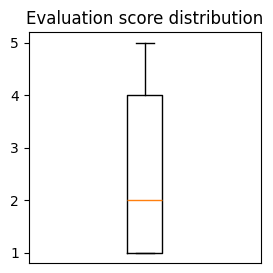

In [77]:
import matplotlib.pyplot as plt

scores = [int(output['eval_score']) for output in outputs]

print(f"Mean score: {np.mean(scores)}")
plt.figure(figsize=(3, 3))
plt.title("Evaluation score distribution")
plt.boxplot(scores)
plt.xticks([]);